# Data Appendix 

The Census conducts the American Housing Survey, which is sponsored by the Departmentof Housing and Urban Development (HUD). The data files can be downloaded from theirwebsite at http://www.census.gov/programs-surveys/The survey has been conductedin every odd-numbered year since 1973.  The codebook for 1997-2013 can be found at http://www.census.gov/programs-surveys/ahs/data/2013We  use  all  of  the  odd-numberedyears since 1985.  Prior to 1985, the value of the home is a categorical variable, so we do notuse those data.Download the flat files and place them into folders to which you then need to point thecode supplementing this data appendix, found in the file named “[TBD]”.

We remove datapoints without an MSA identifier, as we will be building a panel by city.  Weremove units in housing projects, those with bars on the windows, and those that are rentstabilized.  We remove datapoints missing data (such as tenure status, i.e., owner occupiedor renter occupied).We further clean the observations before the hedonic regression as follows
- Delete if the ratio of household income to house value is greater than 2 (This identifiesdata errors in the house value field)
- Delete if the ratio of household income to annual rent is greater than 100 (This identifiesdata errors in the annual rent field)

Throughout the rest of the analysis, we restrict the sample to the top 30 cities by data-points (after cleaning) in 1985, the first year in the sample

# Python Code Implementation

Load the Necessary Modules for Analysis

In [360]:
import pip
try:
    import pandas as pd
except ImportError:
        pip.main(['install', pandas])  
import os

try:
    import numpy as np
except ImportError:
    pip.main(['install', numpy])  
    
try:
    from statsmodels import regression
except ImportError:
        pip.main(['install', statsmodels])  
    
try:
    import warnings
except ImportError:
        pip.main(['install', warnings])  

try:
    from openpyxl import load_workbook
except ImportError:
        pip.main(['install', openpyxl])  

try:
    import xlsxwriter
except ImportError:
        pip.main(['install', xlsxwriter])  
try:
    import matplotlib.pyplot as plt
except ImportError:
        pip.main(['install', matplotlib])  
        
try:
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import ElasticNet
except ImportError:
    pip.main(['install', sklearn])  
        
from datetime import datetime

import pickle 

try:
    from scipy.stats import t
except ImportError:
    pip.main(['install', scipy.stats]) 

warnings.filterwarnings("ignore")

working_directory = os.getcwd()
print(working_directory)
try:
    desktop = os.path.join(os.path.join(os.path.expanduser('~')), 'Desktop') 
except:
    desktop = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop') 
print(desktop)

/home/janko/github_repositories
/home/janko/Desktop


Create a class for cleaning the data

In [361]:
class Cleaning():
    
    def __init__(self,output_file_location ):
        self.output_file_location = output_file_location

    def check_col_float2(self,header_list, df):
        for col in header_list:
            try:
                df.loc[:,col] = df.loc[:,col].str.replace("\'","").str.strip().astype(float)
                
            except AttributeError:
                pass
            except KeyError:
                try:
                    df[col.upper()] = df[col.lower()].str.replace("\'","").str.strip().astype(float)
                except AttributeError:
                    df[col.upper()] = df[col.lower()].copy()
        return df
    
    
    
    def change_airsys_data(self,data):
        
        data.loc[(data['AIRSYS'] == 2) & (data['year'] < 2015), 'AIRSYS'] = 0.0
        data.loc[(data['AIRSYS'] == 12) & (data['year'] >= 2015), 'AIRSYS'] = 0.0
        data.loc[(data['AIRSYS'] != 12) & (data['year'] >= 2015), 'AIRSYS'] = 1.0                
        return data
    
    def change_ebar_data(self,data):
        for i in data.year.unique():
            if i<=1995:
                data.loc[data.year==i,'EBAR']=data.loc[data.year==i,'EBAR'].replace(0,2)
        return data
    
    
    def change_bath_data(self,data):
        for i in data.year.unique():
            if i >=2015 and i<=2017:
                data.loc[data.year==i,'BATHS'] = data.loc[data.year==i,'BATHS'].replace({7: \
                            0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 3:2,4:3,5:3,6:4 })
            else:
                data.loc[data.year==i,'BATHS'] = data.loc[data.year==i,'BATHS'].replace({5:4, \
                            6:4, 7: 4, 8:4, 9:4, 10:4, 11:4, 12:4, 13:4})
        return data
    
    def change_build_data(self,data):
        
        for i in data.year.unique():
            data.loc[data.year==i,'BUILT'] = data.loc[data.year==i,'BUILT'].replace({80: 1980,
                    81:1981,82:1982,83:1983,84:1984,85:1985,86:1986,87:1987,88:1988,89:1989,
                    90:1990,91:1991,92:1992,93:1993,94:1994,95:1995})
                 
        for i in data.year.unique():
            if i >=1985 and i<=1995:
                data.loc[data.year==i,'BUILT'] = data.loc[data.year==i,'BUILT'].replace({9: 1919,
                        8:1920,7:1930,6:1940,5:1950,4:1960,3:1970,2:1970,1:1970})
        
        for i in data.year.unique():
            data.loc[data.year==i,'BUILT']=data.loc[data.year==i,'BUILT'].replace({1919:1910, 1975:1970,
                 1981:1980,1982:1980, 1983:1980,1984:1980,1986:1985,1987:1985,1988:1985,1989:1985,
                 1991:1990,1992:1990, 1993:1990,1994:1990,1996:1995,1997:1995,1998:1995,1999:1995,
                 2001:2000,2002:2000, 2003:2000,2004:2000,2006:2005,2007:2005,2008:2005,2009:2005,
                 2011:2010,2012:2010, 2013:2010,2014:2010})
        """
        for i in data.year.unique():
            data.loc[data.year==i,'BUILT']=(np.floor(data.loc[data.year==i,'BUILT']/10.0)*\
            10.0).astype(int)
        """
                    
            
        for i in data.year.unique():
            if i >=2015 and i<=2017:
                data.loc[data.year==i,'AIRSYS'] = data.loc[data.year==i,'AIRSYS'].replace({2: \
                                    1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1,12:2})
                 
        for i in data.year.unique():
            if i >=2015 and i<=2017:
                data.loc[data.year==i,'BATHS'] = data.loc[data.year==i,'BATHS'].replace({7: 0, \
                    8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 3:2,4:3,5:3,6:4 })
            else:
                data.loc[data.year==i,'BATHS'] = data.loc[data.year==i,'BATHS'].replace({5:4, \
                                    6:4, 7: 4, 8:4, 9:4, 10:4, 11:4, 12:4, 13:4})
        ##modify Ebar data
      #  for i in data.year.unique():
       #     if i<=1995:
       #         data.loc[data.year==i,'EBAR']=data.loc[data.year==i,'EBAR'].replace(0,2)
                
        return data
    
    def append_df_to_excel(self, df, sheet_name='Sheet1', startrow=None,\
                           truncate_sheet=False,**to_excel_kwargs):
        
            # ignore [engine] parameter if it was passed
            if 'engine' in to_excel_kwargs:
                to_excel_kwargs.pop('engine')
        
            writer = pd.ExcelWriter(self.output_file_location, engine='openpyxl')
        
        
        
            try:
                # try to open an existing workbook
                writer.book = load_workbook(self.output_file_location)
        
                # get the last row in the existing Excel sheet
                # if it was not specified explicitly
                if startrow is None and sheet_name in writer.book.sheetnames:
                    startrow = writer.book[sheet_name].max_row
        
                # truncate sheet
                if truncate_sheet and sheet_name in writer.book.sheetnames:
                    # index of [sheet_name] sheet
                    idx = writer.book.sheetnames.index(sheet_name)
                    # remove [sheet_name]
                    writer.book.remove(writer.book.worksheets[idx])
                    # create an empty sheet [sheet_name] using old index
                    writer.book.create_sheet(sheet_name, idx)
        
                # copy existing sheets
                writer.sheets = {ws.title:ws for ws in writer.book.worksheets}
            except FileNotFoundError:
                # file does not exist yet, we will create it
                pass
        
            if startrow is None:
                startrow = 0
        
            # write out the new sheet
            df.to_excel(writer, sheet_name, startrow=startrow, **to_excel_kwargs)
        
            # save the workbook
            writer.save()
            
            
    def get_hist(self, data, filter_code, bincount, name):
            fig, ax = plt.subplots(len(data.year.value_counts()),1, figsize=(20, 60))
            count = 0
            for i in data.year.unique():
                data.loc[data.year == i, filter_code].hist(bins = 5,ax=ax[count])
                ax[count].set_title(filter_code + ' ' + str(i))
                count = count + 1
            fig.savefig(name)    
            
            #get the density plot as well
            self.get_density(data, filter_code, name)
            
    def get_density(self, data, filter_code, name):
            fig, ax = plt.subplots(len(data.year.value_counts()),1, figsize=(20, 60))
            count = 0
            for i in data.year.unique():
                data.loc[data.year == i, filter_code].plot.kde(ax=ax[count])
                ax[count]
                ax[count].set_title(filter_code + ' ' + str(i))
                count = count + 1
            fig.savefig(name+'_density_plot')    
        
        
         
    
    def get_distribution(self,data, filter_code, sheetname, rowloc, title, bins=None, write = True):
        dct = {}
        
        for i in data.year.unique():
                dct[i] = data.loc[data.year == i, filter_code].value_counts()
                
        dct = pd.DataFrame(dct)
        if write:
            title_df = pd.DataFrame([title])
            try:
                self.append_df_to_excel(title_df,sheet_name=sheetname, startrow=rowloc,\
                                        truncate_sheet=False, header = False)

                self.append_df_to_excel(dct,sheet_name=sheetname, startrow=rowloc+1,\
                                        truncate_sheet=False)
            except PermissionError:
                pass
        
        return dct


    def change_rent_data(self, hedonic_model_data):
        
        hedonic_model_data = hedonic_model_data.loc[~((hedonic_model_data['year']<=1995) & \
                                                      (hedonic_model_data['RENT'] == 1))]
        hedonic_model_data = hedonic_model_data.loc[~((hedonic_model_data['year']<=1995) & \
                                                      (hedonic_model_data['RENT'] == 999))]
        hedonic_model_data = hedonic_model_data.loc[~((hedonic_model_data['year']<=1995) & \
                                                      (hedonic_model_data['RENT'] == 9999))]
        
        
        hedonic_model_data = hedonic_model_data.loc[~((hedonic_model_data['year']> 1995) & \
                                                      (hedonic_model_data['RENT'] == 9999))]
        
        hedonic_model_data.loc[:, 'RENT'] = hedonic_model_data.loc[:, 'RENT']*12.0
        return hedonic_model_data
    
    def clean_rooms(self, hedonic_model_data):
        #gets rid of the data with -6 and -9 response codes
        hedonic_model_data = hedonic_model_data.loc[hedonic_model_data['ROOMS'] >= 1]
        #gets rid of the top coded values
        hedonic_model_data = hedonic_model_data.loc[~((hedonic_model_data['year']>= 1995) & \
                    (hedonic_model_data['year']<= 2017) &(hedonic_model_data['ROOMS'] >= 21))]
        
        hedonic_model_data = hedonic_model_data.loc[~((hedonic_model_data['year']>= 1985) & \
                    (hedonic_model_data['year']<= 1995) &(hedonic_model_data['ROOMS'] >= 21))] 
        
        return hedonic_model_data
    
    def clean_built(self,hedonic_model_data):
        hedonic_model_data = self.change_build_data(hedonic_model_data)
        hedonic_model_data = hedonic_model_data.loc[hedonic_model_data['BUILT'] >= 1]

        hedonic_model_data = hedonic_model_data.loc[~((hedonic_model_data['year']<=1995) & \
                                                      (hedonic_model_data['BUILT'] == 99))]
        hedonic_model_data = hedonic_model_data.loc[~((hedonic_model_data['year']>1995) & \
                                                      (hedonic_model_data['BUILT'] == 'B'))]
        return hedonic_model_data

        
    def clean_value(self, hedonic_model_data):
        
        #hedonic_model_data = hedonic_model_data.loc[~((hedonic_model_data['year']<=1995) & \
         #                                             (hedonic_model_data['VALUE'].isin([999999])))]  #delete not applicable
    
        hedonic_model_data = hedonic_model_data.loc[~((hedonic_model_data['year']>1995) & \
                                                     (hedonic_model_data['year']<2015) & \
                                                      (hedonic_model_data['VALUE']==-6))] #delete not applicable
        
        hedonic_model_data = hedonic_model_data.loc[~((hedonic_model_data['year']>1995) & \
                                                     (hedonic_model_data['year']<2015) & \
                                                      (hedonic_model_data['VALUE']=='B'))] #delete not applicable
        
        hedonic_model_data = hedonic_model_data.loc[~((hedonic_model_data['year']>=2015) & \
                                                      (hedonic_model_data['VALUE']==-6))]  #delete not applicable
        
        hedonic_model_data = hedonic_model_data.loc[~((hedonic_model_data['year']>=2015) & \
                                                      (hedonic_model_data['VALUE']=='N'))]  #delete not applicable
        
        quant_remove = .05
        hedonic_model_data = hedonic_model_data.loc[hedonic_model_data['VALUE'] > 0]
        lower_quant = hedonic_model_data.loc[:,'VALUE'].quantile(quant_remove)
        upper_quant = hedonic_model_data.loc[:,'VALUE'].quantile(1.0-quant_remove)
        hedonic_model_data = hedonic_model_data.loc[hedonic_model_data['VALUE'] > lower_quant]
        hedonic_model_data = hedonic_model_data.loc[hedonic_model_data['VALUE'] < upper_quant]

        return hedonic_model_data

        
    def clean_ebar(self,hedonic_model_data):
        hedonic_model_data = self.change_ebar_data(hedonic_model_data)
        hedonic_model_data = hedonic_model_data.loc[~((hedonic_model_data['EBAR'].isin([1])) & (hedonic_model_data['year'] >= 1997 ) )]
        hedonic_model_data = hedonic_model_data.loc[~((hedonic_model_data['EBAR'].isin([1])) & (hedonic_model_data['year'] < 1997 ) )]
        return hedonic_model_data   
    
    
    def clean_bdrms(self, hedonic_model_data):

        #gets rid of the data with -6 and -9 response codes
        hedonic_model_data = hedonic_model_data.loc[hedonic_model_data['BEDRMS'] >= 0]
        #gets rid of the top coded values
        """
        hedonic_model_data = hedonic_model_data.loc[~((hedonic_model_data['year']>= 2015) & \
                    (hedonic_model_data['year']<= 2017) &(hedonic_model_data['BEDRMS'] == 10))]
        
        hedonic_model_data = hedonic_model_data.loc[~((hedonic_model_data['year']> 1995) & \
                    (hedonic_model_data['year']< 2015) &(hedonic_model_data['BEDRMS'] == 10))]
        
        hedonic_model_data = hedonic_model_data.loc[~((hedonic_model_data['year']>= 1985) & \
                    (hedonic_model_data['year']<= 1995) &(hedonic_model_data['BEDRMS'] == 10))] 
        
        
        """
        
        hedonic_model_data = hedonic_model_data.loc[~((hedonic_model_data['year']>= 1985) & \
                    (hedonic_model_data['year']<= 1995) &(hedonic_model_data['BEDRMS'] == 99))] 
        
        return hedonic_model_data
    
    def clean_rcntrl(self, hedonic_model_data):
        hedonic_model_data = hedonic_model_data.loc[~((hedonic_model_data['RCNTRL'].isin([1])) & (hedonic_model_data['year'] >= 1997 ) )]
        hedonic_model_data = hedonic_model_data.loc[~((hedonic_model_data['RCNTRL'].isin([1])) & (hedonic_model_data['year'] < 1997 ) )]
        return hedonic_model_data       
    
    def clean_income(self,hedonic_model_data):
        hedonic_model_data = hedonic_model_data.loc[~((hedonic_model_data['year']<=1995) & \
                                                      (hedonic_model_data['ZINC2']==999999))] #delete not interview
        hedonic_model_data = hedonic_model_data.loc[~((hedonic_model_data['year']>1995) & \
                                                      (hedonic_model_data['ZINC2']==9999996))] #delete not interview
        hedonic_model_data = hedonic_model_data.loc[~((hedonic_model_data['year']>1995) & \
                                                      (hedonic_model_data['ZINC2']==-6))] #delete not applicable
        hedonic_model_data = hedonic_model_data.loc[~((hedonic_model_data['year']>1995) & \
                                                      (hedonic_model_data['ZINC2']=='B'))] #delete not applicable
        return hedonic_model_data
    
    
    def clean_tenure(self, hedonic_model_data):
        hedonic_model_data = hedonic_model_data.loc[(hedonic_model_data['TENURE'].isin([1,2]))]
        return hedonic_model_data
    
    def clean_baths(self, hedonic_model_data):
        hedonic_model_data = hedonic_model_data.loc[~(hedonic_model_data['BATHS'].isin([-6,-9,99]))]
        return hedonic_model_data
    
    def clean_type(self, hedonic_model_data):
        hedonic_model_data['Unit Type'] = np.nan
        hedonic_model_data.loc[(hedonic_model_data['TYPE'] == 2) & (hedonic_model_data['year'] >= 2015), 'Unit Type']\
        = 1.0
        hedonic_model_data.loc[(hedonic_model_data['TYPE'] ==3) & (hedonic_model_data['year'] >= 2015), 'Unit Type']\
        = 0.0      
        hedonic_model_data.loc[(hedonic_model_data['TYPE'] ==1) & (hedonic_model_data['year'] >= 1997) &\
                               (hedonic_model_data['year'] < 2015), 'Unit Type'] = 1.0     
        hedonic_model_data.loc[(hedonic_model_data['TYPE'] ==2) & (hedonic_model_data['year'] >= 1997) & \
                               (hedonic_model_data['year'] < 2015), 'Unit Type'] = 0.0   
        hedonic_model_data.loc[(hedonic_model_data['TYPE'] ==1) & (hedonic_model_data['year'] >= 1985) &\
                               (hedonic_model_data['year'] < 1997), 'Unit Type'] = 1.0     
        hedonic_model_data.loc[(hedonic_model_data['TYPE'] ==2) & (hedonic_model_data['year'] >= 1985) & \
                               (hedonic_model_data['year'] < 1997), 'Unit Type'] = 0.0   
        hedonic_model_data = hedonic_model_data.loc[hedonic_model_data['Unit Type'].isin([0.0,1.0])]
        return hedonic_model_data
    
    def clean_cities(self, hedonic_model_data):
        same_smsa = {'35620':5600,'31080':4480,'16980':1600,'19100':1920,'37980':6160,'26420':3360,'47900':8840,'33100':5000,'12060':520,'14460':1120,'41860':7360,'19820':2160,'40140':6780,'38060':6200,'42660':7600,'19740':2080,'38300':6280,'38900':6440,'17140':1640,'17460':1680,'28140':3760,'33340':5080,'32820':4920,'35380':5560,'39580':6640,'33460':5120,'45300':8280,'12580':720,'41700':7240,'29820':4120,'41940':7400,'36420':5880,'40060':6760,'13820':1000,'40380':6840}
        #the reverse key value relationship dictioanry
        same_smsa_back = {'5600': 35620, '4480': 31080, '1600': 16980, '1920': 19100, '6160': 37980, '3360': 26420, '8840': 47900, '5000': 33100, '520': 12060, '1120': 14460, '7360': 41860, '2160': 19820, '6780': 40140, '6200': 38060, '7600': 42660, '2080': 19740, '6280': 38300, '6440': 38900, '1640': 17140, '1680': 17460, '3760': 28140, '5080': 33340, '4920': 32820, '5560': 35380, '6640': 39580, '5120': 33460, '8280': 45300, '720': 12580, '7240': 41700, '4120': 29820, '7400': 41940, '5880': 36420, '6760': 40060, '1000': 13820, '6840': 40380}

        #took the top 30 cities from Eisfeldt's paper
        eisfeldt_top_30 = {"6280": "Pittsburgh","7040": "St. Louis","3760": "Kansas City","3360": "Houston","1920": "Dallas","5880": "Oklahoma City","1680": "Cleveland ","6160": "Philadelphia","520": "Atlanta","5120": "Minneapolis","7600": "Seatle","720": "Baltimore","5380": "Nassau-Suffolk","5680": "Virginia Beach","1600": "Chicago","8280": "Tampa","8840": "Washington","5000": "Miami","7360": "San Fransico","1120": "Boston","7320": "San Diego","7400": "San Jose","360": "Anaheim","2160": "Detroit","5640": "Newark","5600": "New York","5775": "Oakland","4480": "Los Angeles","6200": "Phoenix","6780": "Riverside"}



        vals = []
        for iterate in eisfeldt_top_30.keys():
            vals.append(float(iterate))


        _vals = []
        for v in vals:
            if str(int(v)) in same_smsa_back.keys():
                _vals.append(same_smsa_back[str(int(v))])
        
        
        hedonic_model_data_1 = hedonic_model_data.loc[(hedonic_model_data['year'] >= 2015) & \
                                                    (hedonic_model_data['SMSA'].isin(_vals))]
        
        hedonic_model_data_2 = hedonic_model_data.loc[(hedonic_model_data['year'] < 2015) & \
                                                    (hedonic_model_data['SMSA'].isin(vals))]
        
        hedonic_model_data = pd.concat([hedonic_model_data_1, hedonic_model_data_2], axis = 0)
        
        
        for i in same_smsa.keys():
            hedonic_model_data.loc[hedonic_model_data.SMSA == float(i),'SMSA'] = same_smsa[i]
            
        hedonic_model_data  ['CITY'] = ''
        for i in eisfeldt_top_30.keys():
            hedonic_model_data.loc[hedonic_model_data['SMSA'] == float(i), 'CITY'] = eisfeldt_top_30[str(i)]
        
        return hedonic_model_data   
    
    def clean_airsys(self, hedonic_model_data):
        # 0.0 means that there is no central air
        #1.0 means that there is central air
        hedonic_model_data = hedonic_model_data.loc[~((hedonic_model_data['year']>= 1985) & \
                    (hedonic_model_data['year']<= 1995) &(hedonic_model_data['AIRSYS'].isin([-9,9])))] 
        hedonic_model_data = hedonic_model_data.loc[~((hedonic_model_data['year']>= 1997) & \
                    (hedonic_model_data['year']<= 2013) &(hedonic_model_data['AIRSYS'].isin([-6])))] 
        hedonic_model_data.loc[(hedonic_model_data['AIRSYS'] == 2) & (hedonic_model_data['year'] < 2015), 'AIRSYS'] = 0.0
        hedonic_model_data.loc[(hedonic_model_data['AIRSYS'] == 12.) & (hedonic_model_data['year'] >= 2015), 'AIRSYS'] = 0.0
        hedonic_model_data.loc[(hedonic_model_data['AIRSYS'] >= 1.)& (hedonic_model_data['AIRSYS'] < 12.) & (hedonic_model_data['year'] >= 2015), 'AIRSYS'] = 1.0
        
        return hedonic_model_data
    
    def clean_rent(self, hedonic_model_data):
        hedonic_model_data = hedonic_model_data.loc[hedonic_model_data['RENT'] > 1]
        hedonic_model_data = hedonic_model_data.loc[~((hedonic_model_data['year']> 1995) & (hedonic_model_data['RENT'].isin([-6, 1,0, 99999])))]
        hedonic_model_data = hedonic_model_data.loc[~((hedonic_model_data['year']<=1995) & (hedonic_model_data['RENT'].isin([9999,0,999,1,-6,99999])))]
        
        #convert the rent to yearly number
        hedonic_model_data.loc[:, 'RENT'] = hedonic_model_data.loc[:, 'RENT']*12.0
        hedonic_model_data['log rent'] = np.log(hedonic_model_data['RENT'])
        
        return hedonic_model_data
    
    def clean_ratios(self, hedonic_model_data):
        hedonic_model_data = hedonic_model_data.loc[~(hedonic_model_data['Income to Value Ratio'] > 2.)]
        hedonic_model_data = hedonic_model_data.loc[~(hedonic_model_data['Income to Rent Ratio'] > 100.)]
        
        return hedonic_model_data
    
    def clean_sequential(self, hedonic_model_data):

        hedonic_model_data = c.clean_rent(hedonic_model_data)
        hedonic_model_data = c.clean_bdrms(hedonic_model_data)
        hedonic_model_data = c.clean_rooms(hedonic_model_data)
        hedonic_model_data = c.clean_rcntrl(hedonic_model_data)
        hedonic_model_data = c.clean_tenure(hedonic_model_data)
        hedonic_model_data = c.clean_cities(hedonic_model_data)
        hedonic_model_data = c.clean_rent(hedonic_model_data)
        hedonic_model_data = c.clean_ratios(hedonic_model_data)
        hedonic_model_data = c.clean_type(hedonic_model_data)
        hedonic_model_data = c.clean_ebar(hedonic_model_data)
        hedonic_model_data=c.clean_income(hedonic_model_data)
        hedonic_model_data = c.clean_value(hedonic_model_data)
        hedonic_model_data = c.clean_built(hedonic_model_data)
        
        
        return hedonic_model_data

## output the results to excel

We will output our results to a local excel file as well with the following code. 



In [362]:
#we will write our results to a local excel file called breakdown
now = datetime.now()
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S_%f")

if not os.path.exists(os.path.join(working_directory, 'output_results')):
    os.mkdir(os.path.join(working_directory, 'output_results'))

outputfile = os.path.join(working_directory, 'output_results','breakdown_' + dt_string + '.xlsx')
print(outputfile )


workbook = xlsxwriter.Workbook(outputfile)
workbook.close()   


/home/janko/github_repositories/output_results/breakdown_26_06_2020_13_20_46_536404.xlsx


Create a class for calculations

instantiate the class with objects so that we can do our analysis

In [363]:
    c = Cleaning(outputfile)

## Reading the Data

read the cleaned files in a local directory and concatenate the data into one data frame called hedonic_model_data for analysis. This data contains the relevant variables of interest 

In [364]:
    filepath = os.path.join(working_directory, 'data2')
    print('this is the directory where the data is located')
    print(filepath)
    
    hedonic_model_data = pd.DataFrame()
    sample = {}
    for item in os.listdir(filepath):
        if item[0] == 'o':
            year = int(item.split(".")[0][1:])
            #we will only read data for the years 1985-2013 due to the boundary issue.
            if year < 2015:
                data = pd.read_hdf(os.path.join(filepath, item))
                #we will renormalize the weights so that they add up to one
                
                data.loc[:,'WEIGHT'] = data.loc[:,'WEIGHT'] / data.loc[:,'WEIGHT'].sum()

                if len(hedonic_model_data.index) == 0:
                    hedonic_model_data = data.copy()
                else:
                    hedonic_model_data = pd.concat([hedonic_model_data, data.copy()], axis = 0)
                
    hedonic_model_data['Income to Value Ratio'] = hedonic_model_data['ZINC2'] / hedonic_model_data['VALUE']
    hedonic_model_data['Income to Rent Ratio'] = hedonic_model_data['ZINC2'] / hedonic_model_data['RENT']
    hedonic_model_data = hedonic_model_data.sort_values(by = ['year'])
    hedonic_model_data= hedonic_model_data.reset_index(drop=True)
    print(hedonic_model_data.head(10))
    print(hedonic_model_data['VACANCY'].unique())
    

this is the directory where the data is located
/home/janko/github_repositories/data2
   year  RENT   ZINC2  EBAR  RCNTRL  VALUE  NUNIT2  CONDO  TENURE    SMSA  \
0  1985  9999  127000   0.0     9.0  60000     1.0    3.0     1.0  8280.0   
1  1985    -9   38600   0.0    -9.0  68000     1.0    3.0     1.0  7680.0   
2  1985    -9    8600   0.0    -9.0  55000     1.0    3.0     1.0  8160.0   
3  1985   310   25000   0.0     2.0     -9     3.0    3.0     2.0  8160.0   
4  1985   435   20000   0.0     2.0     -9     3.0    3.0     2.0  8160.0   
5  1985   425      -9   0.0     2.0     -9     3.0    3.0    -9.0  8160.0   
6  1985   435   20000   0.0     2.0     -9     3.0    3.0     2.0  8160.0   
7  1985   440   24000   0.0     2.0     -9     3.0    3.0     2.0  8160.0   
8  1985   500   13500   0.0     2.0     -9     3.0    3.0     2.0  8160.0   
9  1985    -9   29000   0.0    -9.0  16000     4.0    3.0     1.0  6780.0   

   ROOMS  BATHS  AIRSYS  TYPE  BUILT  BEDRMS    WEIGHT  VACANCY  \

In [365]:
hedonic_model_data.columns

Index(['year', 'RENT', 'ZINC2', 'EBAR', 'RCNTRL', 'VALUE', 'NUNIT2', 'CONDO',
       'TENURE', 'SMSA', 'ROOMS', 'BATHS', 'AIRSYS', 'TYPE', 'BUILT', 'BEDRMS',
       'WEIGHT', 'VACANCY', 'Income to Value Ratio', 'Income to Rent Ratio'],
      dtype='object')

print out the data to make sure that it was read correctly

In [366]:

all_data = hedonic_model_data.copy()
all_data.to_pickle(os.path.join(desktop,'data.pkl'))

break up the data to renter occupied or owner occupied based off tenure

In [367]:
ten = c.get_distribution(all_data, 'TENURE','TENURE',1, title = 'All Data' + 'TENURE')
owned = hedonic_model_data.loc[hedonic_model_data['TENURE'] == 1.]
rented = hedonic_model_data.loc[hedonic_model_data['TENURE'].isin([2])]
print(rented['TENURE'].unique())
print(rented['VACANCY'].unique())
errors = hedonic_model_data.loc[hedonic_model_data['TENURE'].isin([-9,-6,9])]

print("the number of owned homes")
print(len(owned))
print("the number of rented homes")
print(len(rented))
print("the ratio of owned homes to rented")
print(len(owned) / len(rented))
print(ten)


var = 'TYPE'
err = c.get_distribution(errors, var,var,1, title = 'Errors' + var)
print(" ")
print("Error Types")
print(err)

[2.]
[-9  7 10  8 99 11  9 -6]
the number of owned homes
446952
the number of rented homes
300186
the ratio of owned homes to rented
1.4889168715396455
         1985     1987     1989     1991     1993     1995     1997     1999  \
-9.0   2980.0   2674.0   3492.0   3026.0   4073.0   4558.0      NaN      NaN   
-6.0      NaN      NaN      NaN      NaN      NaN      NaN   4832.0   5844.0   
 1.0  38641.0  29969.0  32951.0  33344.0  32415.0  33200.0  12748.0  16581.0   
 2.0  30804.0  23510.0  24265.0  25405.0  23029.0  19844.0   8750.0  10965.0   
 3.0    957.0    718.0    745.0    881.0    755.0    768.0    261.0    299.0   
 9.0   7977.0   5638.0   9676.0   9500.0   7088.0   3919.0      NaN      NaN   

         2001     2003     2005     2007     2009     2011     2013  
-9.0      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
-6.0   5067.0   6766.0   6453.0  10341.0  13613.0  19270.0  17206.0  
 1.0  13408.0  16880.0  13697.0  23253.0  19244.0  67689.0  62932.0  
 2.0   

## Data Selection

check the weights for each year

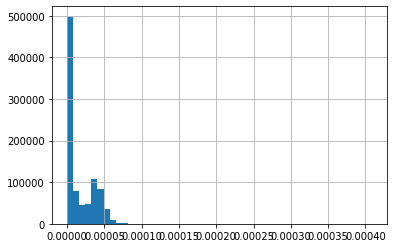

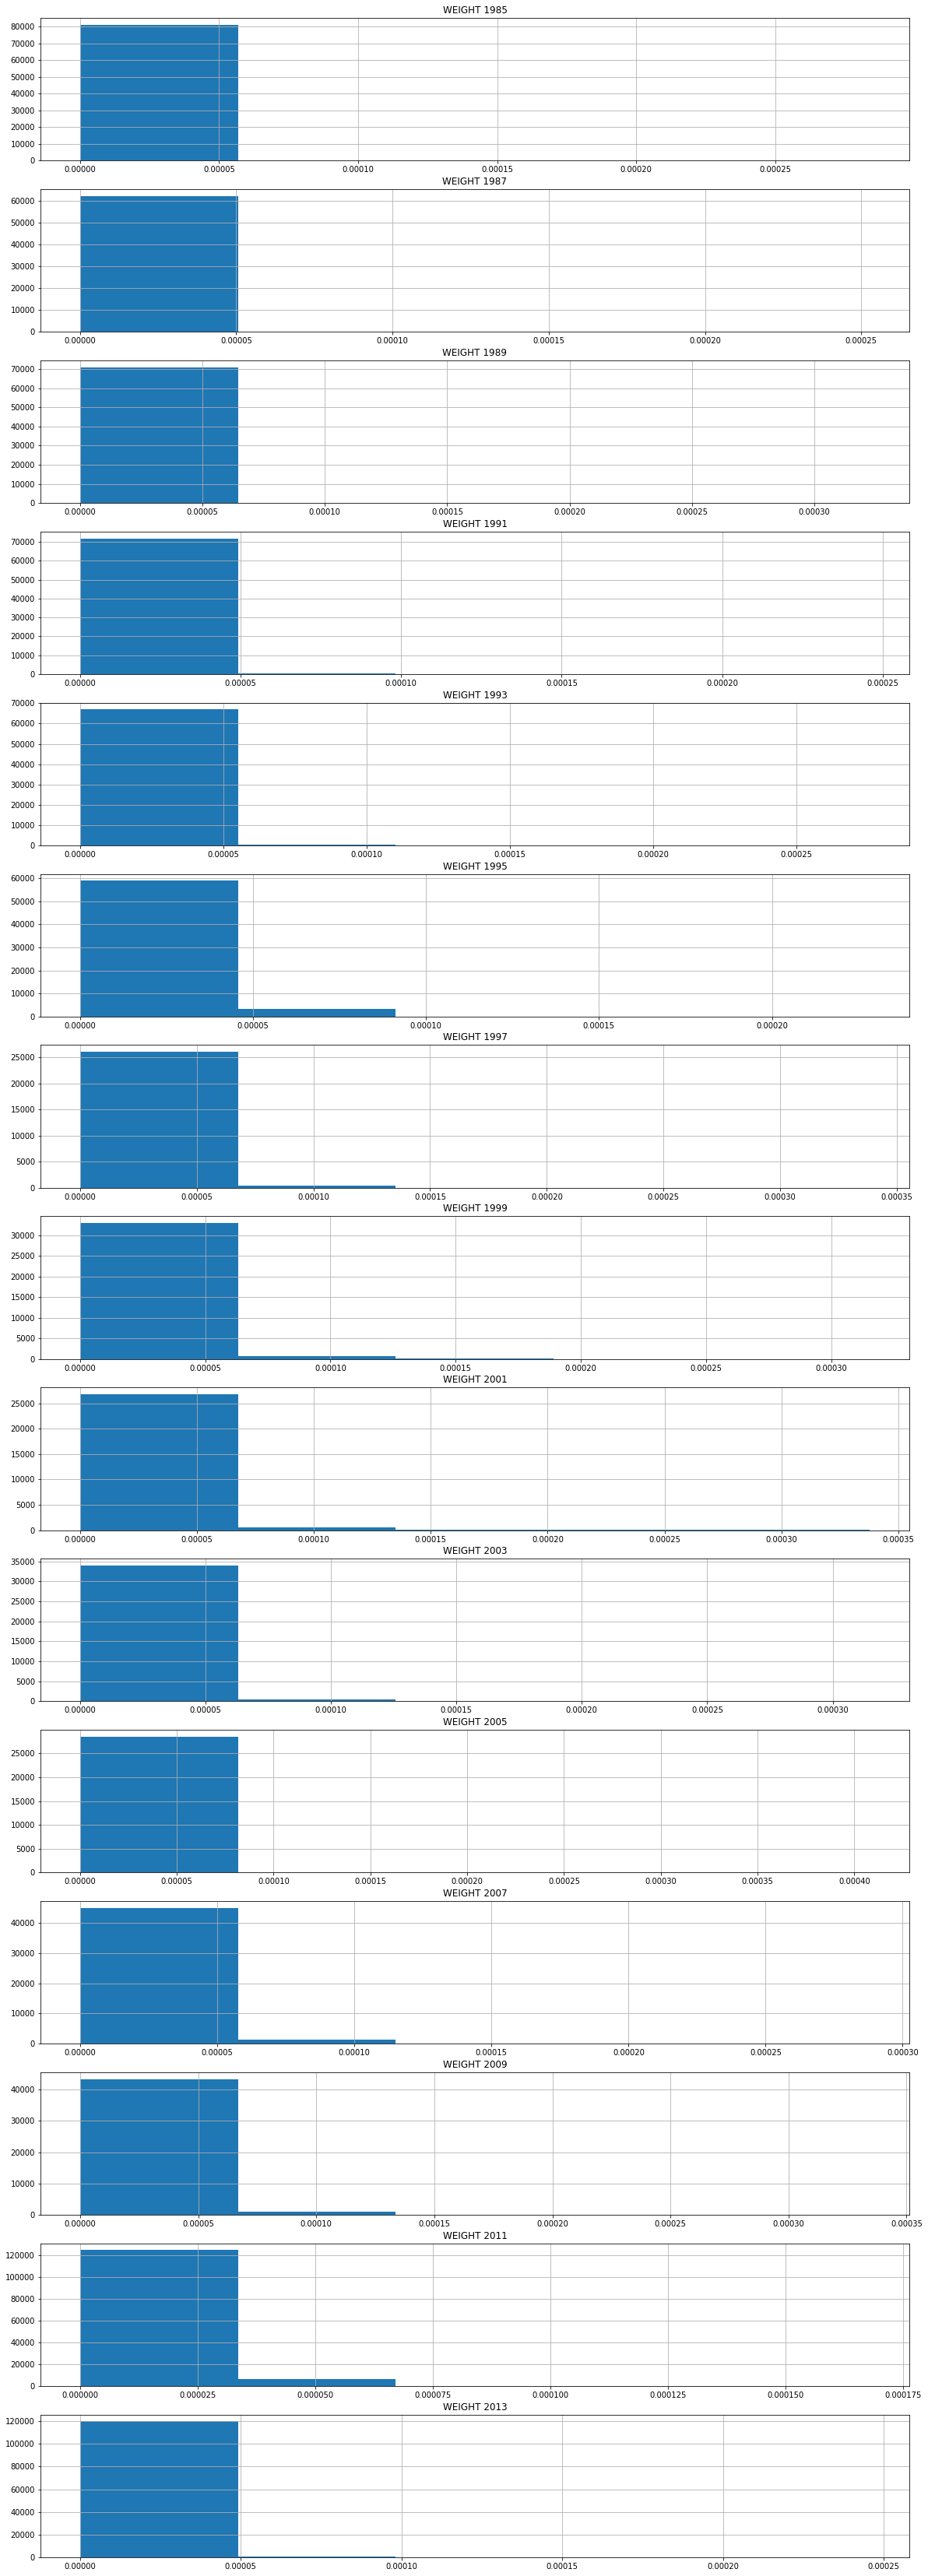

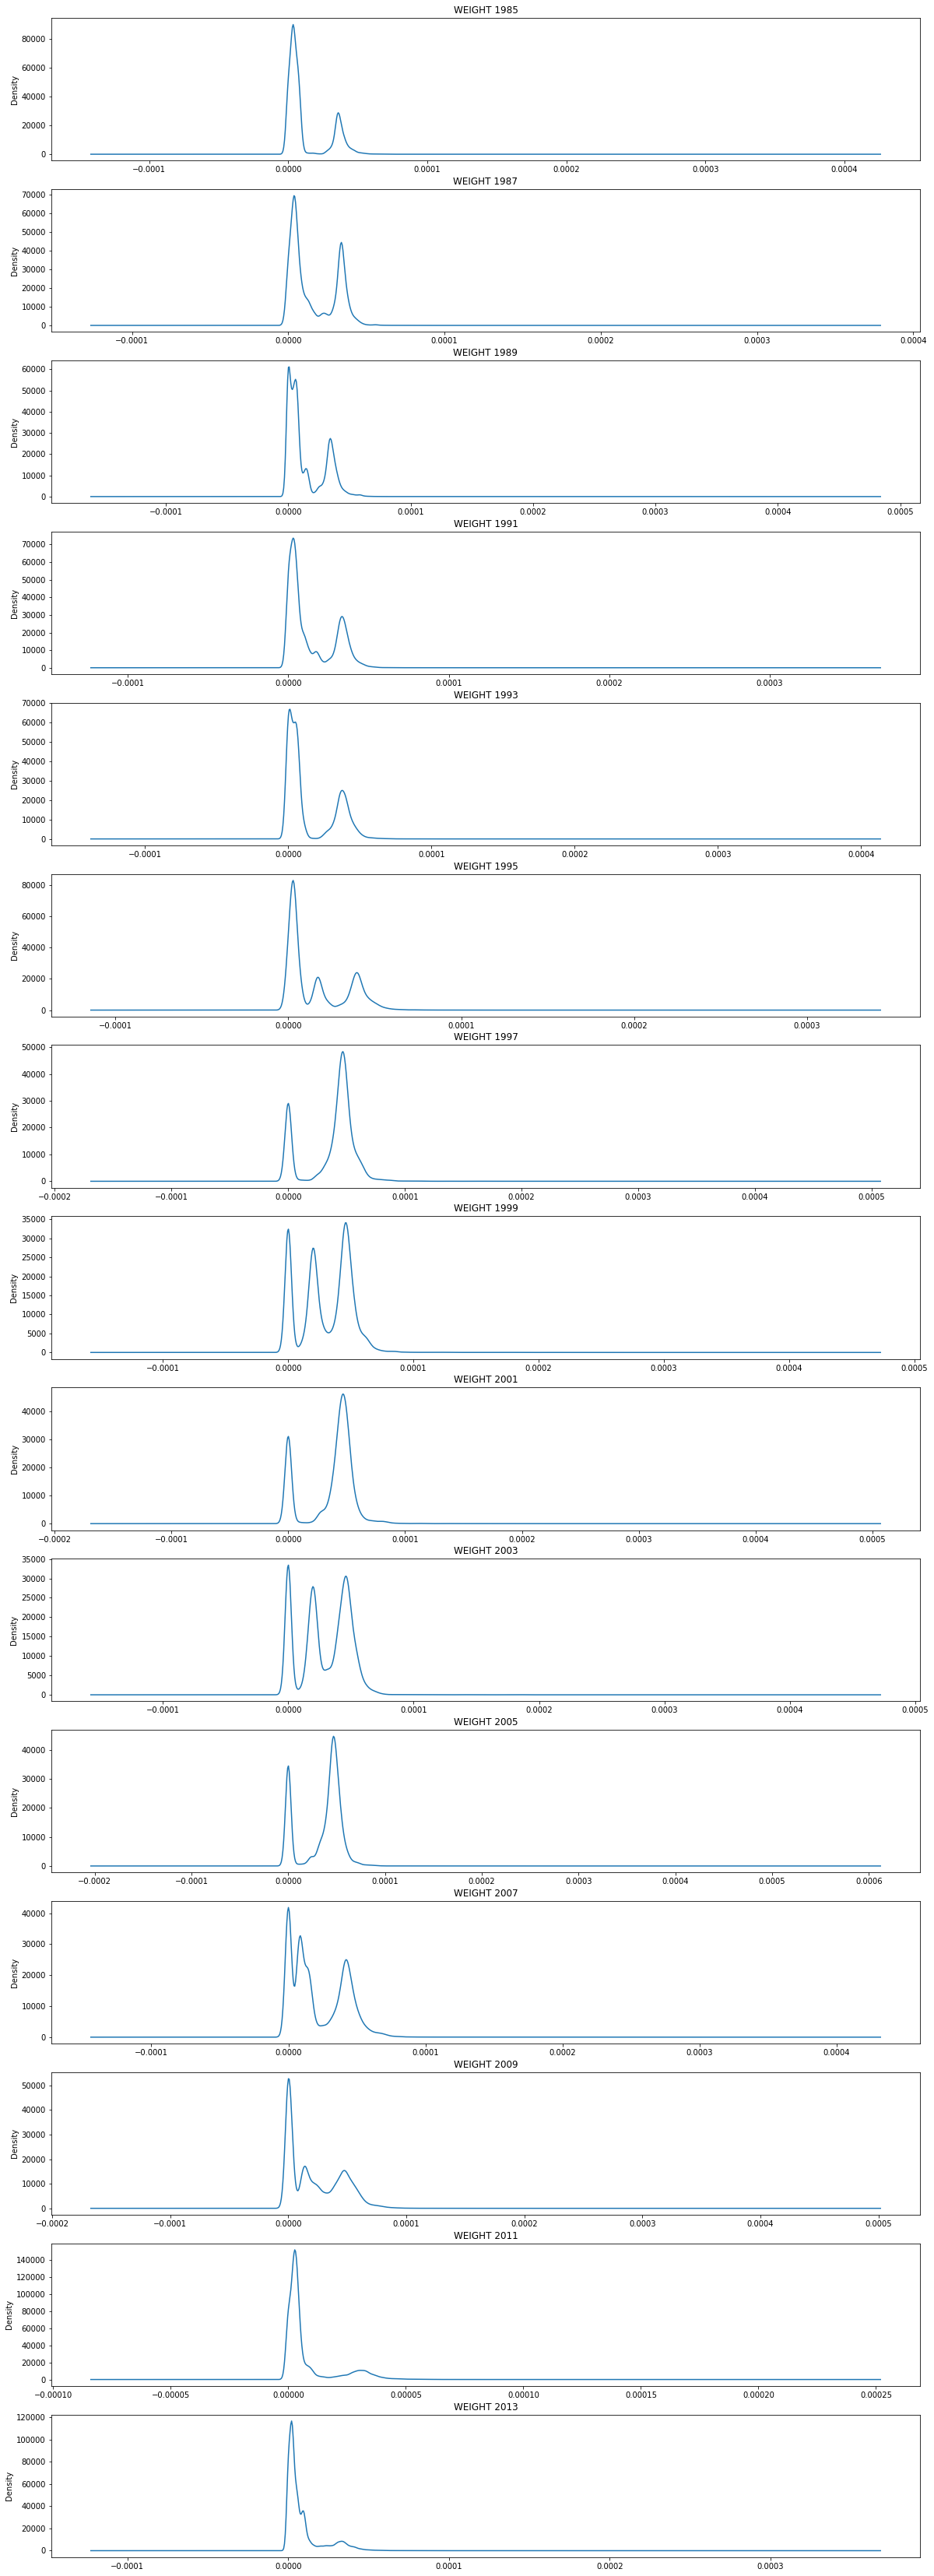

In [368]:
all_data ['WEIGHT'].hist(bins = 50)
c.get_hist(all_data, 'WEIGHT', 3,'WEIGHT')

### Clean the data for Baths

In [369]:
baths = c.get_distribution(all_data, 'BATHS','BATHS',1, title = 'All Data' + 'BATHS')
print(baths)

print('owned')
owned_baths = c.get_distribution(owned, 'BATHS','BATHS',1, title = 'Owned' + 'BATHS')
print(owned_baths)

print('rented')
rented_baths = c.get_distribution(rented, 'BATHS','BATHS',1, title = 'Rented' + 'BATHS')
print(rented_baths)

        1985     1987     1989     1991     1993     1995     1997     1999  \
-9    2261.0   1787.0   2689.0   2468.0   2908.0   4459.0      NaN      NaN   
-6       NaN      NaN      NaN      NaN      NaN      NaN   5383.0   6977.0   
 0     557.0    420.0    396.0    448.0    407.0    325.0    271.0    347.0   
 1   50719.0  38618.0  39552.0  40788.0  36670.0  33523.0  13438.0  16709.0   
 2   18923.0  15496.0  18038.0  17949.0  17979.0  18341.0   6412.0   8295.0   
 3    2212.0   1768.0   2232.0   2224.0   2747.0   2459.0    917.0   1149.0   
 4     231.0    202.0    234.0    279.0    313.0    346.0    138.0    174.0   
 5      53.0     20.0     43.0     49.0     57.0     71.0     23.0     30.0   
 6       6.0      8.0     12.0     10.0     11.0     13.0      4.0      6.0   
 7       8.0      1.0      4.0      7.0      3.0      9.0      1.0      NaN   
 8       NaN      1.0      2.0      3.0      1.0      2.0      4.0      NaN   
 9       2.0      NaN      NaN      1.0      1.0    


Response Codes:

0:9: 0-9 full bathrooms
10: 10 or more full bathrooms
B or -6: Not applicable

We remove -6,-9 and 99


In [370]:
baths = c.clean_baths(all_data)
owned_rooms = c.clean_baths(owned)
rented_rooms = c.clean_baths(rented)

print("the percentage of the data removed")
print(round(1.0 - len(baths)/ len(all_data),2)*100.0)

baths = c.get_distribution(all_data, 'BATHS','BATHS',1, title = 'All Data' + 'BATHS')
print(baths)

print('owned')
owned_baths = c.get_distribution(owned, 'BATHS','BATHS',1, title = 'Owned' + 'BATHS')
print(owned_baths)

print('rented')
rented_baths = c.get_distribution(rented, 'BATHS','BATHS',1, title = 'Rented' + 'BATHS')
print(rented_baths)


the percentage of the data removed
17.0
        1985     1987     1989     1991     1993     1995     1997     1999  \
-9    2261.0   1787.0   2689.0   2468.0   2908.0   4459.0      NaN      NaN   
-6       NaN      NaN      NaN      NaN      NaN      NaN   5383.0   6977.0   
 0     557.0    420.0    396.0    448.0    407.0    325.0    271.0    347.0   
 1   50719.0  38618.0  39552.0  40788.0  36670.0  33523.0  13438.0  16709.0   
 2   18923.0  15496.0  18038.0  17949.0  17979.0  18341.0   6412.0   8295.0   
 3    2212.0   1768.0   2232.0   2224.0   2747.0   2459.0    917.0   1149.0   
 4     231.0    202.0    234.0    279.0    313.0    346.0    138.0    174.0   
 5      53.0     20.0     43.0     49.0     57.0     71.0     23.0     30.0   
 6       6.0      8.0     12.0     10.0     11.0     13.0      4.0      6.0   
 7       8.0      1.0      4.0      7.0      3.0      9.0      1.0      NaN   
 8       NaN      1.0      2.0      3.0      1.0      2.0      4.0      NaN   
 9       2.0

### Clean the data for rooms 

In [371]:
    rooms = c.get_distribution(all_data, 'ROOMS','ROOMS',1, title = 'All Data' + 'ROOMS')
    print(rooms)
    
    owned_rooms = c.get_distribution(owned, 'ROOMS','ROOMS',1, title = 'Owned' + 'ROOMS')
    print(owned_rooms)
    
    rented_rooms = c.get_distribution(rented, 'ROOMS','ROOMS',1, title = 'Rented' + 'ROOMS')
    print(rented_rooms)

        1985     1987     1989     1991     1993     1995    1997    1999  \
-9    2261.0   1787.0   2689.0   2468.0   2908.0   4459.0     NaN     NaN   
-6       NaN      NaN      NaN      NaN      NaN      NaN  5383.0  6977.0   
 1     947.0    614.0    716.0    637.0    729.0    490.0   116.0   206.0   
 2    1612.0   1033.0   1148.0   1052.0   1034.0    833.0   347.0   500.0   
 3   10482.0   7617.0   7991.0   7780.0   7336.0   6220.0  3018.0  3493.0   
 4   14917.0  12123.0  12367.0  12568.0  11415.0  10350.0  4527.0  5446.0   
 5   14723.0  11482.0  12472.0  12819.0  11645.0  11232.0  4012.0  5467.0   
 6   12847.0  10021.0  11185.0  11208.0  10491.0  10721.0  3763.0  5190.0   
 7    8189.0   6348.0   7013.0   7289.0   6957.0   7132.0  2503.0  3043.0   
 8    4847.0   4066.0   4243.0   4767.0   4562.0   4460.0  1545.0  1857.0   
 9    2481.0   1917.0   2053.0   2151.0   2348.0   2134.0   789.0   885.0   
 10    983.0    756.0    793.0    877.0    979.0    923.0   316.0   341.0   

For the years 1985-1995 a response code of -9 represents not applicable. For the years 1997-2013 a response code of -6 represents not applicable. For this time frame it is top coded for 21 rooms or more. The years 2015 and 2017 do not have response codes for not applicable. For this time frame it is top coded for 27 rooms or more. For the years 1985-1993 it is top coded for 21.

 hedonic_model_data = c.clean_rooms(hedonic_model_data)
 rooms = c.get_distribution(hedonic_model_data, 'ROOMS','ROOMS',1, title = 'All Data' + 'ROOMS')
 print(rooms)

<b>cleaned data output<b>

In [372]:
rooms = c.clean_rooms(all_data)
owned_rooms = c.clean_rooms(owned)
rented_rooms = c.clean_rooms(rented)
print("the percentage of the data removed")
print(round(1.0 - len(rooms)/ len(all_data),2)*100.0)
rooms = c.get_distribution(rooms, 'ROOMS','ROOMS',1, title = 'All Data' + 'ROOMS')
print(rooms)

owned_rooms = c.get_distribution(owned, 'ROOMS','ROOMS',1, title = 'Owned' + 'ROOMS')
print(owned_rooms)

rented_rooms = c.get_distribution(rented, 'ROOMS','ROOMS',1, title = 'Rented' + 'ROOMS')
print(rented_rooms)



the percentage of the data removed
17.0
       1985     1987     1989     1991   1993   1995  1997    1999    2001  \
1     947.0    614.0    716.0    637.0    729    490   116   206.0   151.0   
2    1612.0   1033.0   1148.0   1052.0   1034    833   347   500.0   375.0   
3   10482.0   7617.0   7991.0   7780.0   7336   6220  3018  3493.0  2694.0   
4   14917.0  12123.0  12367.0  12568.0  11415  10350  4527  5446.0  4237.0   
5   14723.0  11482.0  12472.0  12819.0  11645  11232  4012  5467.0  4575.0   
6   12847.0  10021.0  11185.0  11208.0  10491  10721  3763  5190.0  4121.0   
7    8189.0   6348.0   7013.0   7289.0   6957   7132  2503  3043.0  2439.0   
8    4847.0   4066.0   4243.0   4767.0   4562   4460  1545  1857.0  1499.0   
9    2481.0   1917.0   2053.0   2151.0   2348   2134   789   885.0   677.0   
10    983.0    756.0    793.0    877.0    979    923   316   341.0   271.0   
11    412.0    313.0    308.0    328.0    418    337   121   133.0   121.0   
12    150.0    132.0    

### clean the data for bedrms

In [373]:
bedrms = c.get_distribution(all_data, 'BEDRMS','BEDRMS',1, title = 'All Data' + 'BEDRMS')
print(bedrms)

owned_bedrms = c.get_distribution(owned, 'BEDRMS','BEDRMS',1, title = 'All Data' + 'BEDRMS')
print(owned_bedrms)

rented_bedrms = c.get_distribution(rented, 'BEDRMS','BEDRMS',1, title = 'All Data' + 'BEDRMS')
print(rented_bedrms)

        1985     1987     1989     1991     1993     1995    1997    1999  \
-9    2261.0   1789.0   2689.0   2468.0   2908.0   4459.0     NaN     NaN   
-6       NaN      NaN      NaN      NaN      NaN      NaN  5383.0  6977.0   
 0    2035.0   1214.0   1501.0   1268.0   1402.0    936.0   159.0   469.0   
 1   13997.0  10418.0  11341.0  11186.0  10227.0   8893.0  3937.0  4674.0   
 2   23276.0  18335.0  19421.0  19681.0  18403.0  16595.0  6574.0  7985.0   
 3   23677.0  18792.0  20106.0  20718.0  19133.0  20023.0  7187.0  9368.0   
 4    7983.0   6382.0   6771.0   7335.0   7445.0   7164.0  2679.0  3374.0   
 5    1388.0   1101.0   1109.0   1284.0   1299.0   1207.0   484.0   680.0   
 6     278.0    203.0    200.0    211.0    218.0    197.0   144.0   113.0   
 7      57.0     44.0     42.0     45.0     49.0     40.0    16.0    24.0   
 8      12.0     30.0     12.0      9.0     11.0     14.0    23.0    16.0   
 9       2.0      2.0      1.0      4.0      5.0      7.0     3.0     7.0   

For the years 1985-1999 a response code of -9 represents not applicable. For the years 1997-2013 a response code of -6 represents not applicable. The values are top coded at 10. Remove response code of 99 for 1985-19995.

<b>cleaned data output<b>

In [374]:
bedrms = c.clean_bdrms(all_data)
owned_bedrms = c.clean_bdrms(owned)
rented_bdrms = c.clean_bdrms(rented)
print("the percentage of the data removed")
print(round(1.0 - len(bedrms)/ len(all_data),2)*100.0)
bedrms = c.get_distribution(bedrms, 'BEDRMS','BEDRMS',1, title = 'All Data' + 'BEDRMS')
print(bedrms)

print("owned homes")
owned_bedrms = c.get_distribution(owned_bedrms, 'BEDRMS','BEDRMS',1, title = 'All Data' + 'BEDRMS')
print(owned_bedrms)

print("rented homes")
rented_bedrms = c.get_distribution(rented_bdrms, 'BEDRMS','BEDRMS',1, title = 'All Data' + 'BEDRMS')
print(rented_bedrms)


the percentage of the data removed
17.0
     1985   1987   1989   1991   1993   1995  1997  1999  2001  2003  2005  \
0    2035   1214   1501   1268   1402    936   159   469   334   444   367   
1   13997  10418  11341  11186  10227   8893  3937  4674  3691  4716  3733   
2   23276  18335  19421  19681  18403  16595  6574  7985  6297  8011  6280   
3   23677  18792  20106  20718  19133  20023  7187  9368  7554  9559  7520   
4    7983   6382   6771   7335   7445   7164  2679  3374  2828  3742  3000   
5    1388   1101   1109   1284   1299   1207   484   680   577   723   644   
6     278    203    200    211    218    197   144   113    96   144   102   
7      57     44     42     45     49     40    16    24    25    26    24   
8      12     30     12      9     11     14    23    16     8    12    12   
9       2      2      1      4      5      7     3     7     4     2     1   
10     25     32     25     46     14     24     2     2     3     2     2   

     2007   2009     20

### clean the data for rent control

In [375]:
rcntrl = c.get_distribution(all_data, 'RCNTRL','RCNTRL',1, title = 'All Data' + 'RCNTRL')
print(rcntrl)

print("owned homes")
owned_rcntrl = c.get_distribution(owned, 'RCNTRL','RCNTRL',1, title = 'All Data' + 'RCNTRL')
print(owned_rcntrl)

print("rented homes")
rented_rcntrl = c.get_distribution(rented, 'RCNTRL','RCNTRL',1, title = 'All Data' + 'RCNTRL')
print(rented_rcntrl)



         1985     1987     1989     1991     1993     1995     1997     1999  \
-9.0  17528.0  15076.0  19066.0  15926.0  20554.0  21989.0   1885.0   2515.0   
-8.0      NaN      NaN      NaN      NaN      NaN      NaN      3.0      5.0   
-7.0      NaN      NaN      NaN      NaN      NaN      NaN     78.0    163.0   
-6.0      NaN      NaN      NaN      NaN      NaN      NaN  16747.0  21475.0   
 1.0   3162.0   1196.0   1627.0   1193.0   1319.0    646.0    452.0    528.0   
 2.0  25250.0  20905.0  21250.0  22789.0  19970.0  18084.0   7426.0   9003.0   
 8.0     42.0     26.0     37.0     39.0     23.0     76.0      NaN      NaN   
 9.0  35377.0  25306.0  29149.0  32209.0  25494.0  21494.0      NaN      NaN   

         2001     2003     2005     2007     2009     2011     2013  
-9.0   2484.0   3314.0   3236.0   1153.0    873.0    831.0    644.0  
-8.0     38.0     73.0     44.0     17.0     15.0     29.0     32.0  
-7.0    165.0    251.0    190.0     16.0      8.0     51.0     85.0  

For 1997-2013 RCNTRL
1: Yes
2: No
B or -6: Not applicable
Blank or -9: Not reported
D or -7: Don't know
R or -8: Refused

For 2015-2017 RENTCNTRL
1: Yes
2: No
M or -9: Not reported
N or -6: Not applicable
For 1985-1995 RCNTRL
1: Yes
2: NO
8: Not Answered
9: Not Applicable

For now we just removed homes which answered yes to rent stabilization to not get rid of most of the observations.

Question: Should we remove others such as not reported? Not sure what -9 is for pre-1997. Assumed it was not reported as well
ANSWER_JH: No don't remove others. I'm not entirely sure what the -9 is for either. Many might be owner-occupied, though I don't know (cross tab-ing rcntrl with a tenure variable might help). In theory those should be captured by "9". 
Also AHS doesn't allow "yes" for houses in certain US states. But not sure that explains -9's.

<b>cleaned data output<b>

In [376]:
rcntrl = c.clean_rcntrl(all_data)
owned_rcntrl = c.clean_rcntrl(owned)
rented_rcntrl = c.clean_rcntrl(rented)
print("the percentage of the data removed")
print(round(1.0 - len(rcntrl)/ len(all_data),2)*100.0)
rcntrl = c.get_distribution(rcntrl, 'RCNTRL','RCNTRL',1, title = 'All Data' + 'RCNTRL')
print(rcntrl)

print("owned homes")
owned_rcntrl = c.get_distribution(owned_rcntrl, 'RCNTRL','RCNTRL',1, title = 'All Data' + 'RCNTRL')
print(owned_rcntrl)

print("rented homes")
rented_rcntrl = c.get_distribution(rented_rcntrl, 'RCNTRL','RCNTRL',1, title = 'All Data' + 'RCNTRL')
print(rented_rcntrl)

the percentage of the data removed
2.0
         1985     1987     1989     1991     1993     1995     1997     1999  \
-9.0  17528.0  15076.0  19066.0  15926.0  20554.0  21989.0   1885.0   2515.0   
-8.0      NaN      NaN      NaN      NaN      NaN      NaN      3.0      5.0   
-7.0      NaN      NaN      NaN      NaN      NaN      NaN     78.0    163.0   
-6.0      NaN      NaN      NaN      NaN      NaN      NaN  16747.0  21475.0   
 2.0  25250.0  20905.0  21250.0  22789.0  19970.0  18084.0   7426.0   9003.0   
 8.0     42.0     26.0     37.0     39.0     23.0     76.0      NaN      NaN   
 9.0  35377.0  25306.0  29149.0  32209.0  25494.0  21494.0      NaN      NaN   

         2001     2003     2005     2007     2009     2011     2013  
-9.0   2484.0   3314.0   3236.0   1153.0    873.0    831.0    644.0  
-8.0     38.0     73.0     44.0     17.0     15.0     29.0     32.0  
-7.0    165.0    251.0    190.0     16.0      8.0     51.0     85.0  
-6.0  16715.0  20874.0  17407.0  33436.0

### clean the data for tenure

In [377]:
tenure = c.get_distribution(all_data, 'TENURE','TENURE',1, title = 'All Data' + 'TENURE')
print(tenure)

print("owned homes")
owned_tenure = c.get_distribution(owned, 'TENURE','TENURE',1, title = 'All Data' + 'TENURE')
print(owned_tenure)

print("rented homes")
rented_tenure = c.get_distribution(rented, 'TENURE','TENURE',1, title = 'All Data' + 'TENURE')
print(rented_tenure)

         1985     1987     1989     1991     1993     1995     1997     1999  \
-9.0   2980.0   2674.0   3492.0   3026.0   4073.0   4558.0      NaN      NaN   
-6.0      NaN      NaN      NaN      NaN      NaN      NaN   4832.0   5844.0   
 1.0  38641.0  29969.0  32951.0  33344.0  32415.0  33200.0  12748.0  16581.0   
 2.0  30804.0  23510.0  24265.0  25405.0  23029.0  19844.0   8750.0  10965.0   
 3.0    957.0    718.0    745.0    881.0    755.0    768.0    261.0    299.0   
 9.0   7977.0   5638.0   9676.0   9500.0   7088.0   3919.0      NaN      NaN   

         2001     2003     2005     2007     2009     2011     2013  
-9.0      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
-6.0   5067.0   6766.0   6453.0  10341.0  13613.0  19270.0  17206.0  
 1.0  13408.0  16880.0  13697.0  23253.0  19244.0  67689.0  62932.0  
 2.0   8655.0  10520.0   8312.0  12393.0  11247.0  42985.0  39502.0  
 3.0    241.0    297.0    227.0    390.0    331.0   1278.0   1129.0  
 9.0      NaN      

For 1985-2017
1: Owned or being bought by someone in your household
2: Rented
3: Occupied without payment of rent
N or -6 (2015 and later) | B or -6 (2013 and earlier): Not applicable
9 not applicable for 1995 and earlier

We removed only response code 3 for all years

JH: eyeballing the counts, it seems very likely that there is quite a bit of overlap in peculiar answers. For instance: 1995 has 4558 "-9" for tenure and 4559 "-9" for bedrooms and rooms. (Note this is why it is good to look first always at the raw data and not iteratively delete parts of the sample.) So I think we can feel safer in deleting those answers... But let's keep an eye on things. Still would like to figure out what they are. 
One possibility is that - the AHS had back then a mixed sampling strategy; repeatedly sampling a nation-wide sample of houses each period but then mixing in a few select metro areas on a rotating basis (one year SF, the next LA, etc...) - maybe they didn't ask certain questions for this select sample. But it seems crazy that they wouldn't ask these basic questions. 
One way to do this is to keep only data with the -9 for tenure and then eyeball what they are. What responses are available for these properties?

<b>cleaned data output<b>

In [378]:
tenure = c.clean_tenure(all_data)
owned_tenure = c.clean_tenure(owned)
rented_tenure = c.clean_tenure(rented)
print("the percentage of the data removed")
print(round(1.0 - len(tenure)/ len(all_data),2)*100.0)
tenure = c.get_distribution(tenure, 'TENURE','TENURE',1, title = 'All Data' + 'TENURE')
print(tenure)

print("owned homes")
owned_tenure = c.get_distribution(owned_tenure, 'TENURE','TENURE',1, title = 'All Data' + 'TENURE')
print(owned_tenure)

print("rented homes")
rented_tenure = c.get_distribution(rented_tenure, 'TENURE','TENURE',1, title = 'All Data' + 'TENURE')
print(rented_tenure)

the percentage of the data removed
18.0
      1985   1987   1989   1991   1993   1995   1997   1999   2001   2003  \
1.0  38641  29969  32951  33344  32415  33200  12748  16581  13408  16880   
2.0  30804  23510  24265  25405  23029  19844   8750  10965   8655  10520   

      2005   2007   2009   2011   2013  
1.0  13697  23253  19244  67689  62932  
2.0   8312  12393  11247  42985  39502  
owned homes
      1985   1987   1989   1991   1993   1995   1997   1999   2001   2003  \
1.0  38641  29969  32951  33344  32415  33200  12748  16581  13408  16880   

      2005   2007   2009   2011   2013  
1.0  13697  23253  19244  67689  62932  
rented homes
      1985   1987   1989   1991   1993   1995  1997   1999  2001   2003  2005  \
2.0  30804  23510  24265  25405  23029  19844  8750  10965  8655  10520  8312   

      2007   2009   2011   2013  
2.0  12393  11247  42985  39502  


### clean the data for year of built

In [379]:
built = c.get_distribution(all_data, 'BUILT','BUILT',1, title = 'All Data' + 'BUILT')
print(built)

         1985    1987    1989    1991    1993    1995   1997    1999    2001  \
-9     2261.0  1787.0  2689.0  1300.0  1848.0  2859.0  118.0     NaN     NaN   
-8        NaN     NaN     NaN     NaN     NaN     NaN    1.0     NaN     NaN   
-7        NaN     NaN     NaN     NaN     NaN     NaN    1.0     NaN     NaN   
-6        NaN     NaN     NaN     NaN     NaN     NaN    NaN  4660.0  3701.0   
 1     2634.0  1804.0  1819.0  1812.0  1489.0  3850.0    NaN     NaN     NaN   
...       ...     ...     ...     ...     ...     ...    ...     ...     ...   
 2009     NaN     NaN     NaN     NaN     NaN     NaN    NaN     NaN     NaN   
 2010     NaN     NaN     NaN     NaN     NaN     NaN    NaN     NaN     NaN   
 2011     NaN     NaN     NaN     NaN     NaN     NaN    NaN     NaN     NaN   
 2012     NaN     NaN     NaN     NaN     NaN     NaN    NaN     NaN     NaN   
 2013     NaN     NaN     NaN     NaN     NaN     NaN    NaN     NaN     NaN   

         2003    2005    2007    2009  

###
For 1985-1995
1: 1979
2: 1975-1978
3: 1970-1974
4: 1960-1969
5: 1950-1959
6: 1940-1949
7: 1930-1939
8: 1920-1929
9: 1919 or earlier

For 1997-2013
1919: 1919 or earlier
1920: 1920-1929
1930: 1930-1939
1940: 1940-1949
1950: 1950-1959
1960: 1960-1969
1970: 1970-1974
1975: 1975-1979
1980: 1980-1984
1985: 1985-1989
1990:2013: 1990-2013

For 2015 and 2017
1919: 1919 or earlier
1920: 1920-1929
1930: 1930-1939
1940: 1940-1949
1950: 1950-1959
1960: 1960-1969
1970: 1970-1979
1980: 1980-1989
1990: 1990-1999
2000: 2000-2009
2010: 2010-2017

We use change_build_data function to make years of built consistent across years.After changing the response codes mean:
1910: 1919 or earlier
1920: 1920-1929
1930: 1930-1939
1940: 1940-1949
1950: 1950-1959
1960: 1960-1969
1970: 1970-1979
1980: 1980-1984
1985: 1985-1989
1990: 1990-1994
1995: 1995-1999
2000: 2000-2004
2005: 2005-2009
2010: 2010 or after

<b>cleaned data output<b>

In [380]:
built = c.clean_built(all_data)
owned_built = c.clean_built(owned)
rented_built = c.clean_built(rented)
print("the percentage of the data removed")
print(round(1.0 - len(built)/ len(all_data),2)*100.0)
built = c.get_distribution(built, 'BUILT','BUILT',1, title = 'All Data' + 'BUILT')
print(built)

print("owned homes")
owned_built = c.get_distribution(owned_built, 'BUILT','BUILT',1, title = 'All Data' + 'BUILT')
print(owned_built)

print("rented homes")
rented_built = c.get_distribution(rented_built, 'BUILT','BUILT',1, title = 'All Data' + 'BUILT')
print(rented_built)

the percentage of the data removed
14.000000000000002
         1985     1987     1989     1991     1993     1995    1997    1999  \
1910   6255.0   4879.0   4861.0   4648.0   5046.0   4577.0  2429.0  2558.0   
1920   4467.0   3639.0   3381.0   3388.0   3410.0   2931.0  1707.0  1962.0   
1930   7265.0   5200.0   4802.0   4925.0   4400.0   3094.0  2104.0  2201.0   
1940   6798.0   4708.0   5260.0   6288.0   4956.0   4620.0  2421.0  2620.0   
1950  11698.0   8247.0   8962.0   8179.0   8565.0   7928.0  3927.0  4321.0   
1960  14139.0  10378.0  11098.0  12110.0  10814.0   8597.0  4233.0  4539.0   
1970  15402.0  11956.0  12153.0  12536.0  12010.0  14534.0  5059.0  5170.0   
1980   5504.0   3932.0   4869.0   3978.0   3529.0   3226.0  1552.0  1635.0   
1985   1202.0   3616.0   5142.0   5518.0   4363.0   3923.0  1887.0  1916.0   
1990      NaN      NaN      1.0   1385.0   2173.0   2748.0   885.0  1473.0   
1995      NaN      NaN      NaN      NaN      NaN    522.0   267.0   633.0   
2000      

### clean the data for value

In [381]:
value = c.get_distribution(owned, 'VALUE','VALUE',1, title = 'All Data' + 'VALUE')
print(value)

           1985   1987   1989   1991   1993    1995    1997    1999    2001  \
-9        742.0  496.0  772.0  767.0  926.0  1679.0     NaN     NaN     NaN   
-6          NaN    NaN    NaN    NaN    NaN     NaN  1798.0  2320.0  1888.0   
 0         44.0   35.0   58.0   52.0   35.0    59.0     NaN     NaN     NaN   
 1          NaN    NaN    NaN    NaN    NaN     NaN    26.0    20.0    27.0   
 2          NaN    NaN    NaN    NaN    NaN     NaN     NaN     8.0     NaN   
...         ...    ...    ...    ...    ...     ...     ...     ...     ...   
 4168257    NaN    NaN    NaN    NaN    NaN     NaN     NaN     NaN     NaN   
 4252666    NaN    NaN    NaN    NaN    NaN     NaN     NaN     NaN     NaN   
 4414135    NaN    NaN    NaN    NaN    NaN     NaN     NaN     NaN     NaN   
 5220000    NaN    NaN    NaN    NaN    NaN     NaN     NaN     NaN     NaN   
 5264699    NaN    NaN    NaN    NaN    NaN     NaN     NaN     NaN     NaN   

            2003    2005    2007    2009     2011  

For 1985-1995:
1-250000: $1-$250,000
250001:	$250,0001 or more
999999:	not applicable

For 1997-2013:
R: refused
D: Don't know
B: Not applicable
.: not reported 
-9: not reported 
-8: refused
-7: Don't know
-6: Not applicable
1-9999997: $1-$9,999,997
9999998: $9,999,998 or more

For 2015 and 2017:
-6: not applicable
N: not applicable
1-9999997:	$1 - $9,999,997
9999998: $9,999,998 or more

Delete all obversations with value not equal to positive numerical numbers. And truncated the data at 250000 to make the topc does consistent across years. After cleaning:
For 1985-2017:
1-250000: $1-$9,999,998






### cleaned data output

In [382]:
owned_value = c.clean_value(owned)


print("owned homes")
owned_value = c.get_distribution(owned_value, 'VALUE','VALUE',1, title = 'All Data' + 'VALUE')
print(owned_value)


"""
quant_remove = .05
owned = owned.loc[owned['VALUE'] > 0]
lower_quant = owned.loc[:,'VALUE'].quantile(quant_remove)
upper_quant = owned.loc[:,'VALUE'].quantile(1.0-quant_remove)
owned = owned.loc[owned['VALUE'] > lower_quant]
owned = owned.loc[owned['VALUE'] < upper_quant]


"""


owned homes
        1985  1987  1989  1991  1993  1995  1997  1999  2001  2003  2005  \
30208    NaN   NaN   NaN   NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN   
30400    NaN   NaN   NaN   NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN   
31000   42.0  17.0  19.0  12.0   9.0  15.0   1.0   NaN   NaN   1.0   2.0   
31300    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   3.0   
31400    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
645000   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   2.0   
646000   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
647500   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
648000   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
649000   NaN   NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN   NaN   NaN   

        2007  2009  2011  2013  
30208    NaN   NaN   NaN   NaN  
30400    

"\nquant_remove = .05\nowned = owned.loc[owned['VALUE'] > 0]\nlower_quant = owned.loc[:,'VALUE'].quantile(quant_remove)\nupper_quant = owned.loc[:,'VALUE'].quantile(1.0-quant_remove)\nowned = owned.loc[owned['VALUE'] > lower_quant]\nowned = owned.loc[owned['VALUE'] < upper_quant]\n\n\n"

### clean the data for EBAR

In [383]:
ebar = c.get_distribution(all_data, 'EBAR','EBAR',1, title = 'All Data' + 'EBAR')
print(ebar)

print("owned homes")
owned_ebar = c.get_distribution(owned, 'EBAR','EBAR',1, title = 'All Data' + 'EBAR')
print(owned_ebar)

print("rented homes")
rented_ebar = c.get_distribution(rented, 'EBAR','EBAR',1, title = 'All Data' + 'EBAR')
print(rented)

         1985     1987     1989     1991     1993     1995     1997     1999  \
-9.0    897.0    828.0   9529.0   8687.0  12042.0  11843.0    379.0    569.0   
-8.0      NaN      NaN      NaN      NaN      NaN      NaN     63.0    107.0   
-7.0      NaN      NaN      NaN      NaN      NaN      NaN     92.0    194.0   
-6.0      NaN      NaN      NaN      NaN      NaN      NaN   5383.0   6977.0   
 0.0  75841.0  58803.0  55043.0  56465.0  49521.0  47778.0      NaN      NaN   
 1.0   1025.0    653.0    737.0   1075.0    790.0   1121.0   1847.0   2441.0   
 2.0      NaN      NaN      NaN      NaN      NaN      NaN  18827.0  23401.0   
 8.0      NaN      NaN      NaN      NaN    589.0    396.0      NaN      NaN   
 9.0   3596.0   2225.0   5820.0   5929.0   4418.0   1151.0      NaN      NaN   

         2001     2003     2005     2007     2009     2011     2013  
-9.0    281.0    448.0    335.0  12802.0  11433.0      1.0      NaN  
-8.0     81.0    199.0     83.0    110.0     79.0    167.0 

For 1986-1995:
-9: Not reported
-8: Refused
-7: Don't know
-6: Not applicable
0: No
1: Yes
9: not applicable

For 1997-2013:
Blank: Not reported
R: Refused
D: Don't know
B: Not applicable
-9: Not reported
-8: Refused
-7: Don't know
-6: Not applicable
1: Yes
2: No

For 2015-2017:
M: Not reported
N: Not applicable
-9: Not reported
-6: Not applicable
1:Yes
2: No

clean for "Not reported", 'Don't know', 'Not applicable', 'refused' and 'yes'.




In [384]:
ebar = c.clean_ebar(all_data)

owned_ebar = c.clean_ebar(owned)

rented_ebar = c.clean_ebar(rented)

print("the percentage of the data removed")
print(round(1.0 - len(ebar)/ len(all_data),2)*100.0)
ebar = c.get_distribution(ebar, 'EBAR','EBAR',1, title = 'All Data' + 'EBAR')
print(ebar)

print("owned homes")
owned_ebar = c.get_distribution(owned_ebar, 'EBAR','EBAR',1, title = 'All Data' + 'EBAR')
print(owned_ebar)

print("rented homes")
rented_ebar = c.get_distribution(rented_ebar, 'EBAR','EBAR',1, title = 'All Data' + 'EBAR')
print(rented_ebar)

the percentage of the data removed
3.0
         1985     1987     1989     1991     1993     1995     1997     1999  \
-9.0    897.0    828.0   9529.0   8687.0  12042.0  11843.0    379.0    569.0   
-8.0      NaN      NaN      NaN      NaN      NaN      NaN     63.0    107.0   
-7.0      NaN      NaN      NaN      NaN      NaN      NaN     92.0    194.0   
-6.0      NaN      NaN      NaN      NaN      NaN      NaN   5383.0   6977.0   
 2.0  75841.0  58803.0  55043.0  56465.0  49521.0  47778.0  18827.0  23401.0   
 8.0      NaN      NaN      NaN      NaN    589.0    396.0      NaN      NaN   
 9.0   3596.0   2225.0   5820.0   5929.0   4418.0   1151.0      NaN      NaN   

         2001     2003     2005     2007     2009     2011     2013  
-9.0    281.0    448.0    335.0  12802.0  11433.0      1.0      NaN  
-8.0     81.0    199.0     83.0    110.0     79.0    167.0    289.0  
-7.0    127.0    186.0    158.0     81.0     77.0    543.0    542.0  
-6.0   5954.0   7082.0   7004.0  11034.0

### Check income variable for both rented and owned homes 

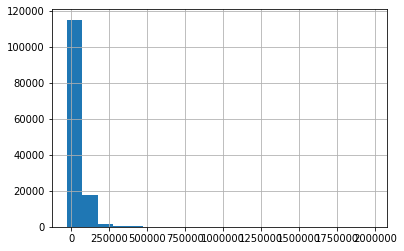

In [385]:
rented_clean=c.clean_income(rented)
rented_clean.loc[rented_clean['year']>=1997]['ZINC2'].hist(bins=20)

In [386]:
np.sort(rented_clean.loc[rented_clean['year']>=1997]['ZINC2'].unique())

array([ -28316,  -13488,  -10000, ..., 1568552, 1918768, 1976174])

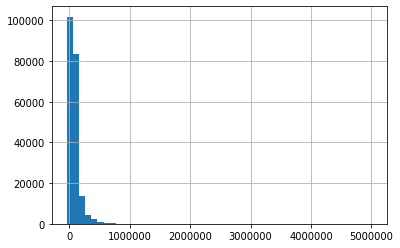

In [387]:
owned_clean=c.clean_income(owned)
owned_clean.loc[owned_clean['year']>=1997]['ZINC2'].hist(bins=50)

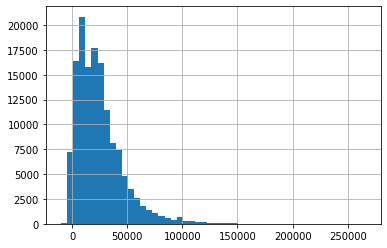

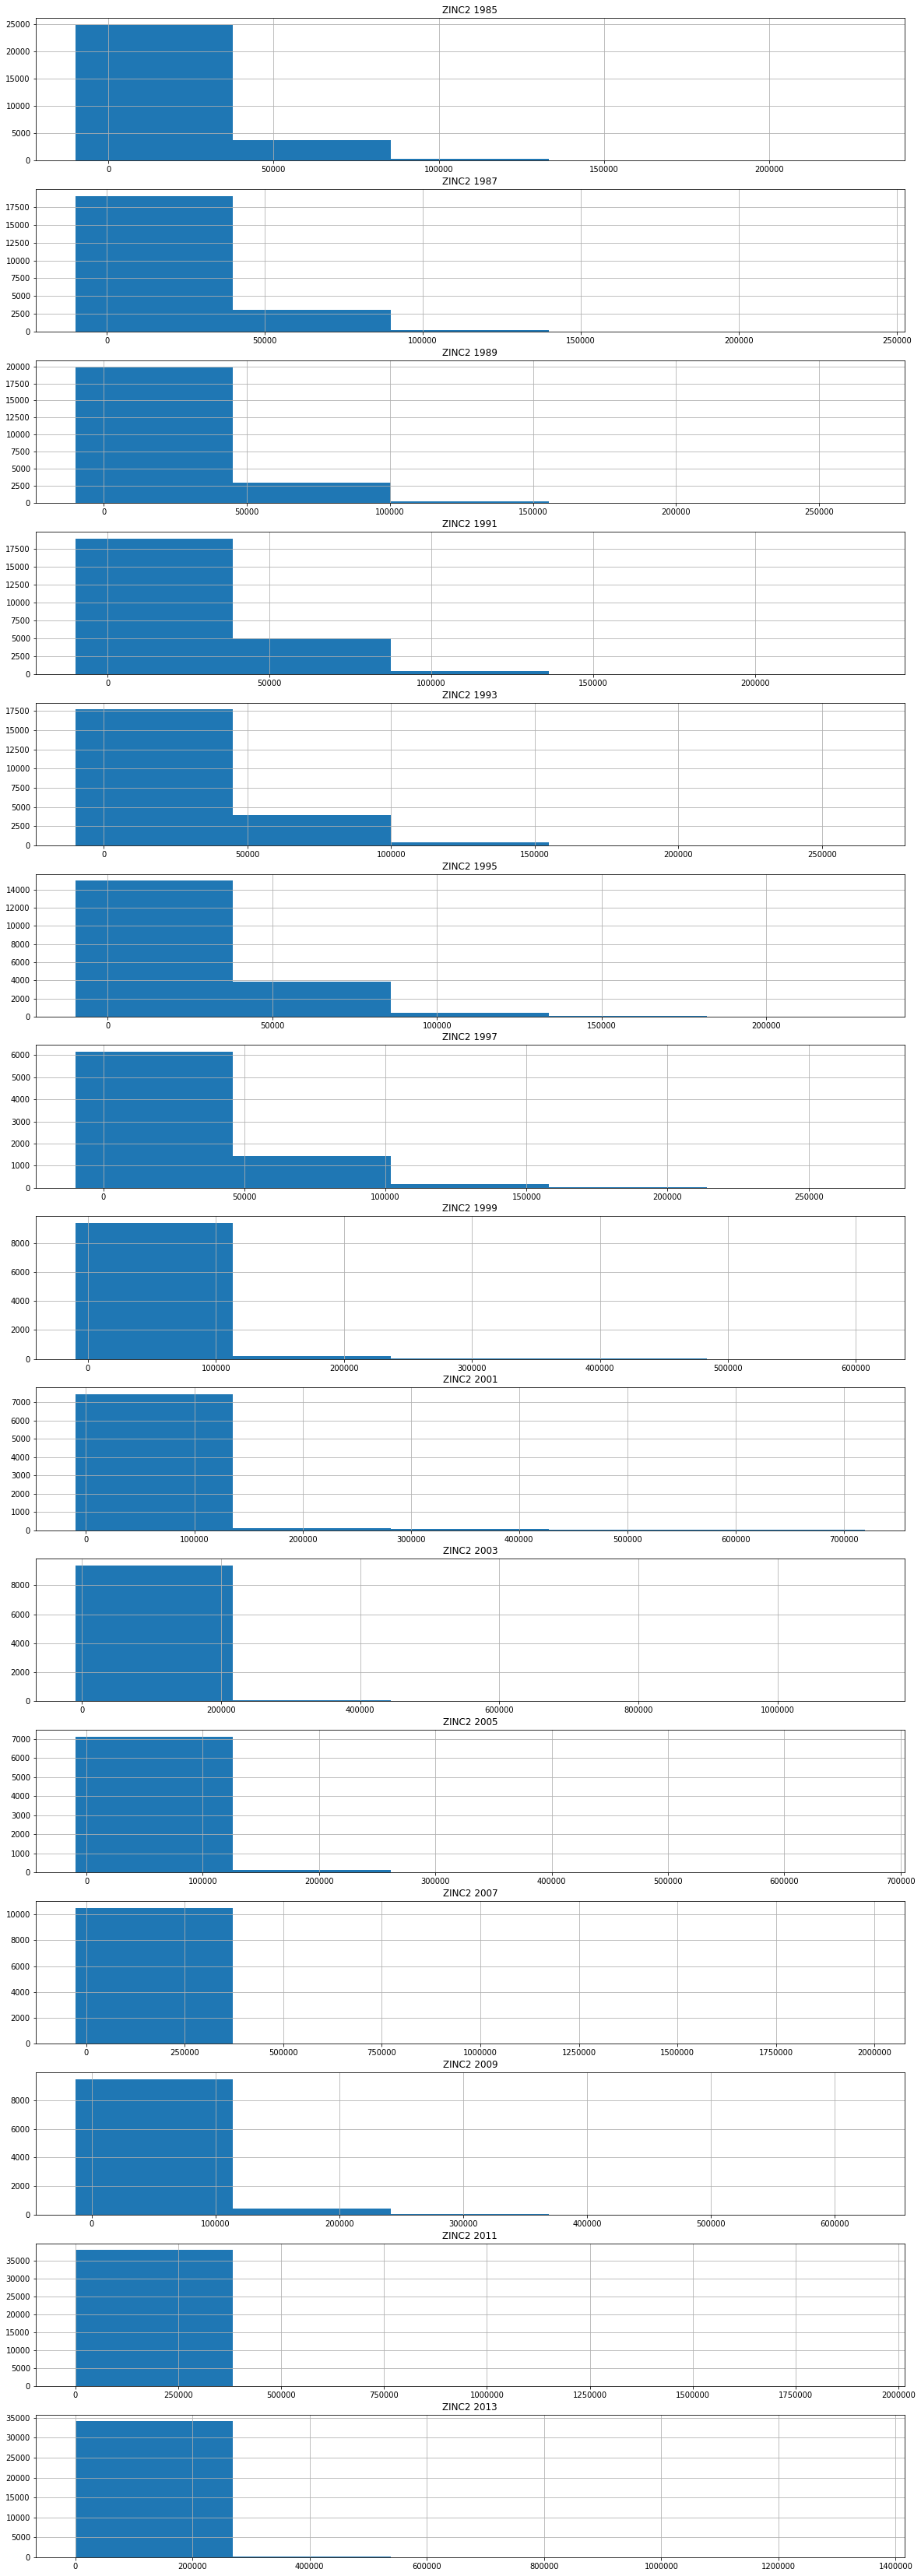

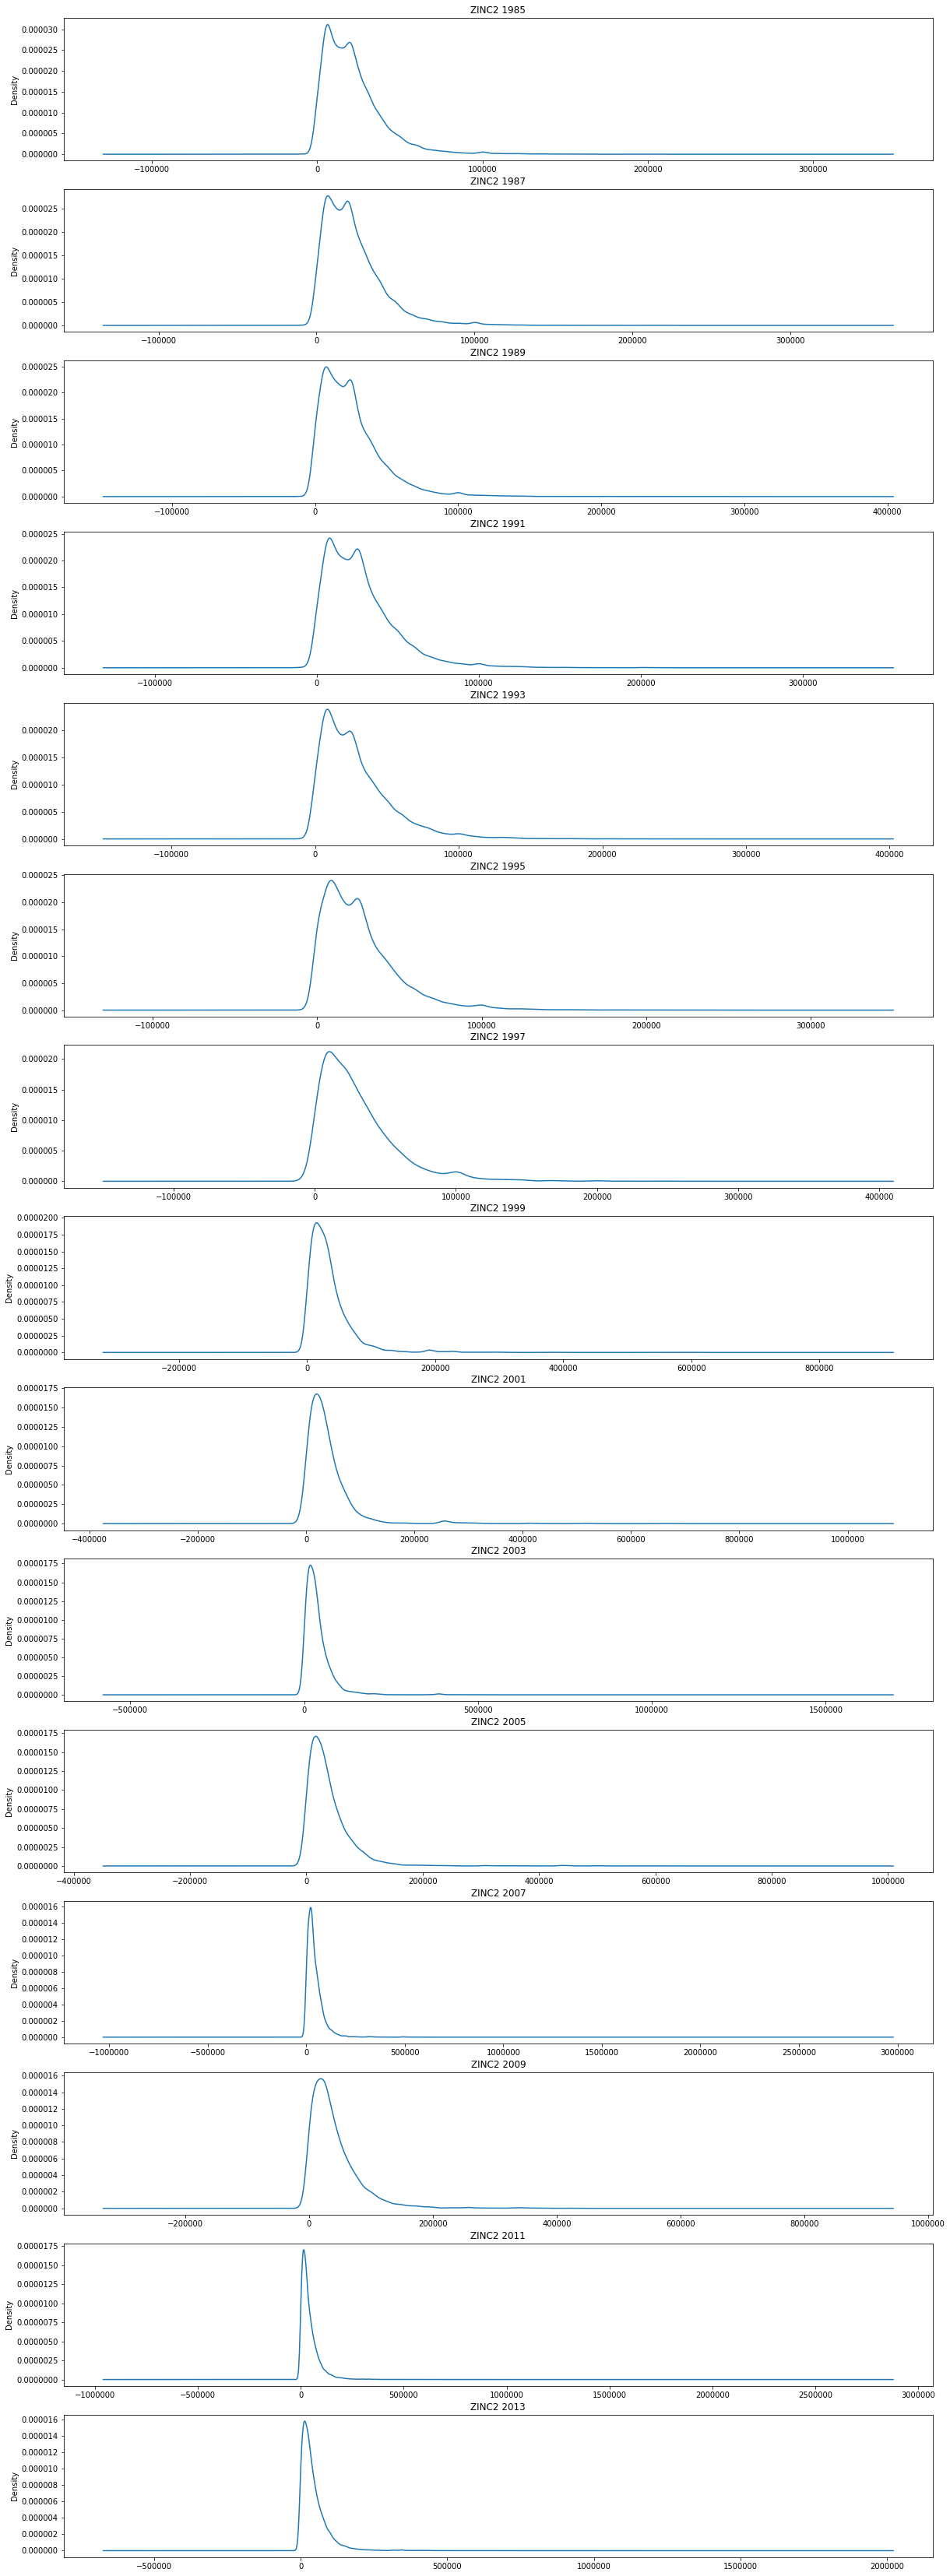

In [388]:
rented_clean.loc[rented['year'] < 1997]['ZINC2'].hist(bins = 50)
c.get_hist(rented_clean, 'ZINC2', 15,'ZINC2')

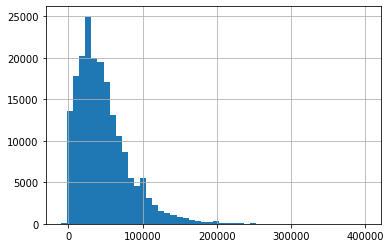

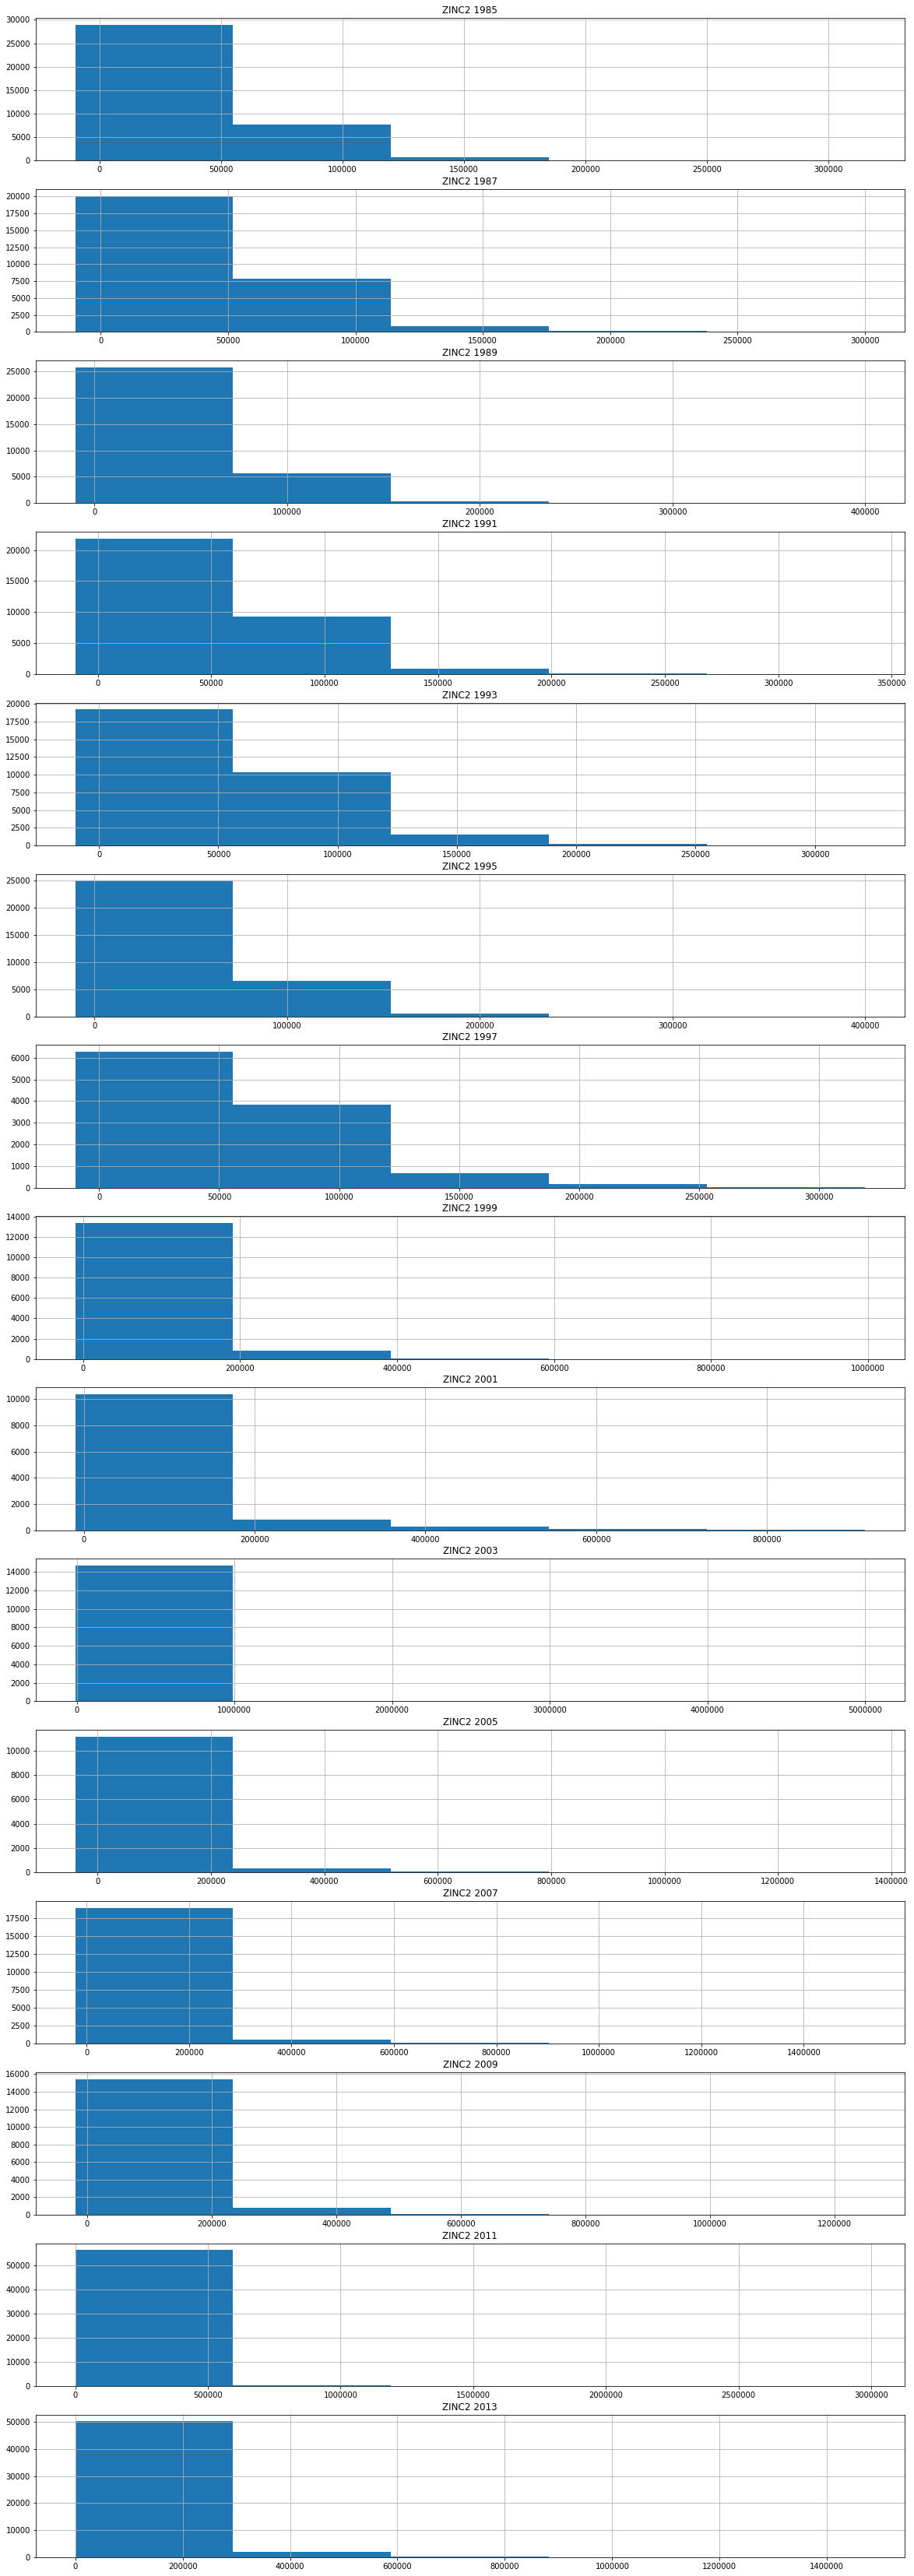

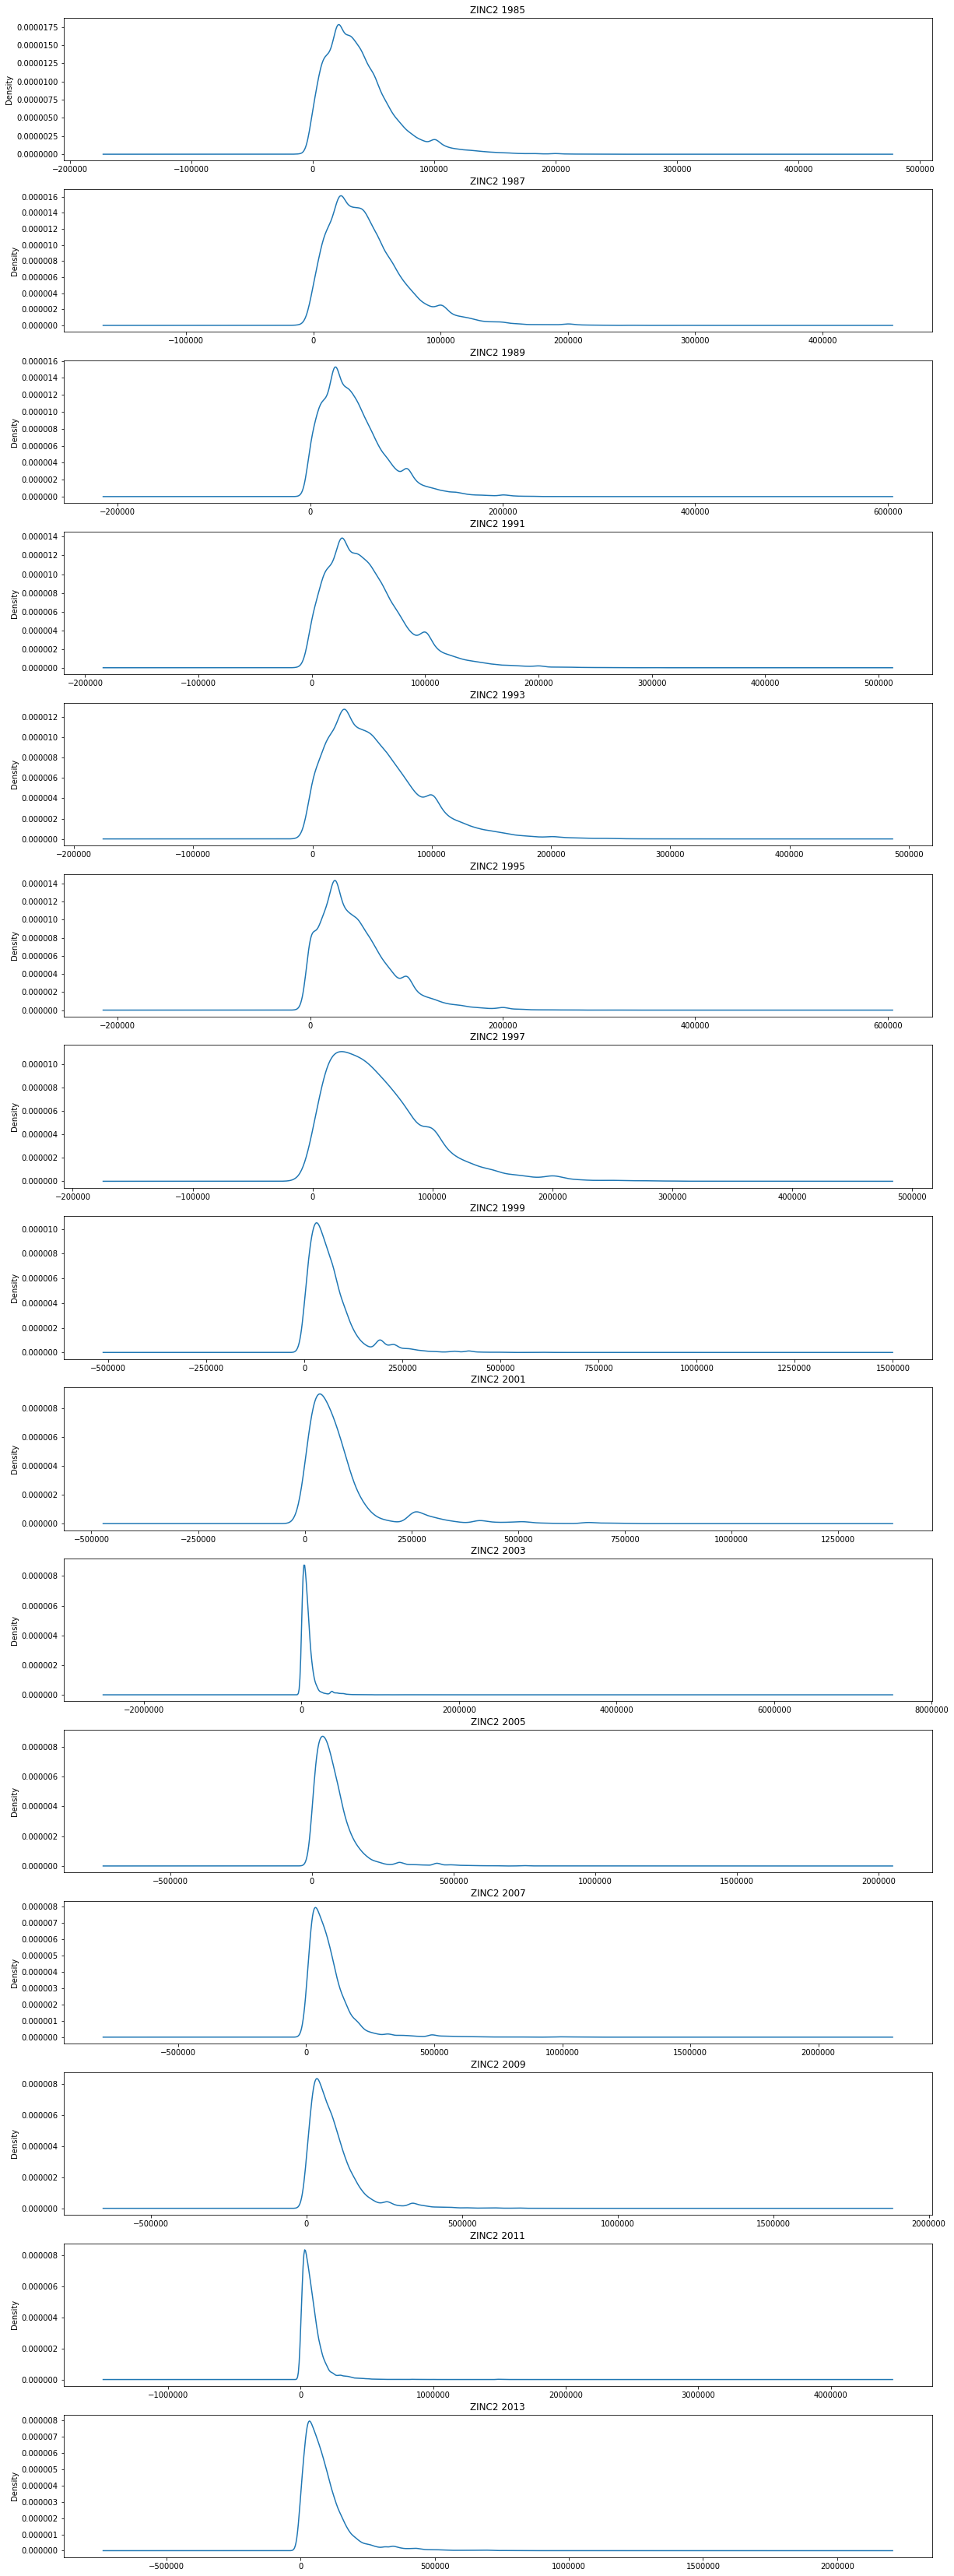

In [389]:
owned_clean.loc[owned_clean['year'] < 1997]['ZINC2'].hist(bins = 50)
c.get_hist(owned_clean, 'ZINC2', 15,'ZINC2')

### Check distribution of income to value ratio for both rented owned and rented homes

For rented homes only, value variable only has value -6 (not applicable), -9 (not reported), and 999999 (not applicable). This makes sense as value should be missing for rented homes.

In [390]:
rented_clean['VALUE'].unique()

array([    -9, 999999,     -6])

### For all owned homes, VALUEs are all positive

In [391]:
np.sort(owned_clean['VALUE'].unique())

array([     -9,       0,       1, ..., 4414135, 5220000, 5264699])

### For owned homes, income can be negative

In [392]:
np.sort(owned_clean['ZINC2'].unique())

array([ -39716,  -22117,  -20308, ..., 3538400, 3598400, 5000000])

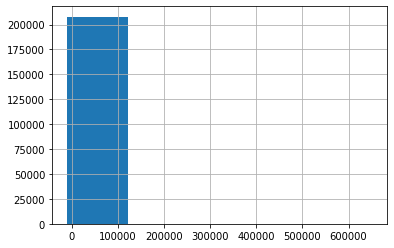

In [393]:
owned_clean.loc[owned_clean['year']>=1997]['Income to Value Ratio'].hist(bins=5)

In [394]:
owned_clean=owned_clean.loc[~(owned_clean['Income to Value Ratio'].isin([np.inf,-np.inf]))]

In [395]:
np.sort(owned_clean['Income to Value Ratio'].unique())

array([-1.00000e+04, -7.80000e+01, -5.70000e+01, ...,  6.26662e+05,
        6.50088e+05,          nan])

YR: before 1997, income to value ratio contains infnity and negative infinity. This migh indicates some zeros in house value. We need to be get rid of those zero values.

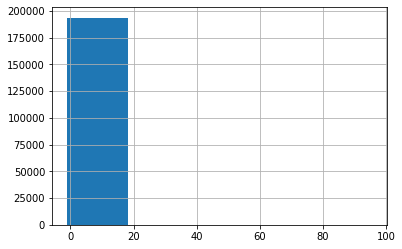

In [396]:
owned_clean.loc[owned_clean['year']<1997]['Income to Value Ratio'].hist(bins=5)

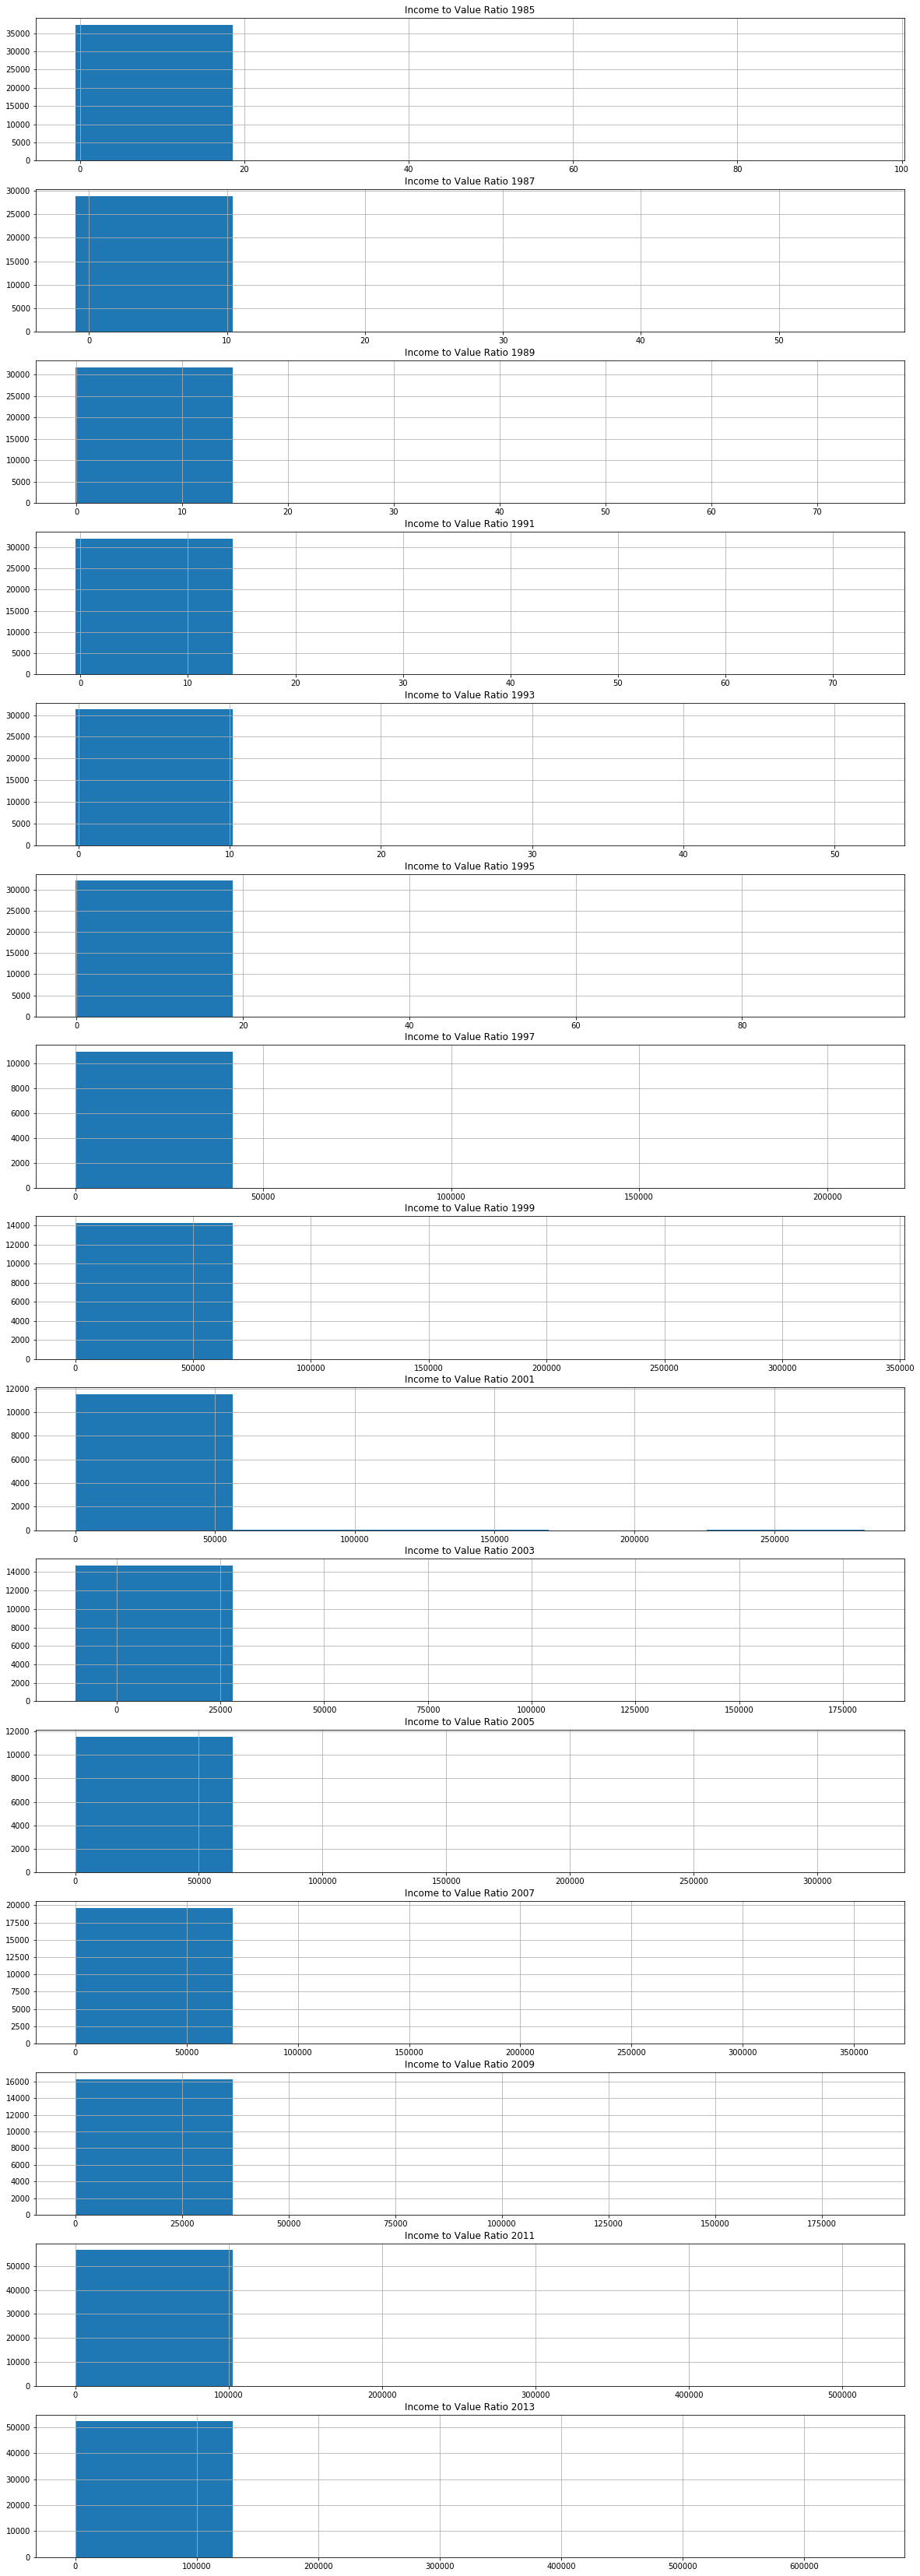

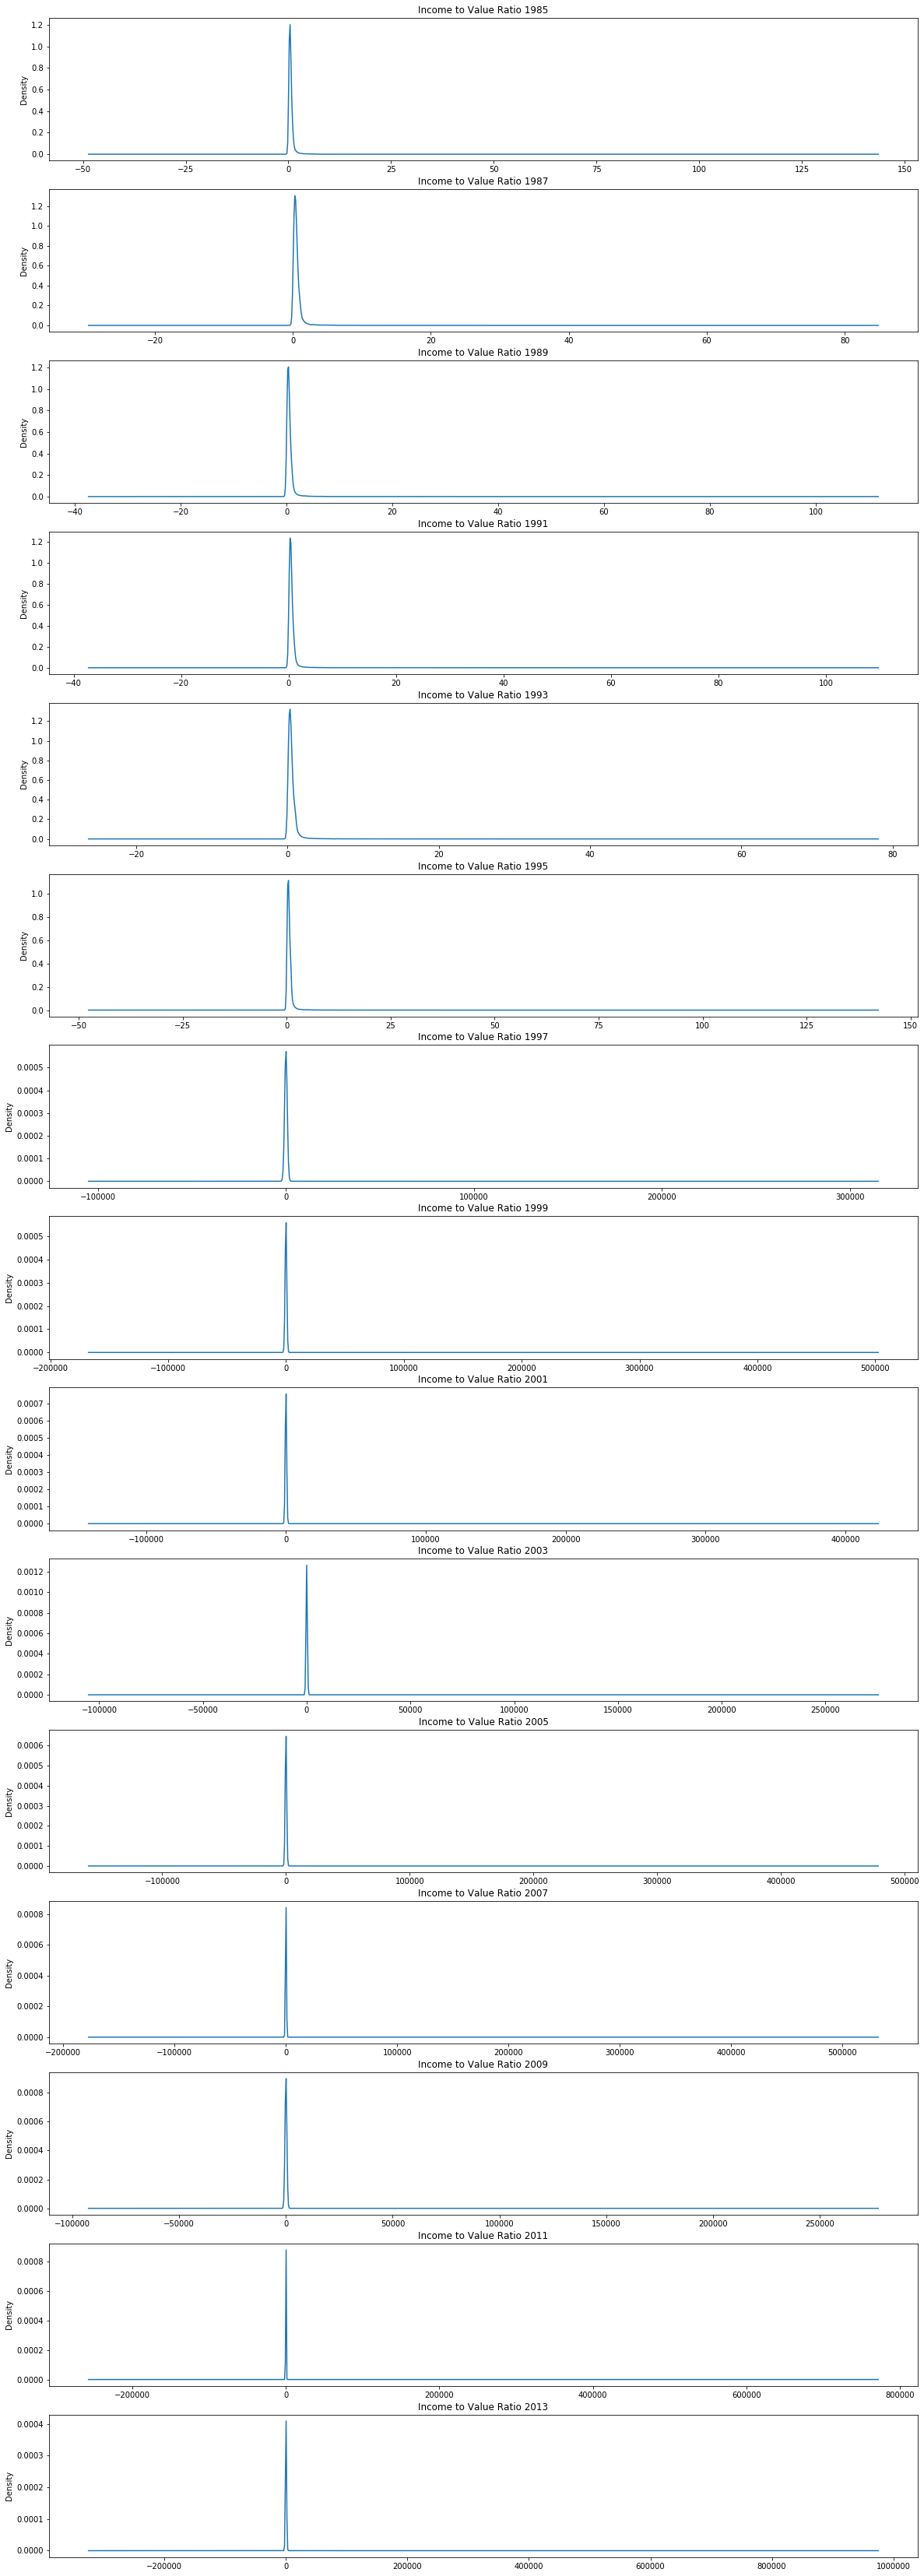

In [397]:
c.get_hist(owned_clean, 'Income to Value Ratio', 15,'Income to Value Ratio2')

### Check distribution of income to rent ratio for both rented owned and rented homes

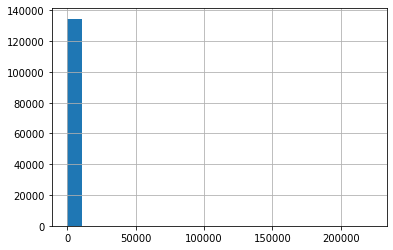

In [398]:
rented_clean.loc[rented_clean['year']>=1997]['Income to Rent Ratio'].hist(bins=20)

In [399]:
np.sort(rented_clean.loc[rented_clean['year']>=1997]['Income to Rent Ratio'].unique())

array([-7.20000e+01, -5.20000e+01, -4.30000e+01, ...,  1.75000e+05,
        1.83000e+05,  2.22592e+05])

In [400]:
np.sort(rented_clean.loc[rented_clean['year']>=1997]['ZINC2'].unique())

array([ -28316,  -13488,  -10000, ..., 1568552, 1918768, 1976174])

In [401]:
np.sort(rented_clean.loc[rented_clean['year']>=1997]['RENT'].unique())

array([    1,     2,     3, ...,  8972,  9938, 12361])

In [402]:
np.sort(rented_clean.loc[rented_clean['year']<1997]['ZINC2'].unique())

array([-10001, -10000,  -9900, ..., 240000, 265000, 266000])

In [403]:
np.sort(rented_clean.loc[rented_clean['year']<1997]['RENT'].unique())

array([  -9,    0,    1, ..., 1430, 1450, 1475])

In [404]:
np.sort(owned_clean['RENT'].unique())

array([  -9,   -6,  999, 9999])

For owned homes, rent value equal to -9, -6, 999, 9999

### clean the rent variable and calculate log rents

For 1997-2017:
0: Vacant or URE unit where rent will depend on the occupant's income
1 : 99998: $1 to $99,998
99999: $99,999 or more
N or -6 (2015 and later) | B or -6 (2013 and earlier): Not applicable

We remove -6,0 and 99999 response codes

p. 147 codebook
For 1985-1995:
9999: not applicable
0, 999: No cash rent 
1: Vacant and rent depends on income of oc

We remove 1,0 and 9999, -6, 99999 response codes



There were many values below zero even though it was noted in the codebook. I choose to remove negative rents.

<b>cleaned data output<b>

the percentage of the data removed
10.0


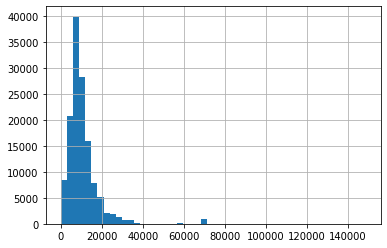

In [405]:
rent = c.clean_rent(rented)
print("the percentage of the data removed")
print(round(1.0 - len(rent )/ len(rented),2)*100.0)
rent.loc[rent['year'] >= 1997]['RENT'].hist(bins = 50)

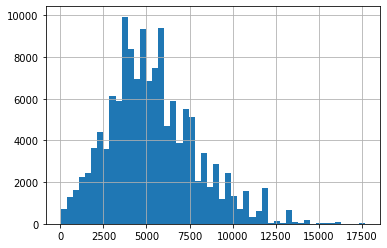

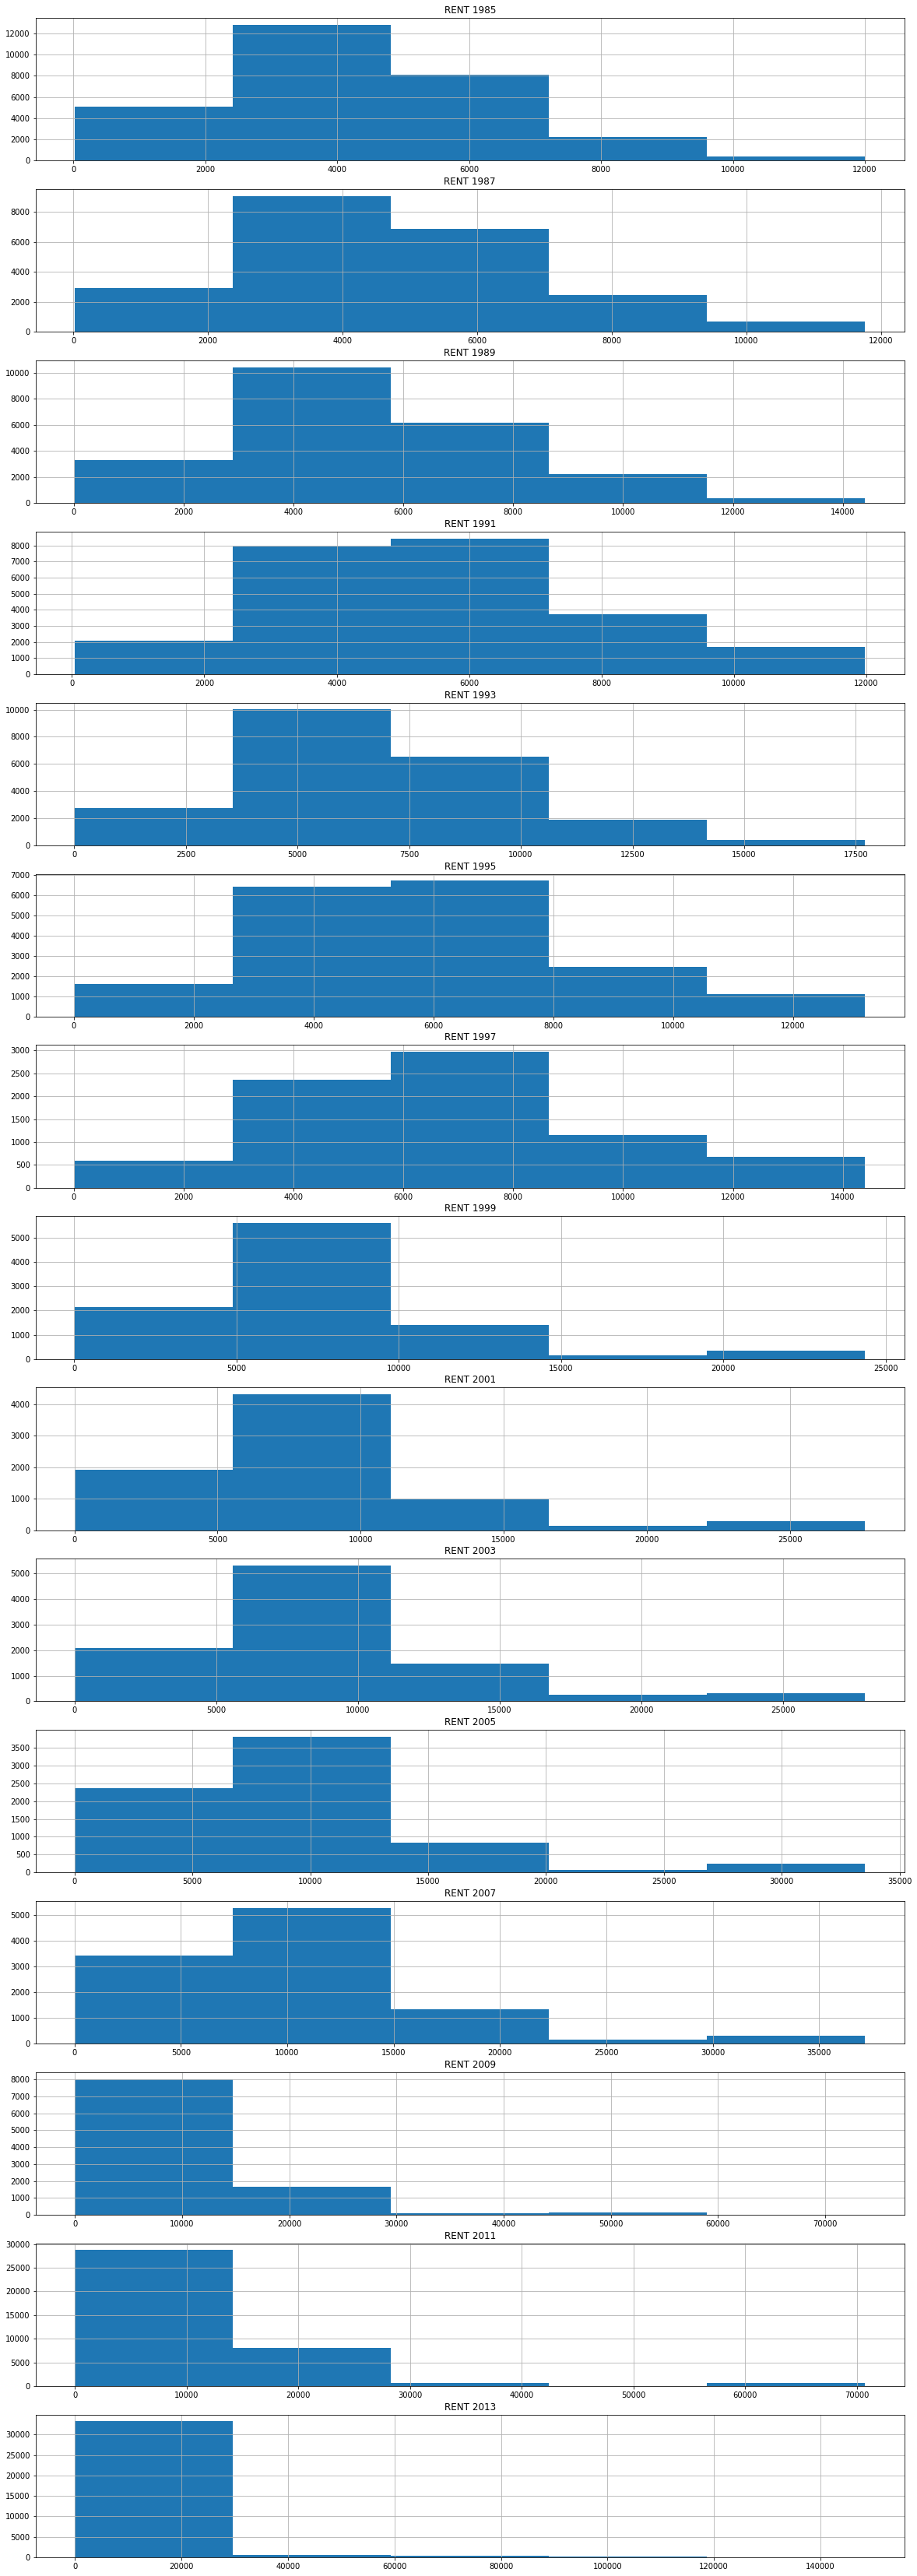

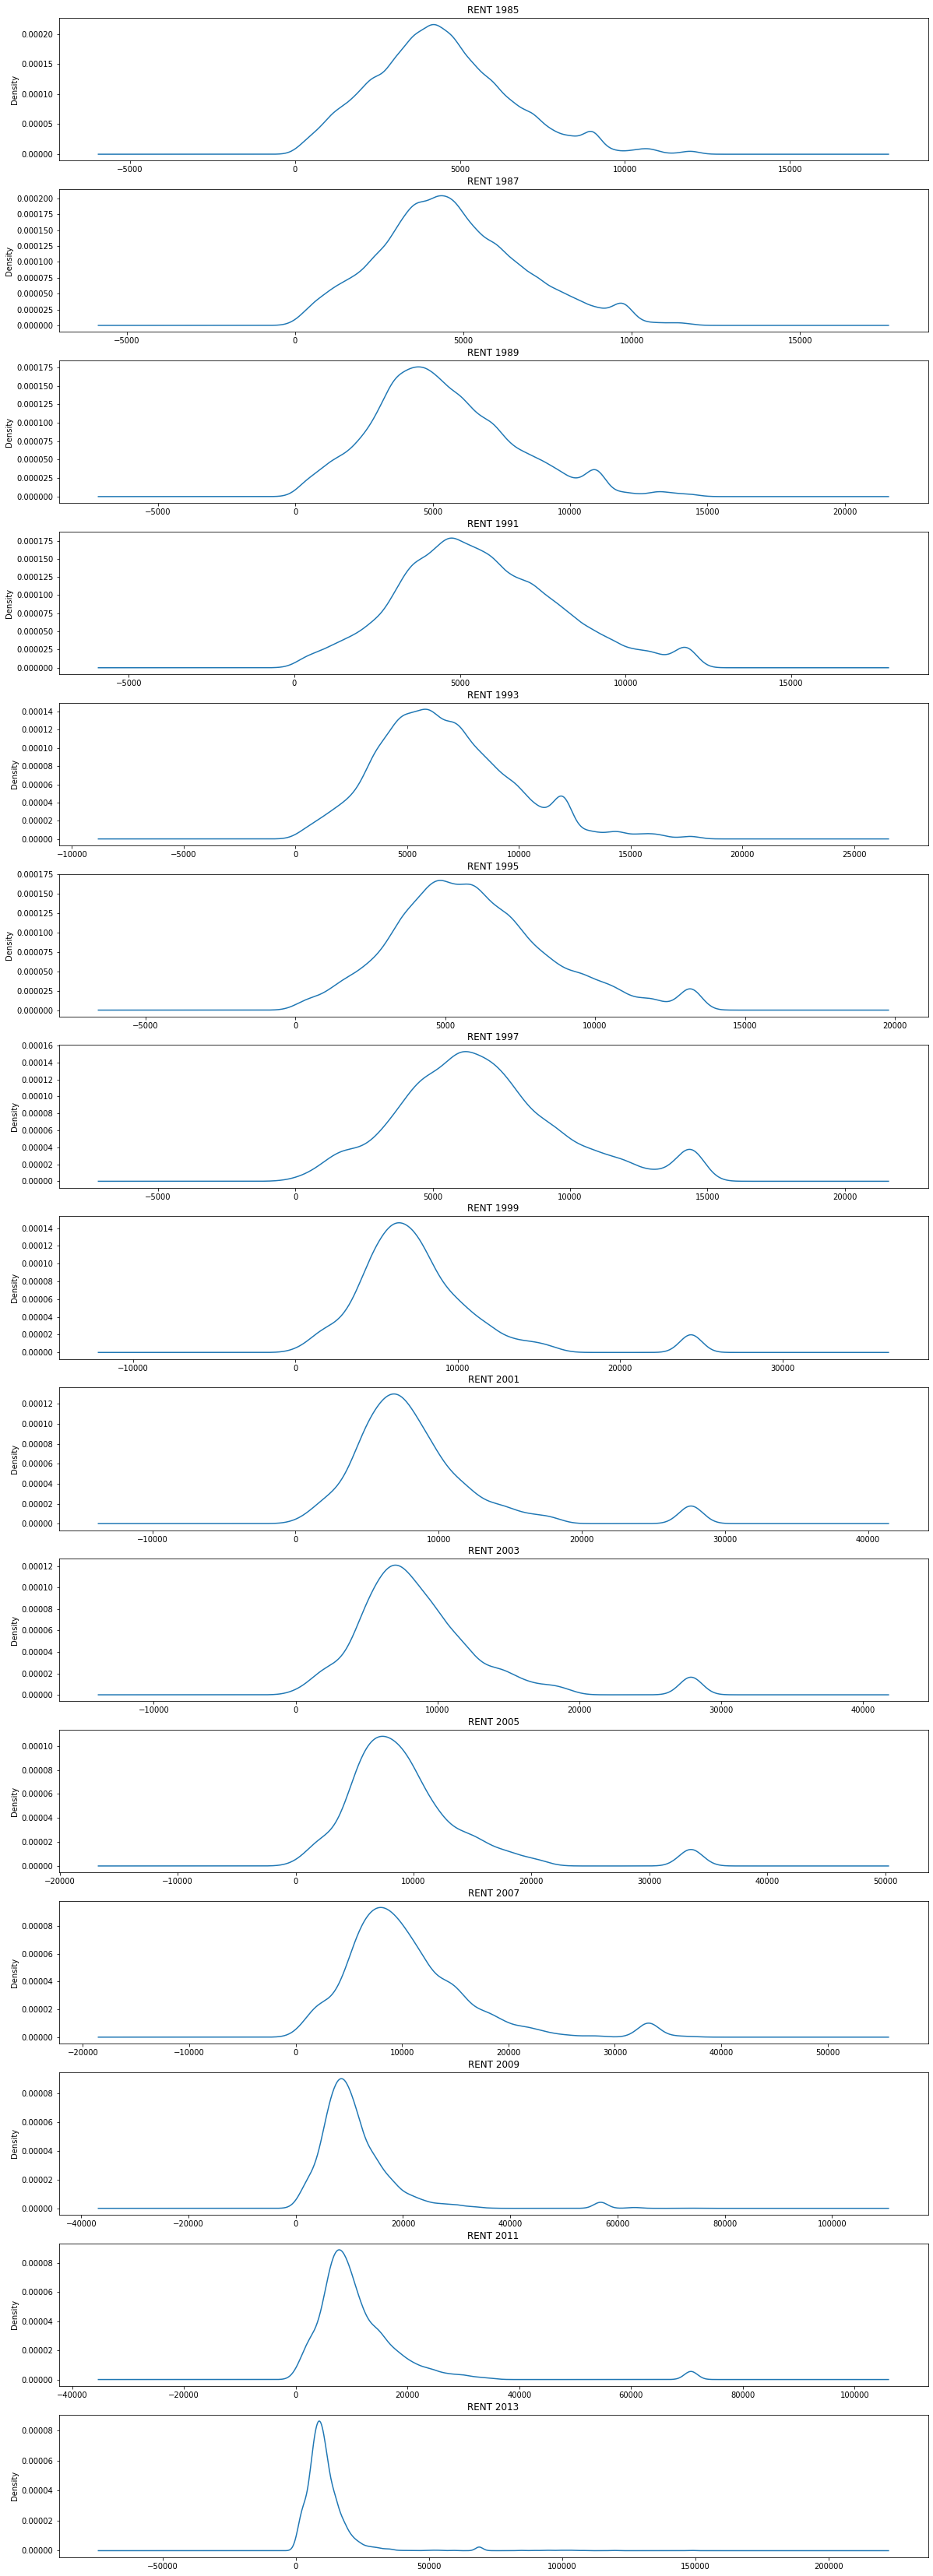

In [406]:
rent.loc[rent['year'] < 1997]['RENT'].hist(bins = 50)
c.get_hist(rent, 'RENT', 15,'RENT')

If the rent field is top coded at 99,998 for years greater than 1997, why do we see data greater than that? Should we top code the data before that for that. 

### clean the data for ratios

Delete if the ratio of household income to house value is greater than 2 (This identifiesdata errors in the house value field)

Delete if the ratio of household income to annual rent is greater than 100 (This identifiesdata errors in the annual rent field)

Output the dataframe after cleaning to show that the proper datapoints were filtered out

<b> cleaned data output<b>

In [407]:
ratios = c.clean_ratios(all_data)
print("the percentage of the data removed")
print(round(1.0 - len(ratios)/ len(all_data),2)*100.0)
print(ratios.loc[ratios['Income to Rent Ratio']>100.])
print(ratios.loc[ratios['Income to Value Ratio']>2.])

the percentage of the data removed
12.0
Empty DataFrame
Columns: [year, RENT, ZINC2, EBAR, RCNTRL, VALUE, NUNIT2, CONDO, TENURE, SMSA, ROOMS, BATHS, AIRSYS, TYPE, BUILT, BEDRMS, WEIGHT, VACANCY, Income to Value Ratio, Income to Rent Ratio]
Index: []
Empty DataFrame
Columns: [year, RENT, ZINC2, EBAR, RCNTRL, VALUE, NUNIT2, CONDO, TENURE, SMSA, ROOMS, BATHS, AIRSYS, TYPE, BUILT, BEDRMS, WEIGHT, VACANCY, Income to Value Ratio, Income to Rent Ratio]
Index: []


### clean data for type and create binary variable for attached or detached

In [408]:
unit_type = c.get_distribution(all_data, 'TYPE','TYPE',1, title = 'All Data' + 'Type')
print(unit_type)

print("owned")
owned_unit_type = c.get_distribution(owned, 'TYPE','TYPE',1, title = 'All Data' + 'Type')
print(owned_unit_type)

print("rented")
rented_unit_type = c.get_distribution(rented, 'TYPE','TYPE',1, title = 'All Data' + 'Type')
print(rented_unit_type)


        1985     1987     1989     1991     1993     1995     1997     1999  \
-9     371.0    255.0    544.0    507.0    710.0    950.0      NaN      NaN   
-6       NaN      NaN      NaN      NaN      NaN      NaN   2029.0   2669.0   
 1   75726.0  58882.0  62917.0  64976.0  60793.0  58783.0  23717.0  29994.0   
 2    1287.0    921.0   1218.0    854.0    998.0   1009.0    353.0    375.0   
 3     275.0    126.0    262.0    134.0    261.0    183.0     66.0     73.0   
 4      94.0     49.0     79.0     58.0     82.0     35.0     20.0     19.0   
 5      58.0     41.0     56.0     38.0     63.0     26.0     16.0     18.0   
 6      87.0     97.0     71.0     98.0     85.0     54.0     44.0     41.0   
 7      22.0      7.0     22.0      4.0      4.0     11.0      2.0      7.0   
 8       1.0      1.0      1.0      NaN      NaN      2.0      NaN      NaN   
 9      28.0     27.0     25.0     32.0     28.0     24.0    111.0    215.0   
 10      6.0     11.0     15.0     56.0     52.0    

For 2015-2017 the ahs code is BLD
01: Mobile home or trailer
02: One-family house, detached
03: One-family house, attached
04: 2 Apartments
05: 3-4 Apartments
06: 5-9 Apartments
07: 10-19 Apartments
08: 20-49 Apartments
09: 50 or more apartments
10: Boat, RV, van, etc.

For 1997-2013 the ahs code is NUNIT2
1: One-unit building, detached from any other building
2: One-unit building, attached to one or more buildings
3: Building with two or more apartments
4: Manufactured (mobile) home
B or -6: Not applicable

For 1985-1995 the ahs code is NUNIT2. pg. 133 of pdf 
1: Mobile Home--No Permanent Room
2: Detached
3: Attached
04: 2 Apartments
05: 3-4 Apartments
06: 5-9 Apartments
07: 10-19 Apartments
08: 20-49 Apartments
09: 50 or more apartments
101: 101 apartments or more
99 or 999: not applicable

top codes are 97th percentile

<b> Question <b>. detached, attached, condo, or apartment is noted in the appendix as the unit type fixed effect. On p.11 of the paper it is just a dummy variable for attached or detached. We will follow this methodolgy.I have condo codes as well. We will keep codes 2 and 3 for 2015,2017. 1 and 3 for 1997-2013. 2 and 3 for 1985-1995. We will make it a binary variable with 1 meaning detached. I don't think this correct. I think I should add apartments to attached homes

In [409]:
unit_type = c.clean_type(all_data)
owned_unit_type = c.clean_type(owned)
rented_unit_type = c.clean_type(rented)
print("the percentage of the data removed")
print(round(1.0 - len(unit_type)/ len(all_data),2)*100.0)
unit_type = c.get_distribution(unit_type, 'Unit Type','Unit Type',1, title = 'All Data' + 'Type')
print(unit_type)


print("owned")
owned_unit_type = c.get_distribution(owned_unit_type, 'TYPE','TYPE',1, title = 'All Data' + 'Type')
print(owned_unit_type)

print("rented")
rented_unit_type = c.get_distribution(rented_unit_type, 'TYPE','TYPE',1, title = 'All Data' + 'Type')
print(rented_unit_type)


the percentage of the data removed
8.0
      1985   1987   1989   1991   1993   1995   1997   1999   2001   2003  \
1.0  75726  58882  62917  64976  60793  58783  23717  29994  23988  30297   
0.0   1287    921   1218    854    998   1009    353    375    311    373   

      2005   2007   2009    2011    2013  
1.0  24587  40307  35244  121973  113052  
0.0    249    628    485    2674    2816  
owned
    1985   1987   1989   1991   1993   1995   1997   1999   2001   2003  \
1  37517  29159  31903  32635  31525  32350  12427  16188  13067  16540   
2    911    701    857    599    714    714    245    263    217    260   

    2005   2007   2009   2011   2013  
1  13417  22641  18824  65192  60588  
2    175    403    313   1809   1757  
rented
    1985   1987   1989   1991   1993   1995  1997   1999  2001   2003  2005  \
1  30444  23255  23957  25136  22775  19619  8635  10832  8529  10393  8225   
2    177    113    145    120    103    130    46     43    44     48    35   

    20

### clean the data for airsys

In [410]:
airsys = c.get_distribution(all_data, 'AIRSYS','AIRSYS',1, title = 'All Data' + 'AIRSYS')
print(airsys)

print("owned")
owned_airsys = c.get_distribution(owned, 'AIRSYS','AIRSYS',1, title = 'All Data' + 'AIRSYS')
print(owned_airsys)

print("rented")
rented_airsys = c.get_distribution(rented, 'AIRSYS','AIRSYS',1, title = 'All Data' + 'AIRSYS')
print(rented_airsys)

         1985     1987     1989     1991     1993     1995     1997     1999  \
-9.0   2261.0   1787.0   2689.0   2468.0   2908.0   4459.0      NaN      NaN   
-6.0      NaN      NaN      NaN      NaN      NaN      NaN   5383.0   6977.0   
 1.0  27774.0  20750.0  27704.0  25743.0  24496.0  28524.0  10254.0  13168.0   
 2.0  44956.0  35805.0  32825.0  36044.0  33710.0  26576.0  10954.0  13544.0   
 9.0   6368.0   4167.0   7911.0   7901.0   6246.0   2730.0      NaN      NaN   

         2001     2003     2005     2007     2009     2011     2013  
-9.0      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
-6.0   5954.0   7082.0   7004.0  11034.0  13622.0  22100.0  20088.0  
 1.0  11425.0  14621.0  12534.0  23797.0  18146.0  71957.0  70111.0  
 2.0   9992.0  12760.0   9151.0  11546.0  12667.0  37165.0  30570.0  
 9.0      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
owned
         1985     1987     1989     1991     1993     1995    1997    1999  \
-9.0    742.0  

For 1997-2013:
1: Yes
2: No
B or -6: Not applicable
For 2015-2017:
01: Electric powered central air conditioning system
02: Piped gas powered central air conditioning system
03: LP gas powered central air conditioning system
04: Other fuel source powered air conditioning system
05: 1 room air conditioner
06: 2 room air conditioners
07: 3 room air conditioners
08: 4 room air conditioners
09: 5 room air conditioners
10: 6 room air conditioners
11: 7 or more room air conditioners
12: No air conditioning


For 1985-1995:
1: Yes
2: No


We will create a binary variable for whether the data has airconditioning or not. 1 for, 0 for not
We will remove -6 not applicable for 1997-2013
We will remove -9,9 not applicable for 1985-1995

<b> cleaned data output<b>

In [411]:
AIRSYS = c.clean_airsys(all_data)
owned_airsys = c.clean_airsys(owned)
rented_airsys = c.clean_airsys(rented)
print("the percentage of the data removed")
print(round(1.0 - len(AIRSYS)/ len(all_data),2)*100.0)
AIRSYS = c.get_distribution(AIRSYS, 'AIRSYS','AIRSYS',1, title = 'All Data' + 'AIRSYS')
print(AIRSYS)

print("owned")
owned_airsys = c.get_distribution(owned_airsys, 'AIRSYS','AIRSYS',1, title = 'All Data' + 'AIRSYS')
print(owned_airsys)

print("rented")
rented_airsys = c.get_distribution(rented_airsys, 'AIRSYS','AIRSYS',1, title = 'All Data' + 'AIRSYS')
print(rented_airsys)



the percentage of the data removed
17.0
      1985   1987   1989   1991   1993   1995   1997   1999   2001   2003  \
0.0  44956  35805  32825  36044  33710  26576  10954  13544   9992  12760   
1.0  27774  20750  27704  25743  24496  28524  10254  13168  11425  14621   

      2005   2007   2009   2011   2013  
0.0   9151  11546  12667  37165  30570  
1.0  12534  23797  18146  71957  70111  
owned
      1985   1987   1989   1991   1993   1995  1997  1999  2001  2003  2005  \
0.0  21132  16350  15108  15985  15110  12463  4616  5645  4190  5176  3653   
1.0  15595  12166  16061  15549  15419  18019  6334  8616  7330  9552  7916   

      2007   2009   2011   2013  
0.0   4667   5026  13595  11877  
1.0  14964  11285  43015  40471  
rented
      1985   1987   1989   1991   1993   1995  1997  1999  2001  2003  2005  \
0.0  19658  15853  14170  16188  14913  10765  4885  6226  4579  5788  4119   
1.0   8943   6227   8347   7780   6717   7583  2880  3428  3048  3656  3202   

     2007  200

### filter data for top 30 cities

In [412]:
cities = c.get_distribution(all_data, 'SMSA','SMSA',1, title = 'All Data' + 'SMSA')
print(cities)

print("owned")
owned_cities = c.get_distribution(owned, 'SMSA','SMSA',1, title = 'All Data' + 'SMSA')
print(owned_cities)

print("rented")
rented_cities = c.get_distribution(rented, 'SMSA','SMSA',1, title = 'All Data' + 'SMSA')
print(rented_cities)

         1985   1987   1989   1991   1993  1995  1997  1999  2001  2003  2005  \
160.0   130.0  112.0  146.0  117.0  148.0   123   122   122   122   123   127   
200.0    92.0   76.0   99.0   79.0  111.0    85    93   100   102   106   115   
240.0    98.0   81.0  103.0   83.0  104.0    88    85    85    85    85    89   
275.0    15.0   15.0   15.0   15.0   15.0    18    16    16    16    16    16   
360.0   457.0  387.0  496.0  419.0  552.0   429   431   433   433   433   448   
...       ...    ...    ...    ...    ...   ...   ...   ...   ...   ...   ...   
9240.0   65.0   47.0   76.0   48.0   76.0    53    53    53    53    54    55   
9320.0   90.0   67.0   87.0   65.0  113.0    64    71    71    71    71    72   
9991.0    NaN    NaN    NaN    NaN    NaN   203   129   295   205   372   262   
9992.0    NaN    NaN    NaN    NaN    NaN   104   132   144   151   165   175   
9993.0    NaN    NaN    NaN    NaN    NaN   209   266   287   307   325   362   

        2007  2009  2011  2

In [413]:
cities = c.clean_cities(all_data)
owned_cities = c.clean_cities(owned)
rented_cities = c.clean_cities(rented)

cities = c.get_distribution(cities, 'SMSA','SMSA',1, title = 'All Data' + 'SMSA')
print(cities)

print("owned")
owned_cities = c.get_distribution(owned_cities, 'SMSA','SMSA',1, title = 'All Data' + 'SMSA')
print(owned_cities)

print("rented")
rented_cities = c.get_distribution(rented_cities, 'SMSA','SMSA',1, title = 'All Data' + 'SMSA')
print(rented_cities)

        1985  1987  1989  1991  1993  1995  1997  1999  2001  2003  2005  \
360.0    457   387   496   419   552   429   431   433   433   433   448   
520.0    478  3906   492  4954   531   442   365   452   460   470   482   
720.0    407  3657   428  4781   482   392   391   393   394   394   402   
1120.0  4604   509  4680   521  5943   536   545   546   550   550   555   
1600.0  1322  4518  1442  5538  1469  2782  1254  2846  1268  2863  1297   
1680.0   378   318   373   325   417   330   345   345   345   345   351   
1920.0  3737   421  4326   427   539   447   468   478   485   496   521   
2160.0  7379   691  4719   713  6198  2029   927  2132   972  2186  1031   
3360.0   632  3611   622  4165   715   545   582   589   598   608   631   
3760.0   280   243   286   248   328  4488   266   270   276   280   290   
4480.0  8305  1470  5632  1518  1996  3612  1608  3705  1621  3717  1657   
5000.0   419   358   436   379   518  4668   409   412   415   420   430   
5120.0  4196

In [414]:
cities = c.clean_cities(all_data)
owned_cities = c.clean_cities(owned)
rented_cities = c.clean_cities(rented)

cities = c.get_distribution(cities, 'CITY','CITY',1, title = 'All Data' + 'CITY')
print(cities)

print("owned")
owned_cities = c.get_distribution(owned_cities, 'CITY','CITY',1, title = 'All Data' + 'CITY')
print(owned_cities)

print("rented")
rented_cities = c.get_distribution(rented_cities, 'CITY','CITY',1, title = 'All Data' + 'CITY')
print(rented_cities)

                1985  1987  1989  1991  1993  1995  1997  1999  2001  2003  \
Anaheim          457   387   496   419   552   429   431   433   433   433   
Atlanta          478  3906   492  4954   531   442   365   452   460   470   
Baltimore        407  3657   428  4781   482   392   391   393   394   394   
Boston          4604   509  4680   521  5943   536   545   546   550   550   
Chicago         1322  4518  1442  5538  1469  2782  1254  2846  1268  2863   
Cleveland        378   318   373   325   417   330   345   345   345   345   
Dallas          3737   421  4326   427   539   447   468   478   485   496   
Detroit         7379   691  4719   713  6198  2029   927  2132   972  2186   
Houston          632  3611   622  4165   715   545   582   589   598   608   
Kansas City      280   243   286   248   328  4488   266   270   276   280   
Los Angeles     8305  1470  5632  1518  1996  3612  1608  3705  1621  3717   
Miami            419   358   436   379   518  4668   409   412  

In [415]:
def print_cleaning_stats(hedonic_model_data, before):
    original_owned_data = before[before['VALUE'] > 0]
    original_rental_data = before[before['log rent'] > 0.0]

    owned_data = hedonic_model_data[hedonic_model_data['VALUE'] > 0]
    rental_data = hedonic_model_data[hedonic_model_data['log rent'] > 0.0]
    
    print("The percentage of owned homes cleaned")
    print((1.0 - len(owned_data)/len(original_owned_data))*100.0)
    print("The percentage of rental homes cleaned")
    print((1.0 - len(rental_data) / len(original_rental_data))*100.0)

## Actually clean the data sequentially for hedonic model

clean the rental and owned data

In [416]:
print(rented['year'].unique())

[1985 1987 1989 1991 1993 1995 1997 1999 2001 2003 2005 2007 2009 2011
 2013]


In [417]:

#we do not need to clean for tenure since the data is separated by tenure

rented = c.clean_bdrms(rented)
owned = c.clean_bdrms(owned)
print(rented['year'].unique())

rented = c.clean_rooms(rented)
owned = c.clean_rooms(owned)
print(rented['year'].unique())

#owned homes do not need to be cleaned for rent control
rented = c.clean_rcntrl(rented)
print(rented['year'].unique())

rented = c.clean_cities(rented)
print(rented['year'].unique())
owned = c.clean_cities(owned)

rented = c.clean_airsys(rented)
print(rented['year'].unique())
owned = c.clean_airsys(owned)

#we do not need to clean owned homes for rent
rented = c.clean_rent(rented)
print(rented['year'].unique())

rented = c.clean_ratios(rented)
print(rented['year'].unique())
owned = c.clean_ratios(owned)

rented = c.clean_type(rented)
print(rented['year'].unique())
owned = c.clean_type(owned)
rented = c.clean_ebar(rented)
print(rented['year'].unique())
owned = c.clean_ebar(owned)

#only clean values on owned homes
owned = c.clean_value(owned)


rented = c.clean_built(rented)
print(rented['year'].unique())
owned = c.clean_built(owned)

rented = c.clean_baths(rented)
print(rented['year'].unique())
owned = c.clean_baths(owned)

rented = c.clean_income(rented)
owned = c.clean_income(owned)


[1985 1987 1989 1991 1993 1995 1997 1999 2001 2003 2005 2007 2009 2011
 2013]
[1985 1987 1989 1991 1993 1995 1997 1999 2001 2003 2005 2007 2009 2011
 2013]
[1985 1987 1989 1991 1993 1995 1997 1999 2001 2003 2005 2007 2009 2011
 2013]
[1985 1987 1989 1991 1993 1995 1997 1999 2001 2003 2005 2007 2009 2011
 2013]
[1985 1987 1989 1991 1993 1995 1997 1999 2001 2003 2005 2007 2009 2011
 2013]
[1985 1987 1989 1991 1993 1995 1997 1999 2001 2003 2005 2007 2009 2011
 2013]
[1985 1987 1989 1991 1993 1995 1997 1999 2001 2003 2005 2007 2009 2011
 2013]
[1985 1987 1989 1991 1993 1995 1997 1999 2001 2003 2005 2007 2009 2011
 2013]
[1985 1987 1989 1991 1993 1995 1997 1999 2001 2003 2005 2007 2009 2011
 2013]
[1985 1987 1989 1991 1993 1995 1997 1999 2001 2003 2005 2007 2009 2011
 2013]
[1985 1987 1989 1991 1993 1995 1997 1999 2001 2003 2005 2007 2009 2011
 2013]


Separate the owned and rental data. Owned homes are the part of the data set that contains actual values. Rental values are the part of the data that has rent field values. <b>Question<b>: where do you filter out the top 30 cities? Before we were filtering the top 30 cities before the regression, however, it might be better afterwards and may explain why we have so few sample points relative to what is the the paper

In [418]:
    owned_data = owned.copy()
    rental_data = rented.copy()
    for i in rental_data['year'].unique():
        rental_data.loc[rental_data['year']==i,'WEIGHT'] = rental_data.loc[rental_data['year']==i,'WEIGHT'] / rental_data.loc[rental_data['year']==i,'WEIGHT'].sum()
    #check
    print(rental_data.loc[rental_data['year']==i,'WEIGHT'].sum())
    
    print(owned_data.head(10))
    print(rental_data.head(10))
    print("the size of the owned data and the size of the rental data")
    print(len(owned_data))
    print(len(rental_data))

0.9999999999999999
     year  RENT  ZINC2  EBAR  RCNTRL   VALUE  NUNIT2  CONDO  TENURE    SMSA  \
12   1985    -9   5000   2.0    -9.0   55000     3.0    1.0     1.0  5000.0   
33   1985    -9  75000   2.0    -9.0   40000     1.0    3.0     1.0  2160.0   
37   1985    -9  47000   2.0    -9.0   67000     1.0    3.0     1.0  6160.0   
38   1985    -9  90800   2.0    -9.0   70000     1.0    3.0     1.0  6160.0   
41   1985    -9  33600   2.0    -9.0   63000     1.0    3.0     1.0  6200.0   
43   1985    -9  40000   2.0    -9.0   90000     1.0    3.0     1.0  6200.0   
52   1985    -9  18740   2.0    -9.0  130000     1.0    3.0     1.0  1120.0   
65   1985    -9  31000   2.0    -9.0   60000     1.0    3.0     1.0  1120.0   
68   1985    -9  75093   2.0    -9.0   65000     1.0    3.0     1.0  1920.0   
111  1985    -9  18900   2.0    -9.0   60000     1.0    3.0     1.0  6780.0   

     ...  AIRSYS  TYPE  BUILT  BEDRMS    WEIGHT  VACANCY  \
12   ...     1.0     1   1970       1  0.000038    

<b>Question:<b> Why do we have more rental homes then owned homes? That seems counterintuitive. I should like at what is removed from a both types of data from the process above I assume.

##  Imputing rents with a hedonic model

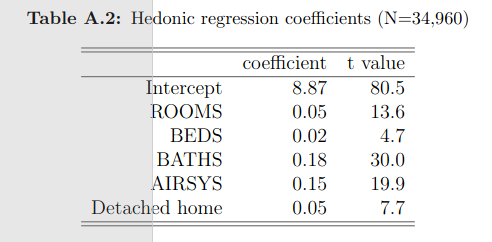

In [419]:
from IPython.display import Image
Image("Table_A.2.png")

In [420]:
    r_data = rental_data[['BUILT','ROOMS','BATHS','AIRSYS','BEDRMS','Unit Type','SMSA','year', 'log rent', 'VALUE']]
    
    #create dummies for year and SMSA
    dumvarcols = ['year', 'SMSA']
    
    r_data  = pd.get_dummies(r_data, columns = dumvarcols )
    #get an intercept
    r_data.loc[:,'intercept'] = 1.0
    
    x_var = r_data.columns.tolist()
    #remove the first dummy
    x_var.remove('year_1985')
    x_var.remove('SMSA_360.0')
    x_var.remove('log rent')
    x_var.remove('VALUE')
    
    
    print("The variables we are running the regression on")
    print(x_var)
    
    model = regression.linear_model.OLS(r_data['log rent'], r_data[x_var])
    results = model.fit()
    print(results.summary())
    
    

The variables we are running the regression on
['BUILT', 'ROOMS', 'BATHS', 'AIRSYS', 'BEDRMS', 'Unit Type', 'year_1987', 'year_1989', 'year_1991', 'year_1993', 'year_1995', 'year_1997', 'year_1999', 'year_2001', 'year_2003', 'year_2005', 'year_2007', 'year_2009', 'year_2011', 'year_2013', 'SMSA_520.0', 'SMSA_720.0', 'SMSA_1120.0', 'SMSA_1600.0', 'SMSA_1680.0', 'SMSA_1920.0', 'SMSA_2160.0', 'SMSA_3360.0', 'SMSA_3760.0', 'SMSA_4480.0', 'SMSA_5000.0', 'SMSA_5120.0', 'SMSA_5380.0', 'SMSA_5600.0', 'SMSA_5640.0', 'SMSA_5775.0', 'SMSA_5880.0', 'SMSA_6160.0', 'SMSA_6200.0', 'SMSA_6280.0', 'SMSA_6780.0', 'SMSA_7040.0', 'SMSA_7320.0', 'SMSA_7360.0', 'SMSA_7400.0', 'SMSA_7600.0', 'SMSA_8280.0', 'SMSA_8840.0', 'intercept']
                            OLS Regression Results                            
Dep. Variable:               log rent   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-

### Get Predicted Rent for Owned Home

['BUILT', 'ROOMS', 'BATHS', 'AIRSYS', 'BEDRMS', 'Unit Type', 'year_1987', 'year_1989', 'year_1991', 'year_1993', 'year_1995', 'year_1997', 'year_1999', 'year_2001', 'year_2003', 'year_2005', 'year_2007', 'year_2009', 'year_2011', 'year_2013', 'SMSA_520.0', 'SMSA_720.0', 'SMSA_1120.0', 'SMSA_1600.0', 'SMSA_1680.0', 'SMSA_1920.0', 'SMSA_2160.0', 'SMSA_3360.0', 'SMSA_3760.0', 'SMSA_4480.0', 'SMSA_5000.0', 'SMSA_5120.0', 'SMSA_5380.0', 'SMSA_5600.0', 'SMSA_5640.0', 'SMSA_5775.0', 'SMSA_5880.0', 'SMSA_6160.0', 'SMSA_6200.0', 'SMSA_6280.0', 'SMSA_6780.0', 'SMSA_7040.0', 'SMSA_7320.0', 'SMSA_7360.0', 'SMSA_7400.0', 'SMSA_7600.0', 'SMSA_8280.0', 'SMSA_8840.0', 'intercept']


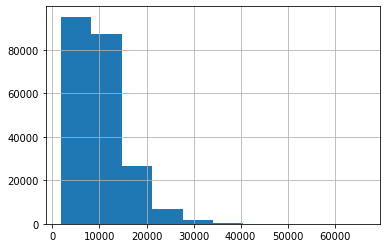

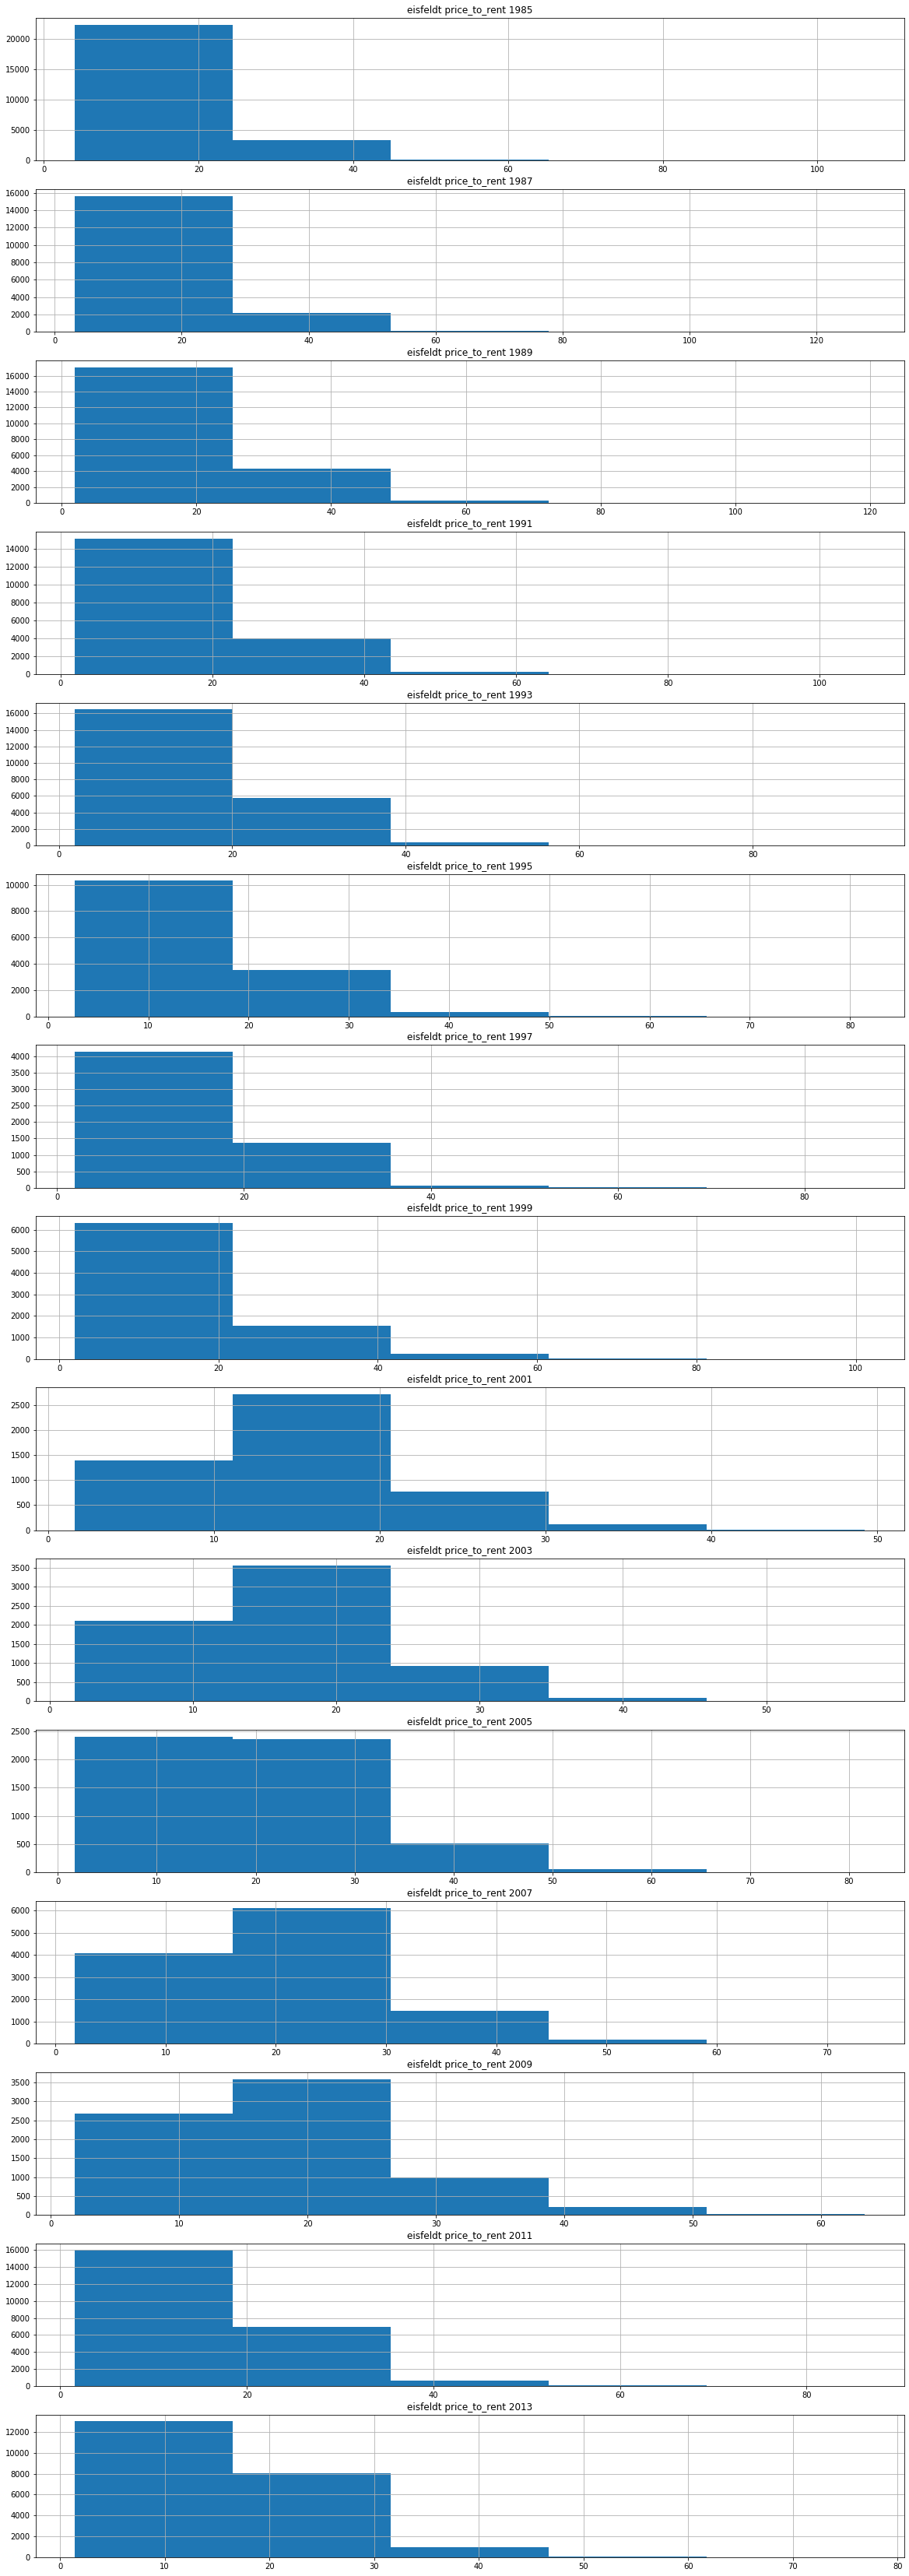

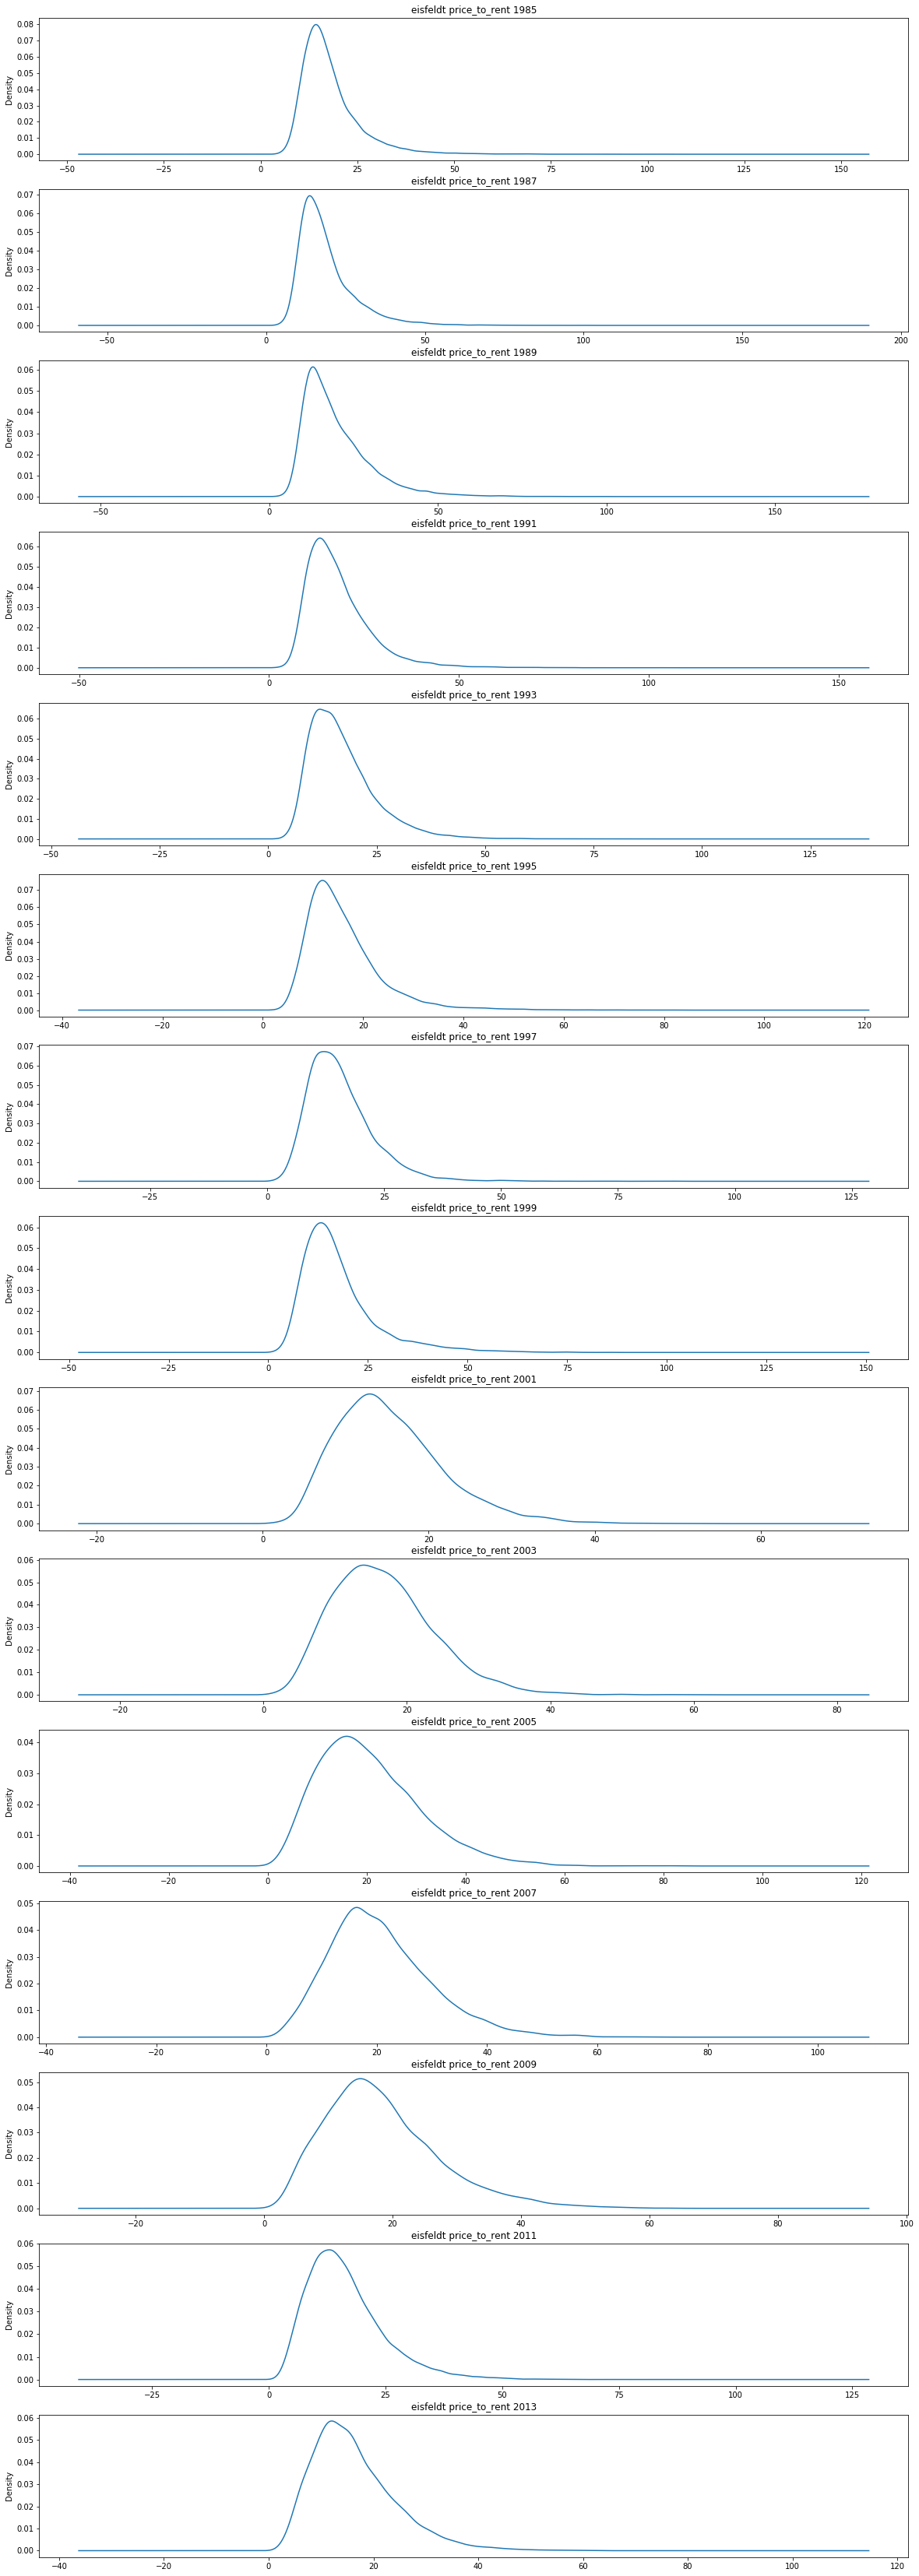

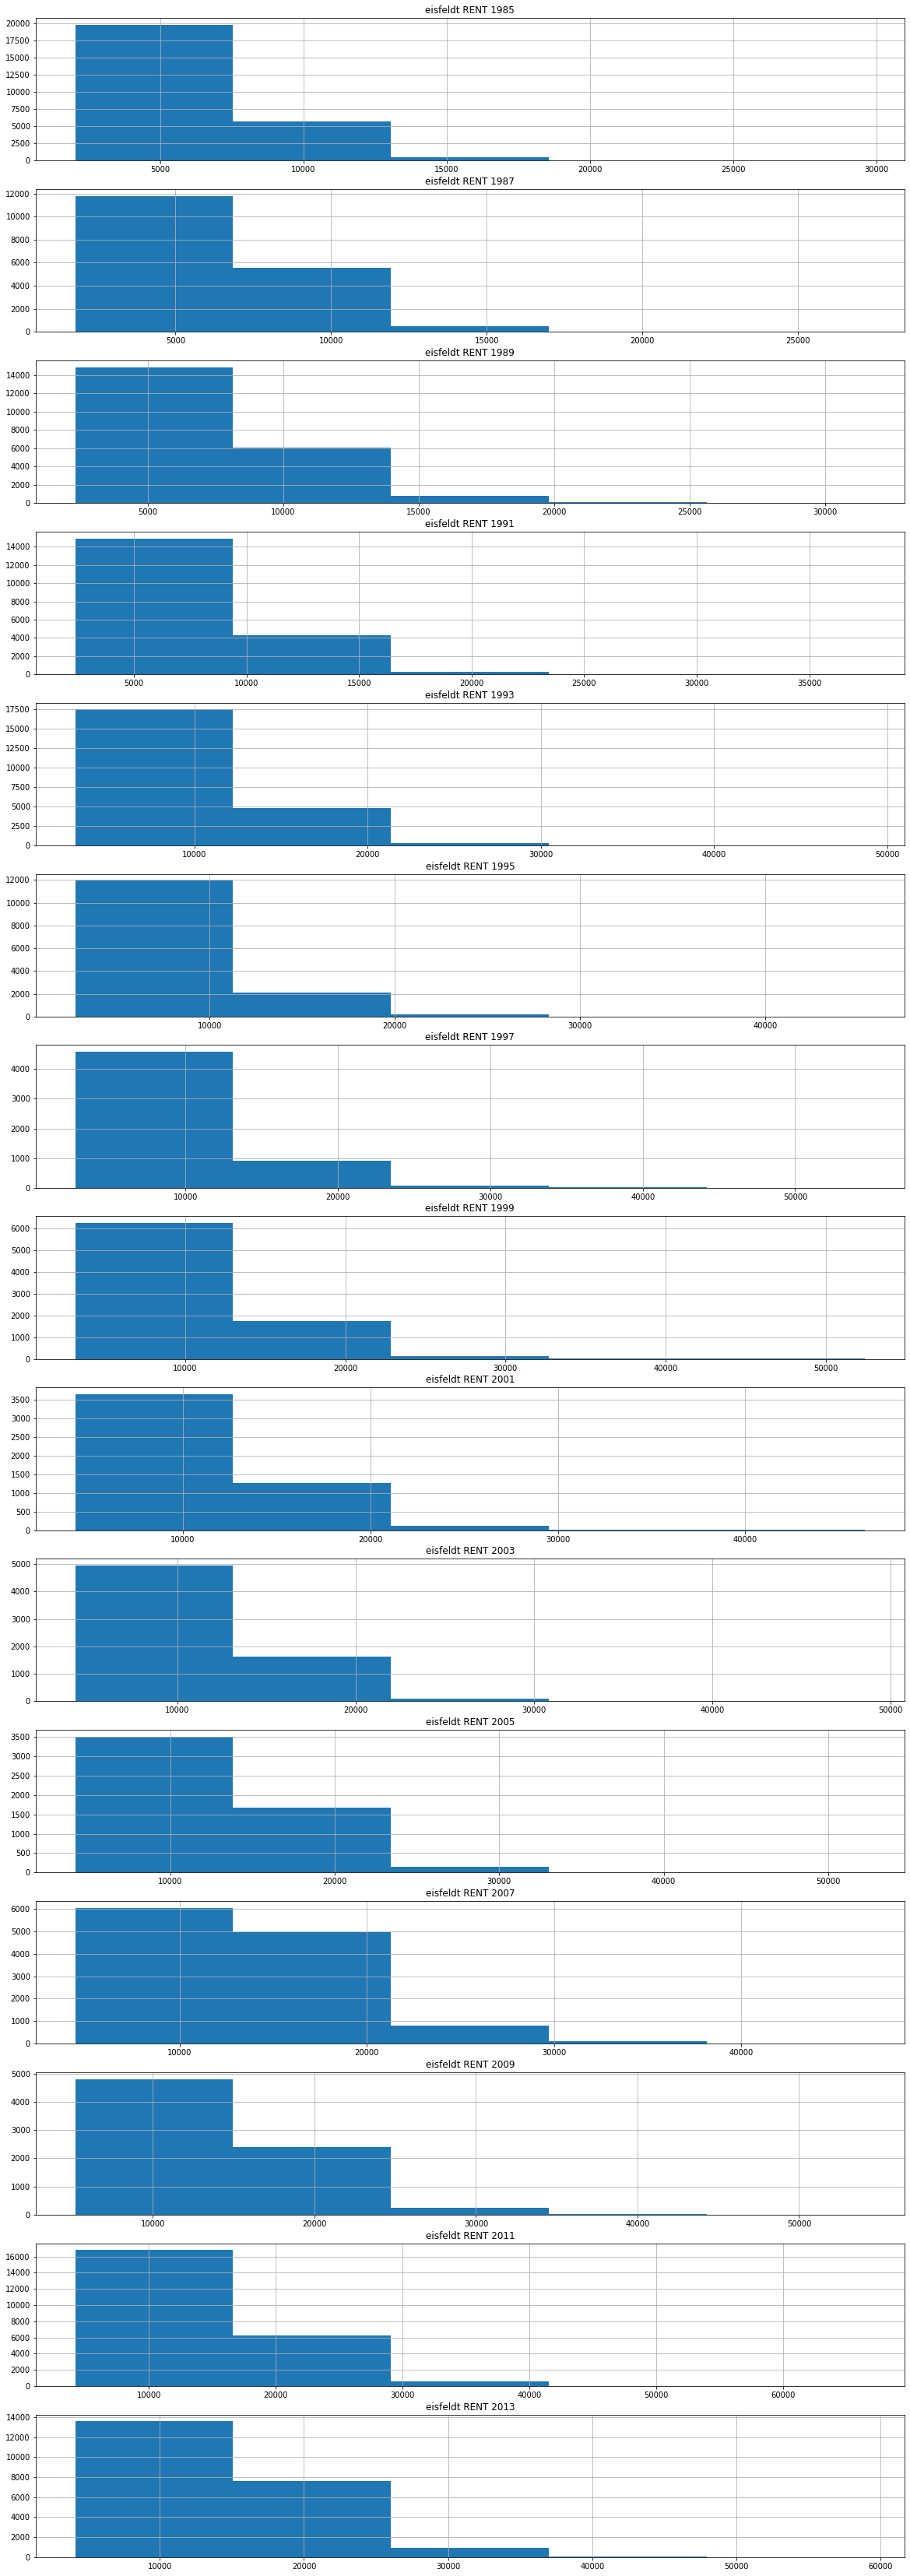

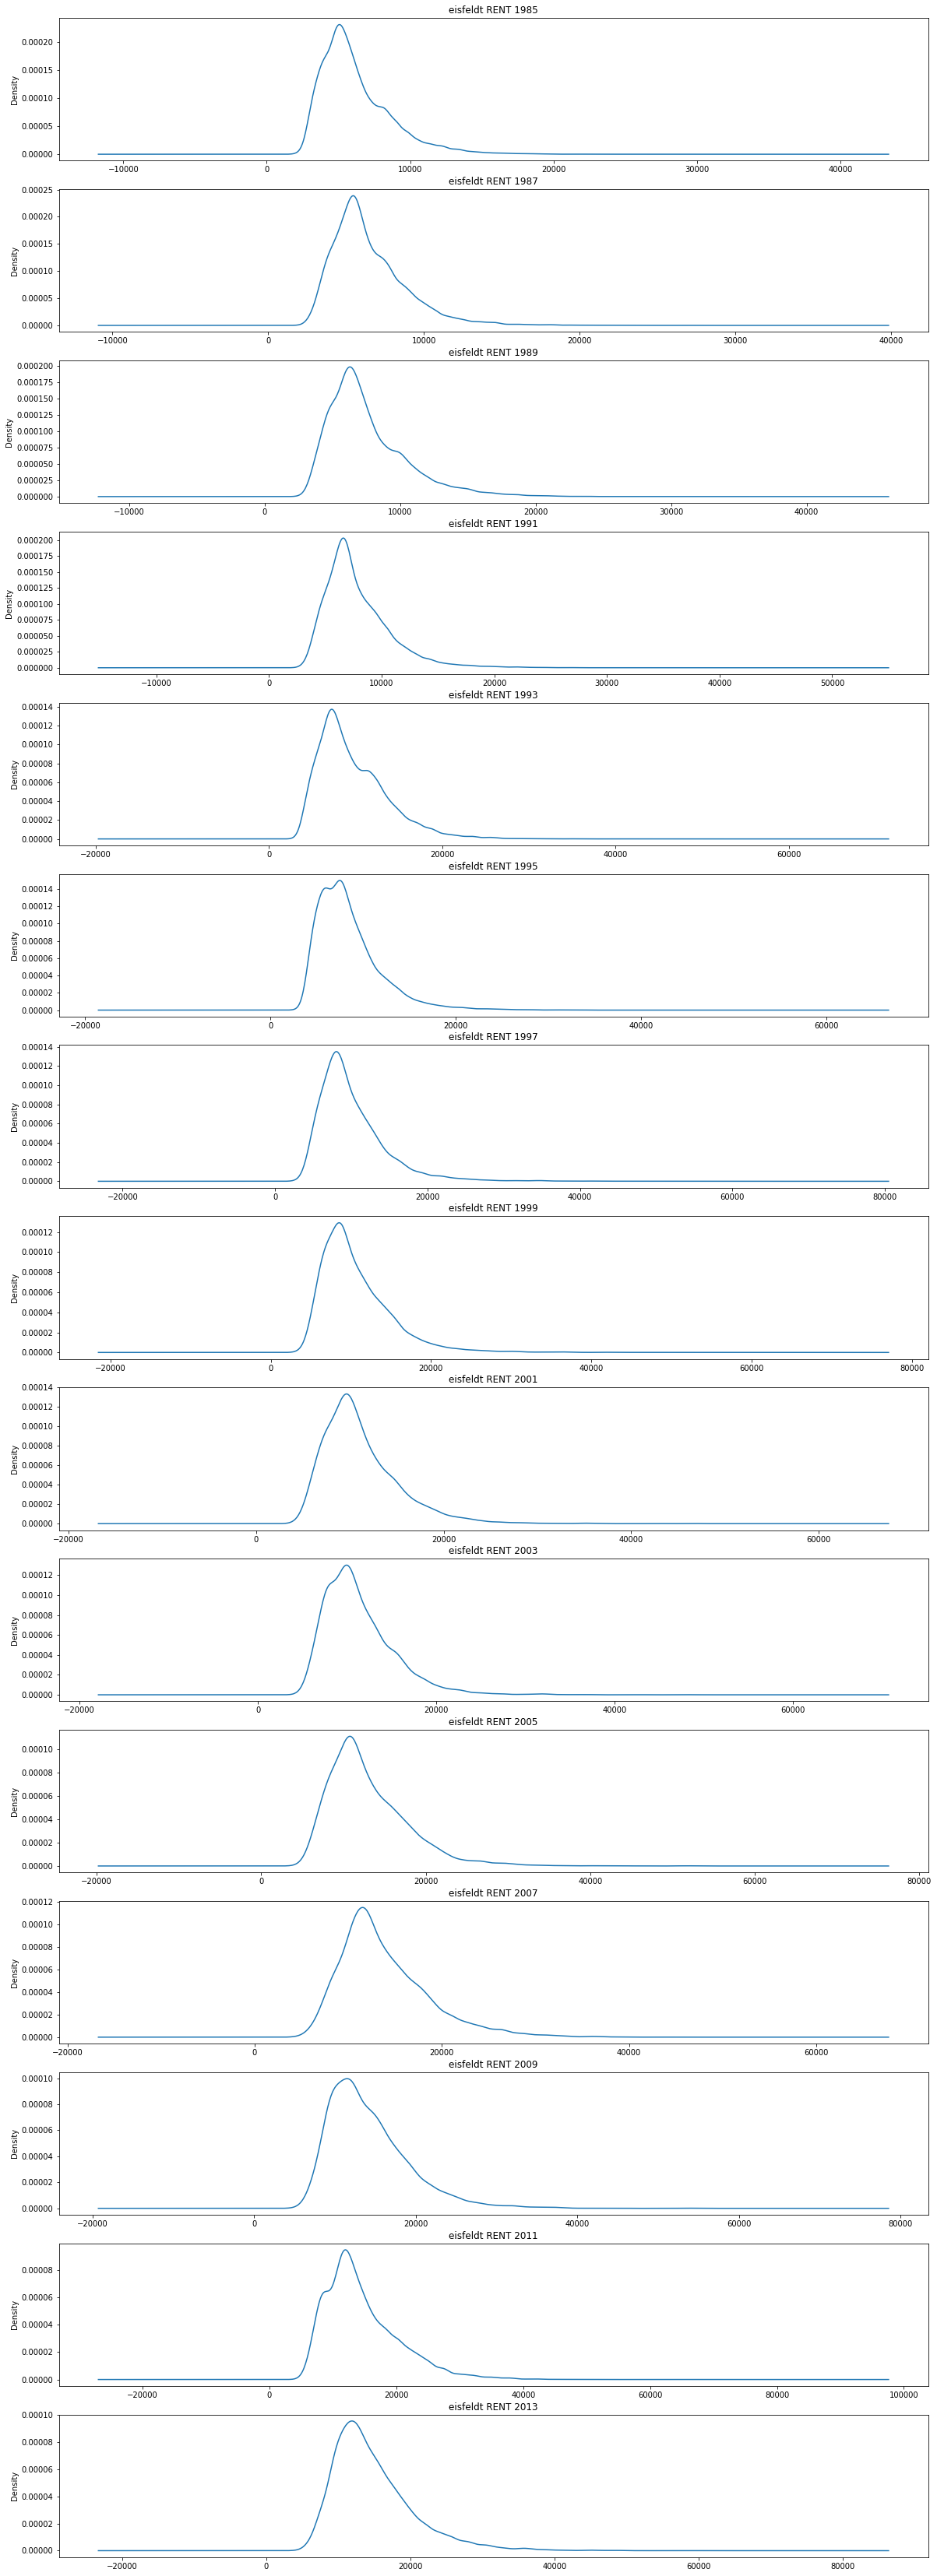

In [421]:
df_o = owned_data.copy()
df_o = pd.get_dummies(df_o, columns = dumvarcols )
df_o.loc[:,'intercept'] = 1.0
#remove the first dummy
print(x_var)
predictions = results.predict(df_o[x_var])
    
owned_data.loc[:,'eisfeldt log rent'] = predictions
owned_data.loc[:,'eisfeldt RENT'] = np.exp(predictions)
owned_data['eisfeldt RENT'].hist()
owned_data = owned_data.loc[owned_data['VALUE'] > 10]
owned_data.loc[:,'eisfeldt rent_to_price'] = owned_data['eisfeldt RENT'] / owned_data['VALUE']
owned_data.loc[:,'eisfeldt price_to_rent'] =  owned_data['VALUE'] / owned_data['eisfeldt RENT']
    
owned_data = owned_data.sort_values(['CITY', 'year'], axis = 0)
c.get_hist(owned_data, 'eisfeldt price_to_rent', 20,'price_to_rent_eisfeldt')
c.get_hist(owned_data, 'eisfeldt RENT', 20,'rent_eisfeldt')

owned.to_pickle(os.path.join(desktop,'eisfeldt_owned_cleaned.pkl'))

### Elast Net Regression

In [422]:
def get_tstat(X, y, model):
    sse = np.sum((model.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
    se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])
    t = model.coef_ / se
    return t[0]

elastic net regression

In [423]:
net_x = ['BUILT','ROOMS','AIRSYS','BEDRMS','Unit Type','BATHS']
reg =  ElasticNet(alpha=1., l1_ratio=0.2)
reg.fit(X=r_data[net_x],y = r_data['log rent'])
params = reg.coef_
coefs = dict(zip(net_x, reg.coef_))
cf = pd.DataFrame.from_dict(coefs , orient = 'index')
cf.columns = ['coef']

t = get_tstat(r_data[net_x],r_data['log rent'], reg)
t = dict(zip(net_x, t))
t = pd.DataFrame.from_dict(t , orient = 'index')
t.columns = ['t-stats']

df_reg = pd.concat([cf, t], axis = 1)
df_reg = df_reg.loc[df_reg['coef'] != 0.0]
print(df_reg)
regressors= df_reg.index.tolist()
print(regressors)

           coef     t-stats
BUILT  0.004746  395.471792
ROOMS  0.011135    4.486571
['BUILT', 'ROOMS']


In [424]:
    data_vars = regressors + ['Unit Type','SMSA','year', 'log rent', 'VALUE']
    r_data = rental_data[data_vars]
    
    #create dummies for year and SMSA
    dumvarcols = ['year', 'SMSA']
    
    r_data  = pd.get_dummies(r_data, columns = dumvarcols )
    #get an intercept
    r_data.loc[:,'intercept'] = 1.0
    
    x_var = r_data.columns.tolist()
    #remove the first dummy
    x_var.remove('year_1985')
    x_var.remove('SMSA_360.0')
    x_var.remove('log rent')
    x_var.remove('VALUE')
    
    
    print("The variables we are running the regression on")
    print(x_var)
    
    model = regression.linear_model.OLS(r_data['log rent'], r_data[x_var])
    results_elastic = model.fit()
    print(results_elastic.summary())
    
    

The variables we are running the regression on
['BUILT', 'ROOMS', 'Unit Type', 'year_1987', 'year_1989', 'year_1991', 'year_1993', 'year_1995', 'year_1997', 'year_1999', 'year_2001', 'year_2003', 'year_2005', 'year_2007', 'year_2009', 'year_2011', 'year_2013', 'SMSA_520.0', 'SMSA_720.0', 'SMSA_1120.0', 'SMSA_1600.0', 'SMSA_1680.0', 'SMSA_1920.0', 'SMSA_2160.0', 'SMSA_3360.0', 'SMSA_3760.0', 'SMSA_4480.0', 'SMSA_5000.0', 'SMSA_5120.0', 'SMSA_5380.0', 'SMSA_5600.0', 'SMSA_5640.0', 'SMSA_5775.0', 'SMSA_5880.0', 'SMSA_6160.0', 'SMSA_6200.0', 'SMSA_6280.0', 'SMSA_6780.0', 'SMSA_7040.0', 'SMSA_7320.0', 'SMSA_7360.0', 'SMSA_7400.0', 'SMSA_7600.0', 'SMSA_8280.0', 'SMSA_8840.0', 'intercept']
                            OLS Regression Results                            
Dep. Variable:               log rent   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                   

#### elastic coefs with sample weights

In [425]:
reg =  LinearRegression(fit_intercept = False)
reg.fit(X=r_data[x_var],y = r_data['log rent'], sample_weight = rental_data['WEIGHT'])
params = reg.coef_
coefs = dict(zip(x_var, reg.coef_))
cf = pd.DataFrame.from_dict(coefs , orient = 'index')
cf.columns = ['coef']

t = get_tstat(r_data[x_var],r_data['log rent'], reg)
t = dict(zip(x_var, t))
t = pd.DataFrame.from_dict(t , orient = 'index')
t.columns = ['t-stats']

df_reg = pd.concat([cf, t], axis = 1)
print(df_reg)

                 coef     t-stats
BUILT        0.002945   48.222974
ROOMS        0.113478  120.753616
Unit Type    0.363613   20.723734
year_1987    0.113665   18.458011
year_1989    0.218240   39.826114
year_1991    0.317539   52.722864
year_1993    0.366105   65.895951
year_1995    0.417440   60.854357
year_1997    0.481733   52.686098
year_1999    0.569470   70.351002
year_2001    0.675091   72.887243
year_2003    0.715510   88.454673
year_2005    0.776846   84.016958
year_2007    0.842401  118.825887
year_2009    0.897937  113.501081
year_2011    0.941261  168.529874
year_2013    0.974106  169.290452
SMSA_520.0  -0.572314  -50.670826
SMSA_720.0  -0.509569  -45.264486
SMSA_1120.0 -0.169842  -16.263874
SMSA_1600.0 -0.403065  -39.225676
SMSA_1680.0 -0.729185  -51.474007
SMSA_1920.0 -0.487093  -44.620840
SMSA_2160.0 -0.601593  -58.073503
SMSA_3360.0 -0.621849  -57.113423
SMSA_3760.0 -0.617519  -48.120755
SMSA_4480.0 -0.162639  -16.894950
SMSA_5000.0 -0.349119  -29.798755
SMSA_5120.0 -0

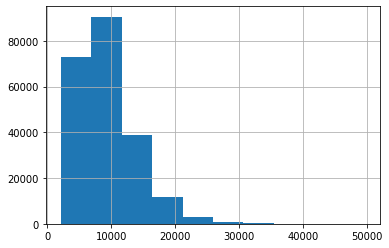

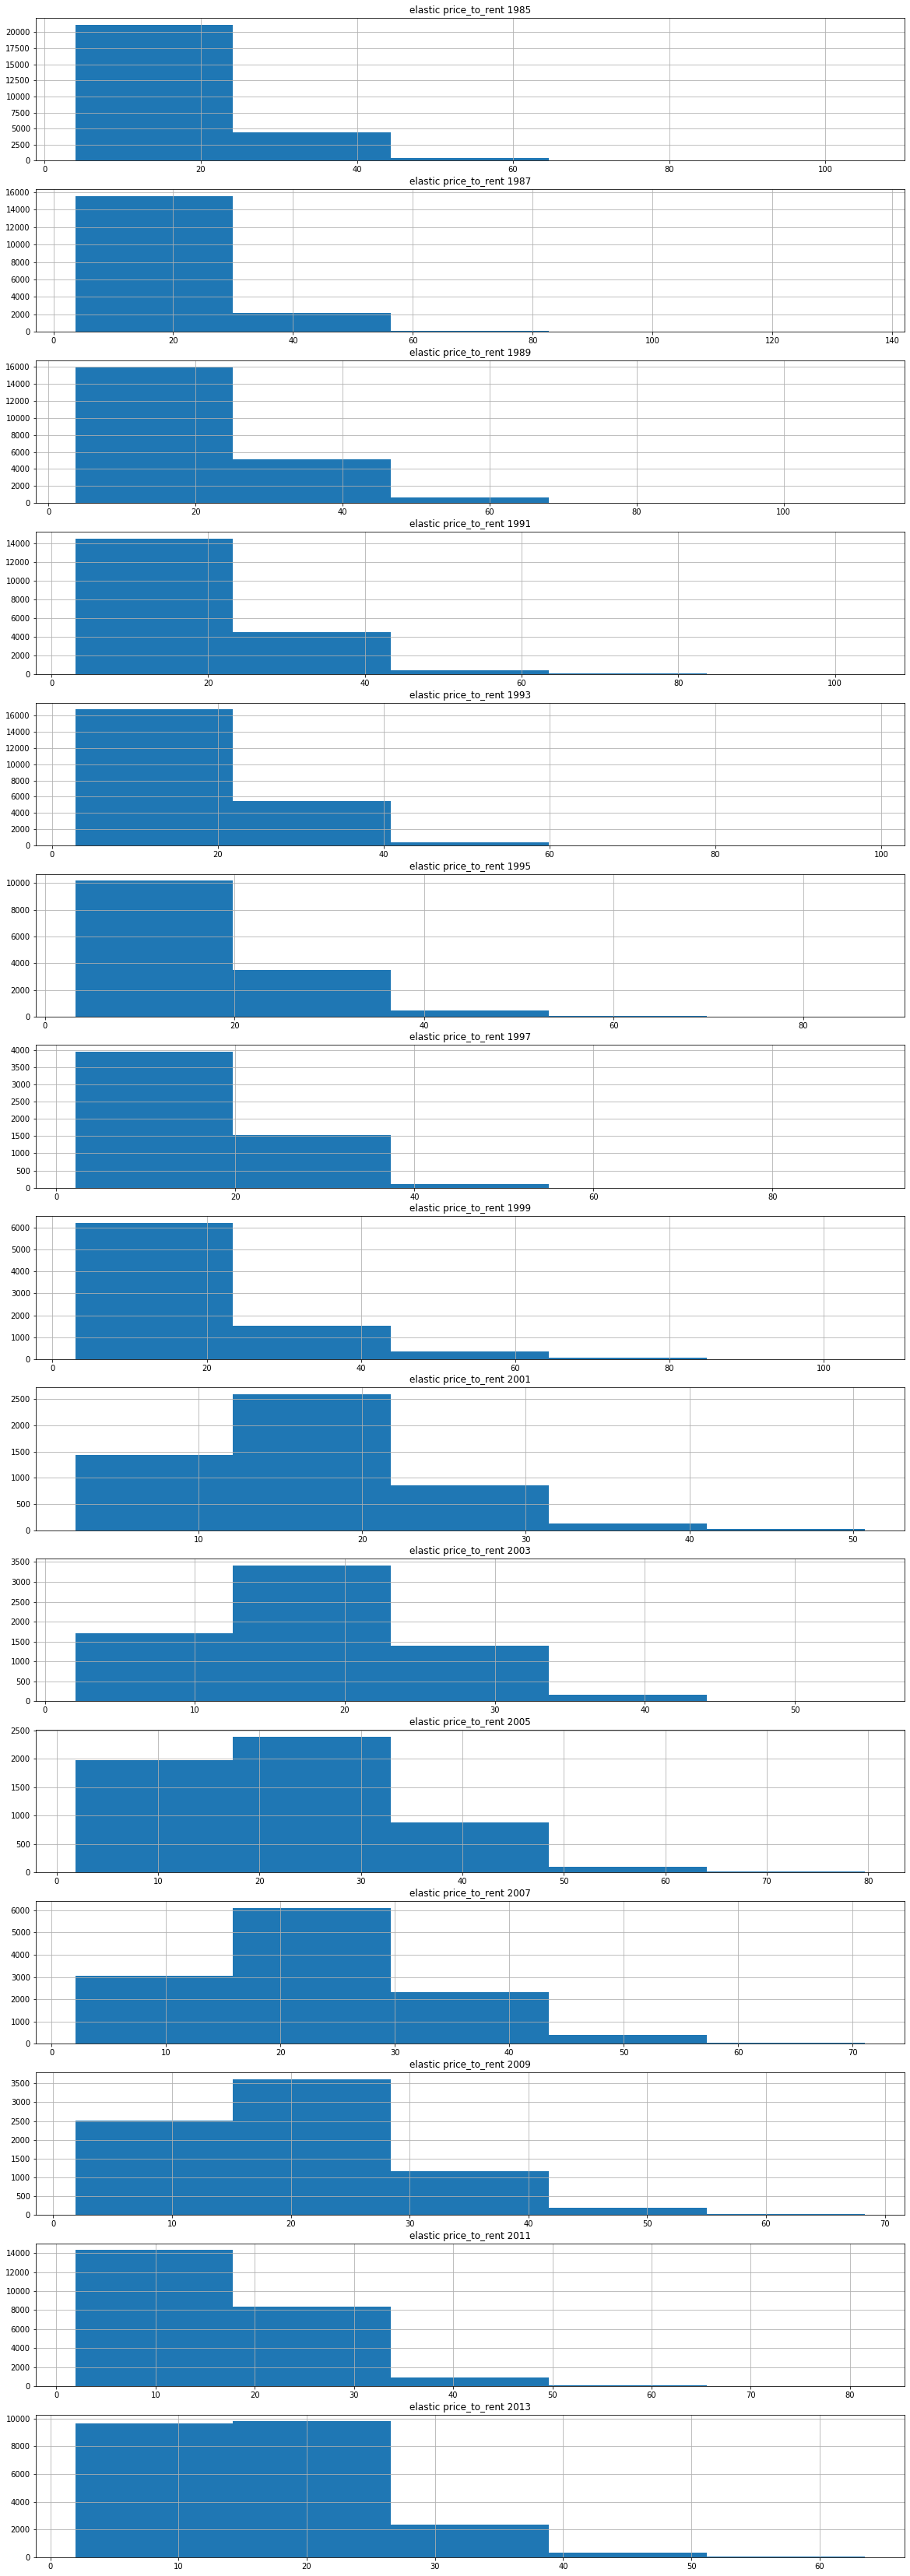

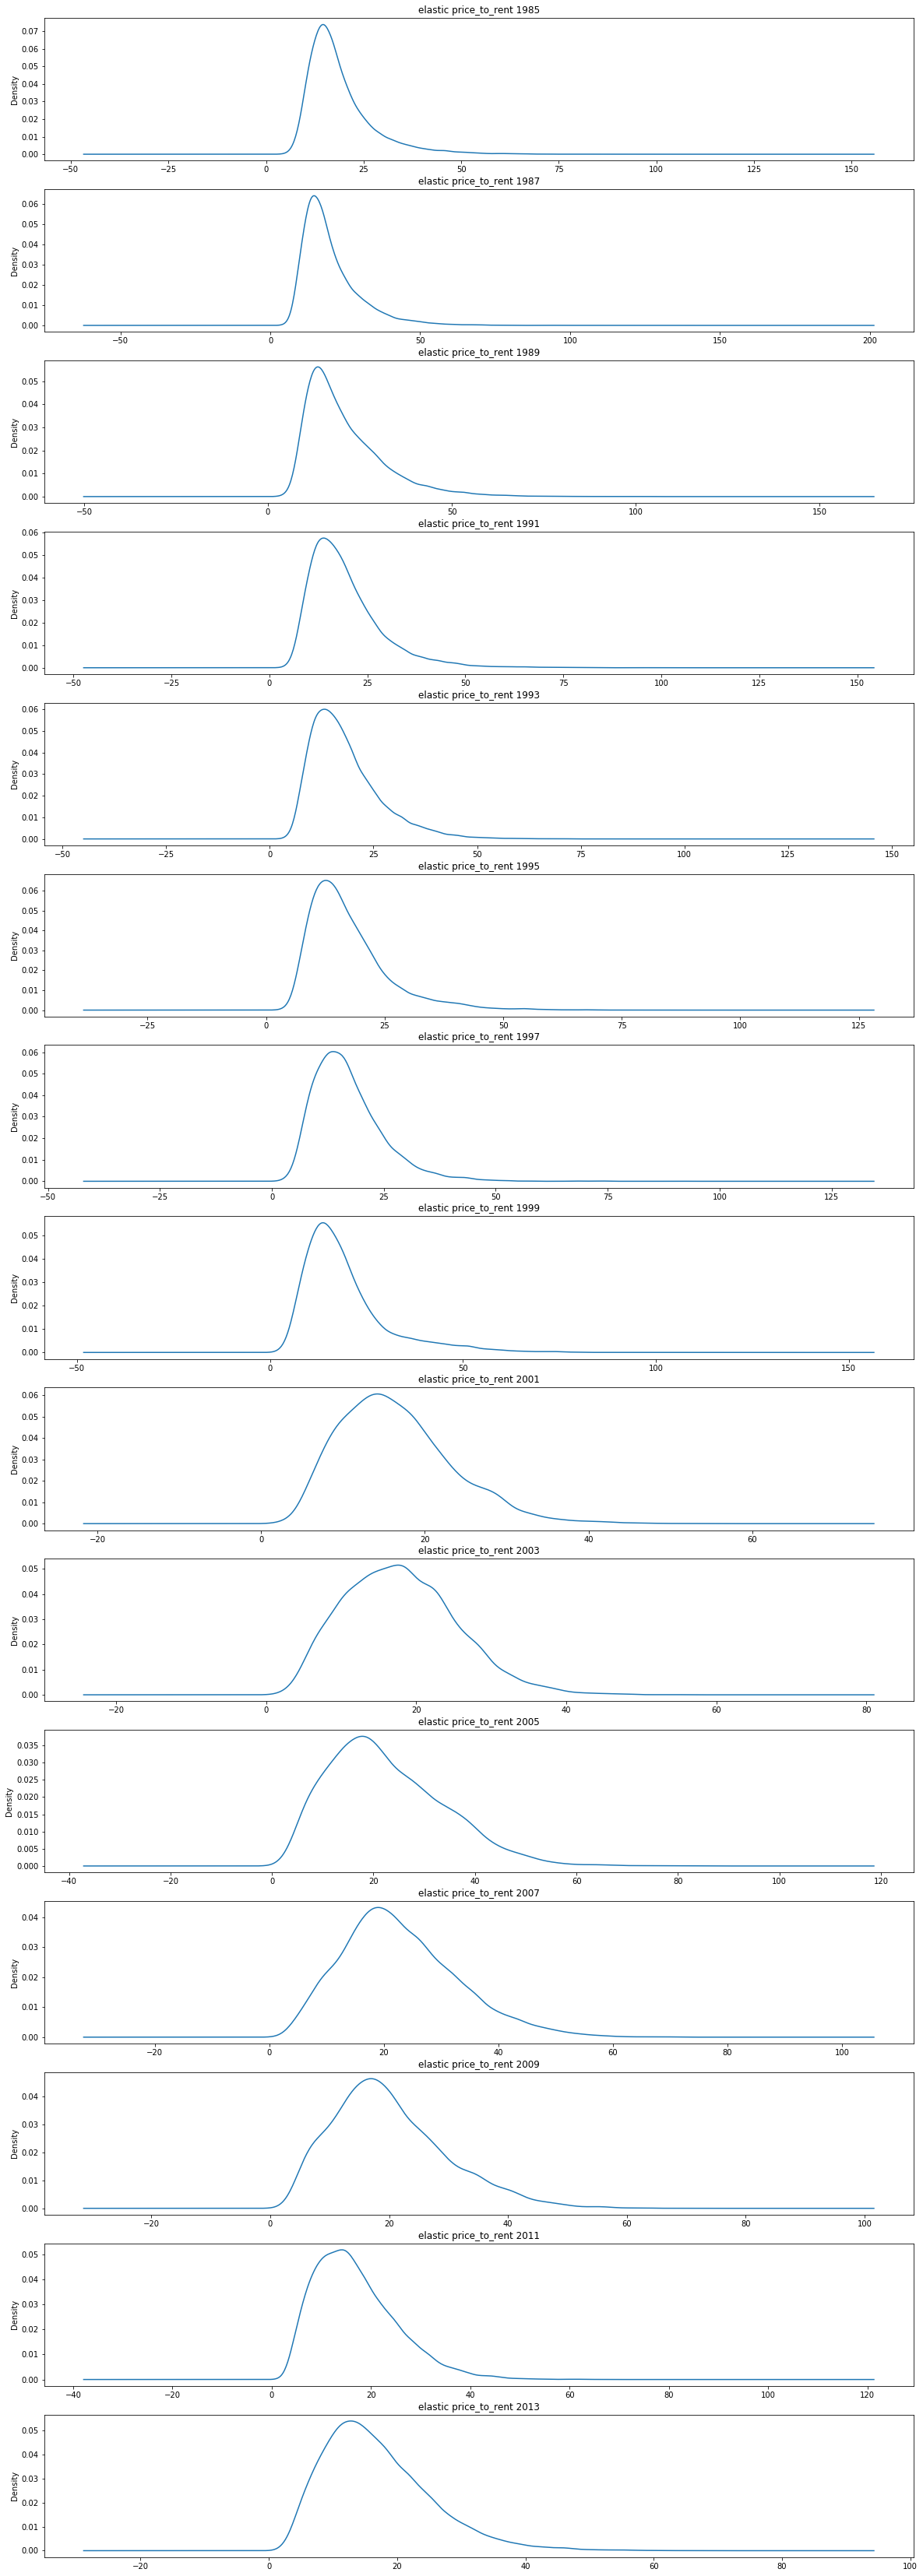

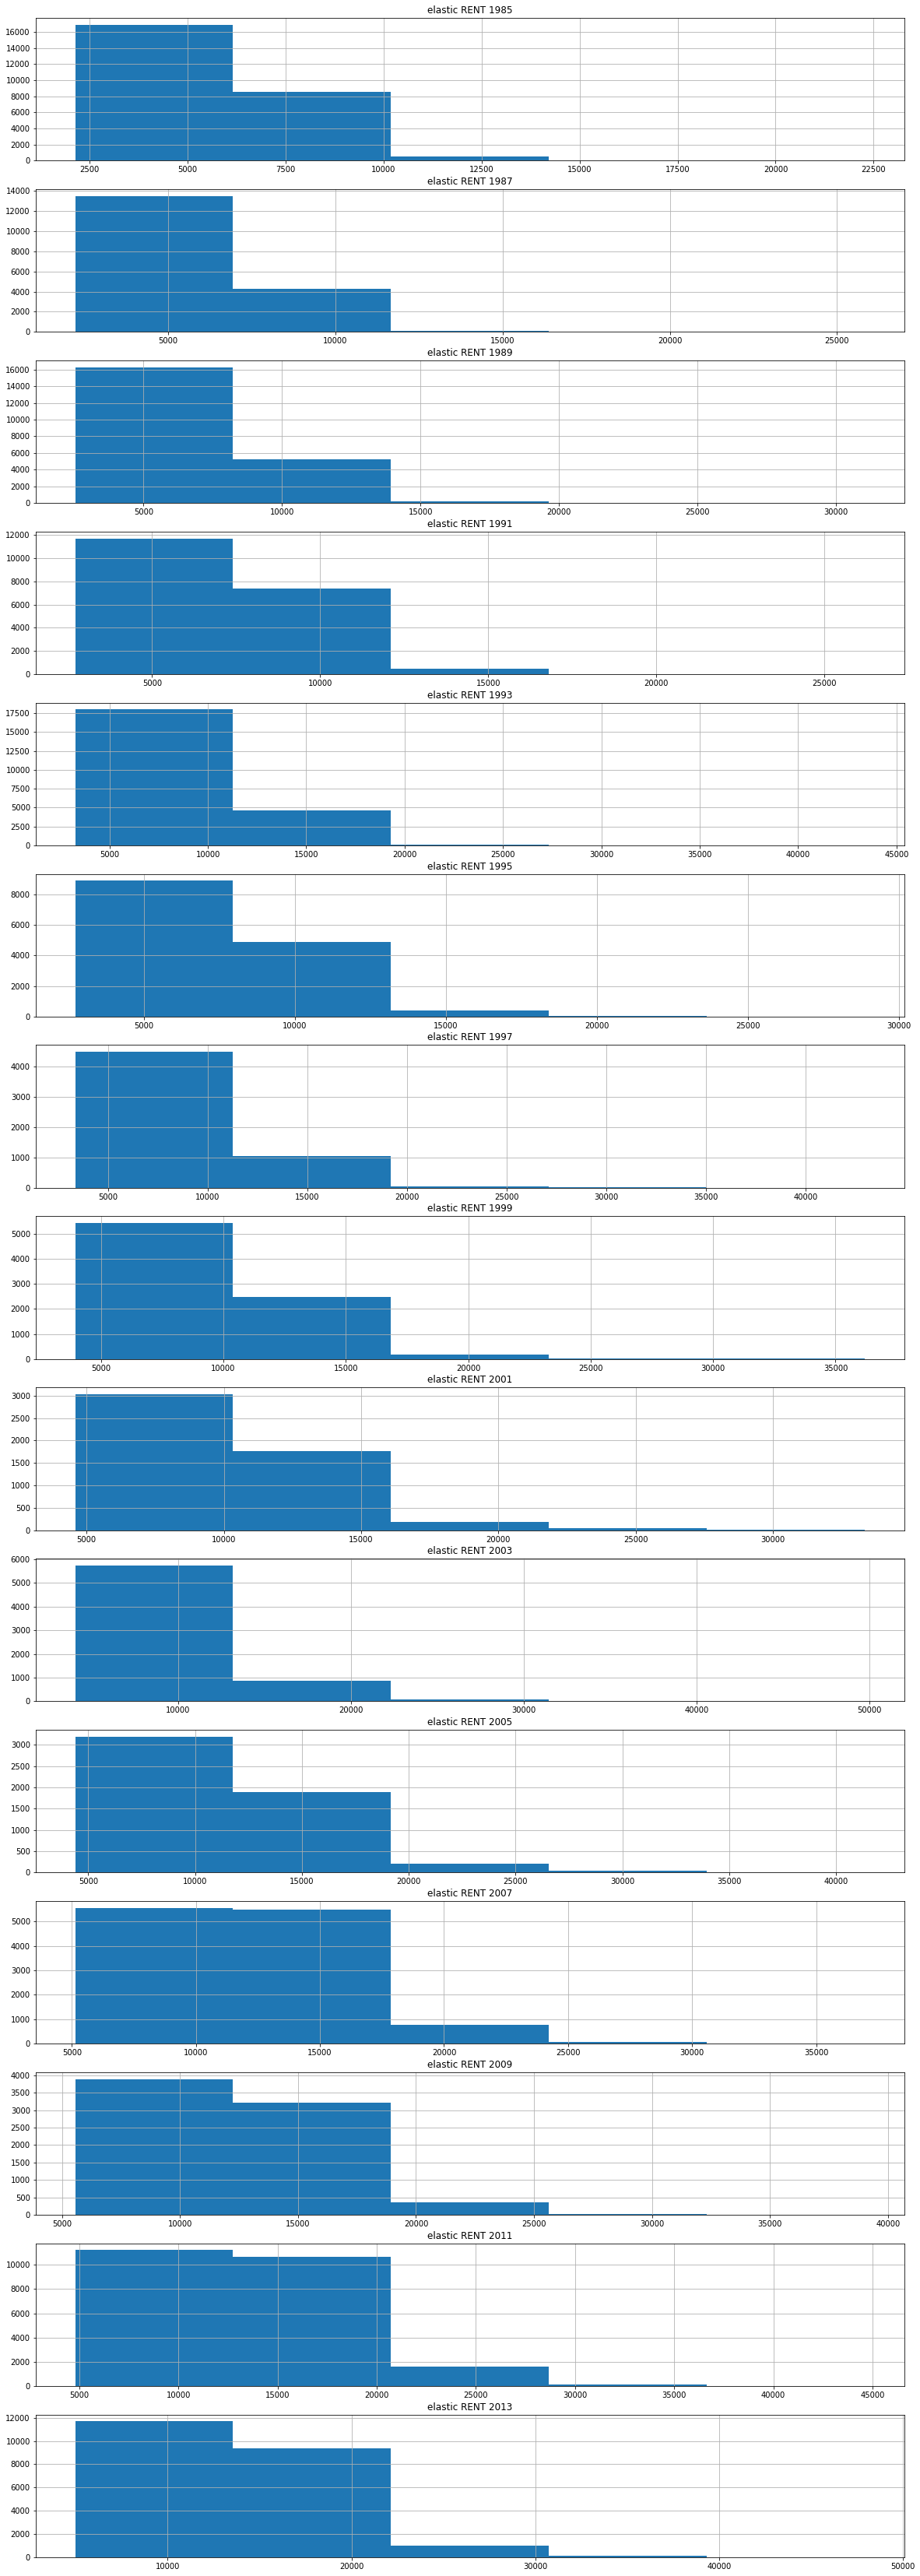

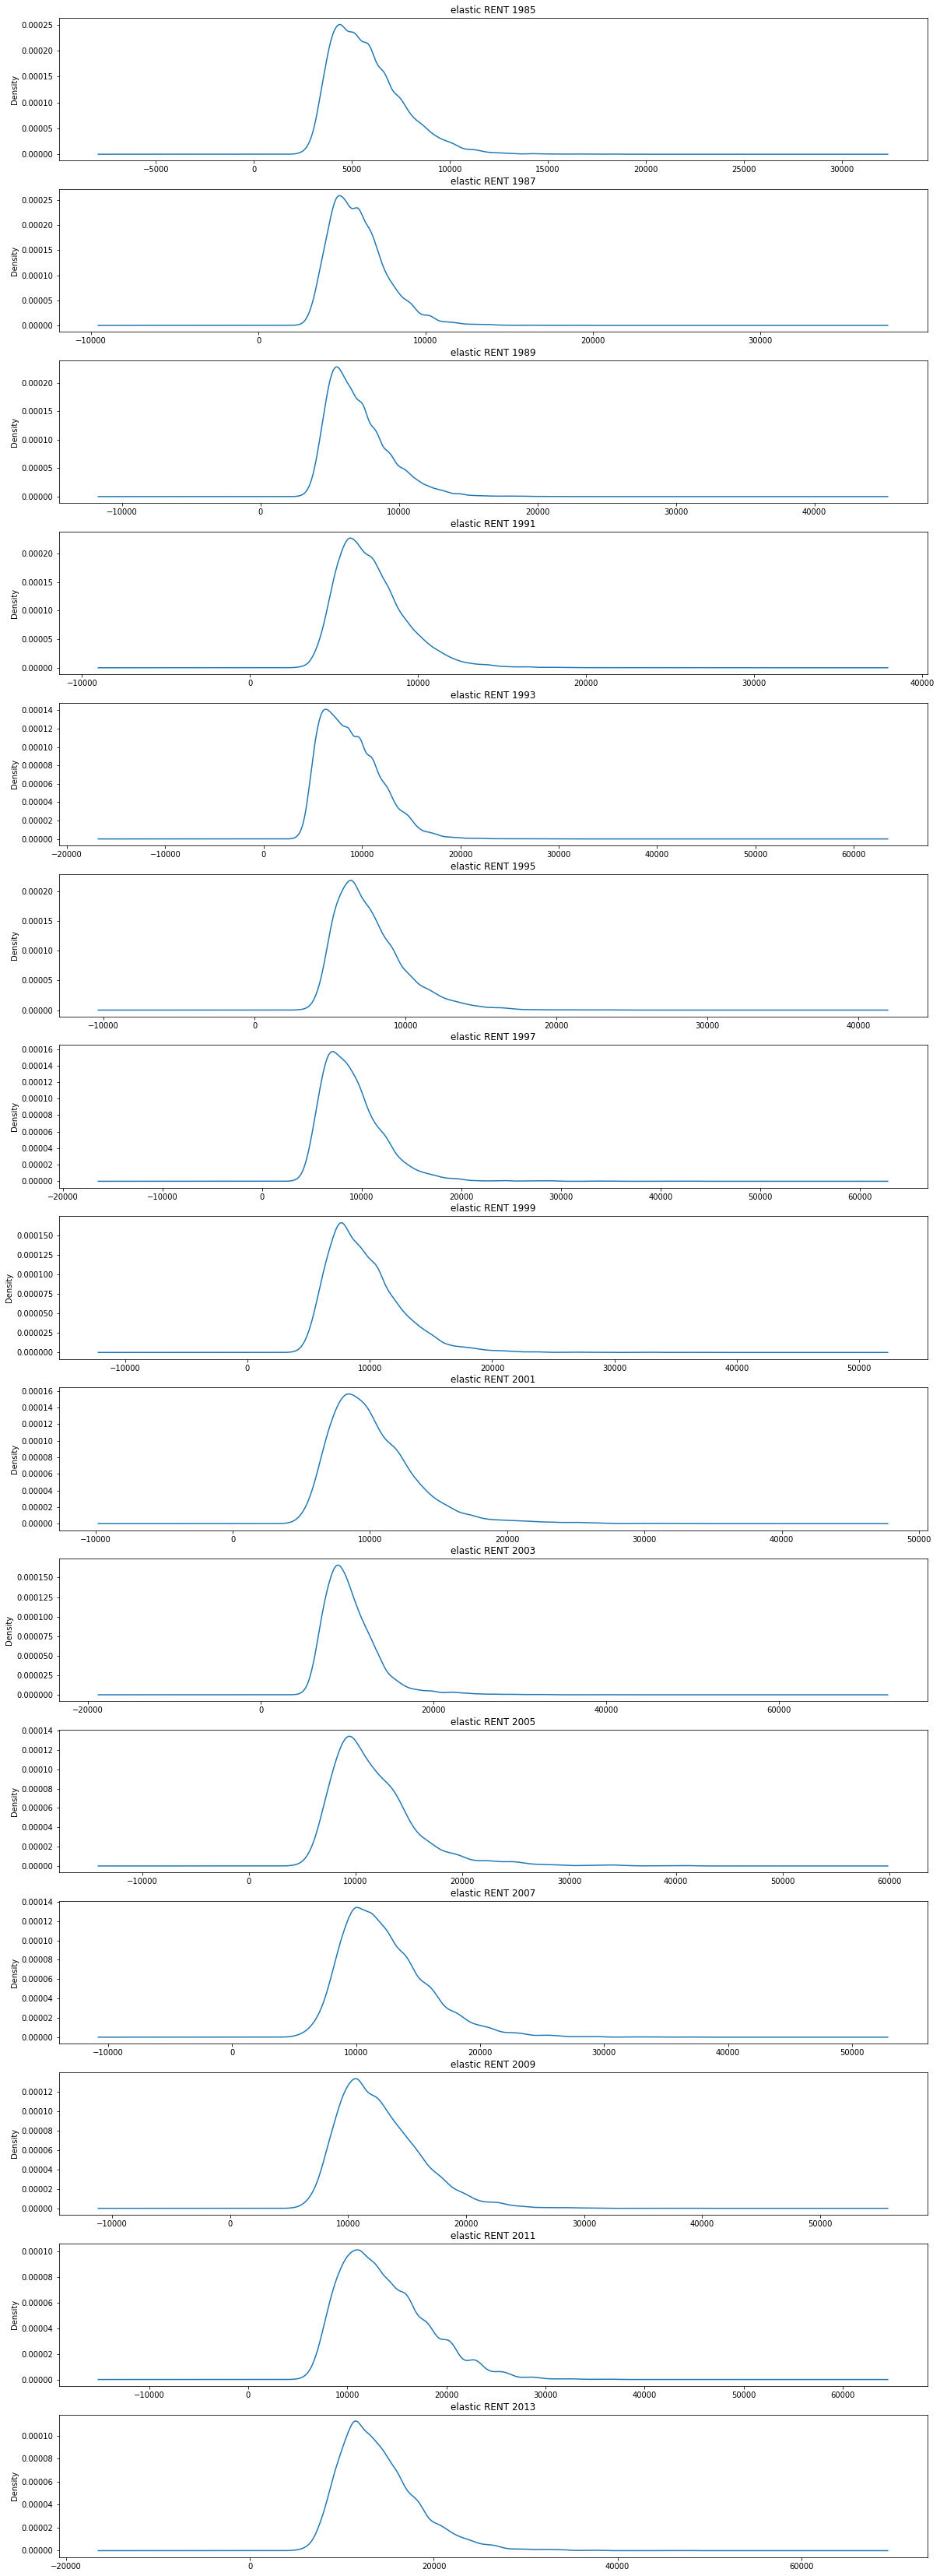

In [426]:
df_o = owned_data.copy()
df_o = pd.get_dummies(df_o, columns = dumvarcols )
df_o.loc[:,'intercept'] = 1.0
#remove the first dummy
predictions = reg.predict(df_o[x_var])
    
owned_data.loc[:,'log rent'] = predictions
owned_data.loc[:,'elastic RENT'] = np.exp(predictions)
owned_data['elastic RENT'].hist()
owned_data.loc[:,'elastic rent_to_price'] = owned_data['elastic RENT'] / owned_data['VALUE']
owned_data.loc[:,'elastic price_to_rent'] =  owned_data['VALUE'] / owned_data['elastic RENT']
    
owned_data = owned_data.sort_values(['CITY', 'year'], axis = 0)
c.get_hist(owned_data, 'elastic price_to_rent', 20,'price_to_rent_elastic_net')
c.get_hist(owned_data, 'elastic RENT', 20,'rent_elastic_net')

## cache the results and choose which model for rent

In [427]:
owned_data.loc[:,'RENT'] = owned_data.loc[:,'elastic RENT']
owned_data.loc[:,'rent_to_price'] = owned_data.loc[:,'elastic rent_to_price']
owned_data.loc[:,'price_to_rent'] = owned_data.loc[:,'elastic price_to_rent']

rented.to_pickle(os.path.join(desktop,'rented_cleaned.pkl'))
owned_data.to_pickle(os.path.join(desktop,'owned_cleaned.pkl'))

## Aggregating rent-to-price ratios with nonparametric weights

We wish to find the median rent-to-price of rental homes, but our dataset has rent-to-price ratios computed on owned homes.  To account for sample selection in our dataset of rent-to-price  ratios,  we  weight  the  owned  homes  in  a  city  to  the  distribution  of  rental  homes.(We do not use the alternate methodology – to estimate the hedonic coefficients on ownedhomes, and then compute rent-to-price ratios on rental homes directly – because there are not enough rental homes for a meaningful sample in some city-year bins.  Indeed, the very same  cities  that  are  less  populated  are  the  ones  with  a  low  ratio  of  rental  homes.)  This procedure is similar to the nonparametric approach used in Barsky et al (2002.)

Sample selection is an issue because rent-to-price ratios are decreasing in house prices(and in house rents), as discussed in the section on house level data in the main text.

For  each  city  in  each  year,  we  re-weight  the  owner-occupied  houses  as  follows. First, line  up  all  the  houses  by  predicted  rent.   Then  bin  by  percentile  of  predicted  rent.   Next determine the density of renter-occupied in the predicted rent space.  Finally, compute the median  rent-to-price  ratio  among  owner-occupied,  using  the  density  of  renter-occupied  to take a weighted median.

Note that relative to an unweighted median, this nonparametric procedure reduces the weight  on  expensive  homes,  which  are  the  same  homes  for  which  the  hedonic  model  hasthe largest errors (because it is estimated upon rental homes, which are likely to be smaller homes.

In [438]:
run = 'no'

if run == 'yes':
    #this incremental amount for bins from 0 to 100
    incremental=5

    #
    owned_data.loc[:,'R/V Weighted'] = 0.0
    owned_data.loc[:,'V/R Weighted'] = 0.0

    #create a dictionary for the data
    w_df = {}

    #key for each city
    for i in owned_data.CITY.unique():
        w_df[i] = {}
        #key for each year
        for j in owned_data.year.unique():
            w_df[i][j] = {}
            #key for each bin
            for q in np.arange(0,100,incremental):
                w_df[i][j][q] = 0.0

    if not os.path.exists(os.path.join(desktop,'density.pkl')):
        for i in owned_data.CITY.unique():
            for j in owned_data.year.unique():
                #for each increment
                for q in np.arange(0,100,incremental):
                    #get the rental data and owned matching the city and year
                    rental_cy=rental_data.loc[((rental_data['CITY']==i)) & (rental_data['year']==j)]
                    owned_cy=owned_data.loc[((owned_data['CITY']==i)) & (owned_data['year']==j)]

                    try:
                        #get the rental and owned data in the bins
                        rental_den=rental_cy.loc[(rental_cy['RENT']>np.percentile(owned_cy['RENT'], q))  & (rental_cy['RENT']<=np.percentile(owned_cy['RENT'],q+incremental))]
                        owned_den=owned_cy.loc[(owned_cy['RENT']>np.percentile(owned_cy['RENT'], q))  & (owned_cy['RENT']<=np.percentile(owned_cy['RENT'],q+incremental))]
                        if rental_cy.shape[0]==0:
                            density=0
                        else:
                            density=rental_den.shape[0]/rental_cy.shape[0]
                        weight_value=density/(incremental/100)
                        w_df[i][j][q] = weight_value
                    except IndexError:
                        #if there is no data
                        pass
        with open(os.path.join(desktop,'density.pkl'), 'wb') as handle:
            pickle.dump(w_df, handle, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        with open(os.path.join(desktop,'density.pkl'), 'rb') as handle:
            w_df = pickle.load(handle)

    if not os.path.exists(os.path.join(desktop,'median.pkl')):
        #get the media on a city level
        owned_data = owned_data.reset_index(drop=True)
        median = {}
        for i in owned_data.CITY.unique():
            median[i] = {}
            for j in owned_data.year.unique():
                median[j] = {}


        for i in owned_data.CITY.unique():
            for j in owned_data.year.unique():
                for q in np.arange(0,100,incremental):
                    owned_cy=owned_data.loc[((owned_data['CITY']==i)) & (owned_data['year']==j)]
                    try:
                        owned_den=owned_cy.loc[(owned_cy['RENT']>np.percentile(owned_cy['RENT'], q))  & (owned_cy['RENT']<=np.percentile(owned_cy['RENT'],q+incremental))]
                        for a in owned_den.index:
                            owned_data.loc[owned_data.index == a, 'R/V Weighted'] = w_df[i][j][q] * owned_data.loc[owned_data.index == a, 'rent_to_price']
                            owned_data.loc[owned_data.index == a, 'V/R Weighted'] = w_df[i][j][q] * owned_data.loc[owned_data.index == a, 'price_to_rent']
                    except IndexError:
                        pass
                        
        for i in owned_data.CITY.unique():
            for j in owned_data.year.unique():
                median[i][j] = owned_data.loc[((owned_data['CITY']==i)) & (owned_data['year']==j)]['R/V Weighted'].median()

        with open(os.path.join(desktop,'median.pkl'), 'wb') as handle:
            pickle.dump(median, handle, protocol=pickle.HIGHEST_PROTOCOL)

        owned_data.to_pickle(os.path.join(desktop,'owned_cleaned_weighted.pkl'))

    else:
        with open(os.path.join(desktop,'median.pkl'), 'rb') as handle:
            median = pickle.load(handle)

        print(pd.DataFrame.from_dict(median))
        owned_data = pd.read_pickle(os.path.join(desktop,'owned_cleaned_weighted.pkl'))


"""
owned_data['price_to_rent'] =  owned_data['VALUE'] / (1.0 * owned_data['RENT'] * 12.0)
for i in owned_data.year.unique():
    sns.distplot(owned_data.loc[owned_data['year']==i,'price_to_rent' ], kde = True, hist = False,kde_kws={'clip': (0.0, 50.0)}, label = i)
sns.plot.show()

"""


KeyboardInterrupt: 

   level_0  index  year         RENT  ZINC2  EBAR  RCNTRL   VALUE  NUNIT2  \
0        0    119  1985  5749.373616  20000   2.0    -9.0   75000     3.0   
1        1    605  1985  6831.040836  62000   2.0    -9.0  135000     1.0   
2        2    644  1985  8571.417219  48000   2.0    -9.0  250001     1.0   
3        3    772  1985  6098.232873  54000   2.0    -9.0   89000     2.0   
4        4    931  1985  5921.234600  21000   2.0    -9.0   77000     3.0   
5        5    932  1985  6801.470397      0   2.0    -9.0   70000     1.0   
6        6   1144  1985  9052.156190  17840   2.0    -9.0  250001     1.0   
7        7   1145  1985  9322.744357  18300   2.0    -9.0  150000     1.0   
8        8   1303  1985  7214.168557  40800   2.0    -9.0  120000     1.0   
9        9   1304  1985  7429.815371  31800   2.0    -9.0  200000     1.0   

   CONDO  ...  eisfeldt rent_to_price  eisfeldt price_to_rent  log rent  \
0    1.0  ...                0.092749               10.781832  8.656846   
1 